# 0. Import Packages

In [3]:
# Core utilities
import os
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import joblib

# Visualization and EDA
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from ydata_profiling import ProfileReport

%matplotlib inline

# Statistics
from scipy import stats
from scipy.stats import probplot, chi2_contingency, chi2

# estimator selection and pipelines
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_val_predict,
)
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder

# Metrics and calibration
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    roc_curve,
    roc_auc_score,
)
from sklearn.calibration import CalibratedClassifierCV

# Imbalanced learning
from imblearn.over_sampling import SMOTE

# Models
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    BaggingClassifier,
    AdaBoostClassifier,
    ExtraTreesClassifier,
)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier

# Explainability and visualization helpers
from sklearn.inspection import permutation_importance
from yellowbrick.model_selection import FeatureImportances

# 1. Getting the Data

## 1.1 Import the req CSV files

In [4]:
cc_dataset_end_to_end_dataset = pd.read_csv('dataset/application_record.csv')
credit_status_v2 = pd.read_csv('dataset/credit_record.csv')

In [5]:
cc_dataset_end_to_end_dataset.head()

ID CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
0  5008804           M            Y               Y             0   
1  5008805           M            Y               Y             0   
2  5008806           M            Y               Y             0   
3  5008808           F            N               Y             0   
4  5008809           F            N               Y             0   

   AMT_INCOME_TOTAL      NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0          427500.0               Working               Higher education   
1          427500.0               Working               Higher education   
2          112500.0               Working  Secondary / secondary special   
3          270000.0  Commercial associate  Secondary / secondary special   
4          270000.0  Commercial associate  Secondary / secondary special   

     NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  DAYS_BIRTH  DAYS_EMPLOYED  \
0        Civil marriage   Rented apartment      -12005          -4542   
1        Civil marriage   Rented apartment      -12005          -4542   
2               Married  House / apartment      -21474          -1134   
3  Single / not married  House / apartment      -19110          -3051   
4  Single / not married  House / apartment      -19110          -3051   

   FLAG_MOBIL  FLAG_WORK_PHONE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  \
0           1                1           0           0             NaN   
1           1                1           0           0             NaN   
2           1                0           0           0  Security staff   
3           1                0           1           1     Sales staff   
4           1                0           1           1     Sales staff   

   CNT_FAM_MEMBERS  
0              2.0  
1              2.0  
2              2.0  
3              1.0  
4              1.0

In [6]:
credit_status_v2.head()

ID  MONTHS_BALANCE STATUS
0  5001711               0      X
1  5001711              -1      0
2  5001711              -2      0
3  5001711              -3      0
4  5001712               0      C

## 1.2 Creating out Target Varibale

In [7]:
# compute the account age (earliest recorded month) for each customer
begin_month_v2 = credit_status_v2.groupby('ID')['MONTHS_BALANCE'].min().reset_index()
begin_month_v2 = begin_month_v2.rename(columns={'MONTHS_BALANCE': 'Account age'})

# Merge account age into the main dataset
cc_dataset_end_to_end_dataset = pd.merge(
    cc_dataset_end_to_end_dataset,
    begin_month_v2,
    how='left',
    on='ID'
)

# build a column to flag delinquent payment statuses at the record level
credit_status_v2['dep_value'] = None
credit_status_v2.loc[credit_status_v2['STATUS'].isin(['2', '3', '4', '5']), 'dep_value'] = 'Yes'

# Aggregate to customer level: count delinquent occurrences per customer
cpunt_v2 = credit_status_v2.groupby('ID')['dep_value'].count().reset_index()

# transform counts into a binary delinquency flag
cpunt_v2.loc[cpunt_v2['dep_value'] > 0, 'dep_value'] = 'Yes'
cpunt_v2.loc[cpunt_v2['dep_value'] == 0, 'dep_value'] = 'No'

# Merge the customer-level delinquency flag into the main dataset
cc_dataset_end_to_end_dataset = pd.merge(
    cc_dataset_end_to_end_dataset,
    cpunt_v2,
    how='inner',
    on='ID'
)

# build the final binary label variable for risk
cc_dataset_end_to_end_dataset['Is high risk'] = cc_dataset_end_to_end_dataset['dep_value']
cc_dataset_end_to_end_dataset.loc[cc_dataset_end_to_end_dataset['Is high risk'] == 'Yes', 'Is high risk'] = 1
cc_dataset_end_to_end_dataset.loc[cc_dataset_end_to_end_dataset['Is high risk'] == 'No', 'Is high risk'] = 0

# drop the intermediate delinquency column
cc_dataset_end_to_end_dataset.drop('dep_value', axis=1, inplace=True)

# Suppress chained assignment warnings
pd.options.mode.chained_assignment = None

C:\Users\karan\AppData\Local\Temp\ipykernel_45188\3383744926.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Yes' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  cpunt.loc[cpunt['dep_value'] > 0, 'dep_value'] = 'Yes'


## 1.3 Renaming our features

In [8]:
# more readable predictor names
cc_dataset_end_to_end_dataset = cc_dataset_end_to_end_dataset.rename(columns={
    'CODE_GENDER':'Gender',
    'FLAG_OWN_CAR':'Has a car',
    'FLAG_OWN_REALTY':'Has a property',
    'CNT_CHILDREN':'Children count',
    'AMT_INCOME_TOTAL':'Income',
    'NAME_INCOME_TYPE':'Employment status',
    'NAME_EDUCATION_TYPE':'Education level',
    'NAME_FAMILY_STATUS':'Marital status',
    'NAME_HOUSING_TYPE':'Dwelling',
    'DAYS_BIRTH':'Age',
    'DAYS_EMPLOYED': 'Employment length',
    'FLAG_MOBIL': 'Has a mobile phone',
    'FLAG_WORK_PHONE': 'Has a work phone',
    'FLAG_PHONE': 'Has a phone',
    'FLAG_EMAIL': 'Has an email',
    'OCCUPATION_TYPE': 'Job title',
    'CNT_FAM_MEMBERS': 'Family member count',
    'Account age': 'Account age'
    })

## 1.4 Splitting the Data source into Training and Test datasets

In [9]:
# split the dataset into fit and eval
def dataset_partition(df, test_size):
    train_df, test_df = train_test_split(df, test_size=test_size, random_state=42)
    return train_df.reset_index(drop=True), test_df.reset_index(drop=True)
cc_train_raw, cc_test_raw = dataset_partition(cc_dataset_end_to_end_dataset, 0.2)

In [10]:
cc_train_raw.to_csv('dataset/train.csv',index=False)
cc_test_raw.to_csv('dataset/test.csv',index=False)

In [ ]:
# creating a copy of the dataset so that the original stays untouched
cc_train_clone = cc_train_raw.copy()
cc_test_clone = cc_test_raw.copy()

# 2. EDA

## 2.1 Pandas Profile

In [12]:
profile_report_v2 = ProfileReport(cc_train_clone, explorative=True)
profile_report_file_path_v2 = Path('pandas_profile_file/income_class_profile.html')

# checking if the pandas profile report file exists in the current directory
try:
    profile_report_file_path_v2.resolve(strict=True)
except FileNotFoundError:
    profile_report_v2.to_file("pandas_profile_file/income_class_profile.html")

## 2.2 Looking at our Data source

In [13]:
cc_dataset_end_to_end_dataset.head()

ID Gender Has a car Has a property  Children count    Income  \
0  5008804      M         Y              Y               0  427500.0   
1  5008805      M         Y              Y               0  427500.0   
2  5008806      M         Y              Y               0  112500.0   
3  5008808      F         N              Y               0  270000.0   
4  5008809      F         N              Y               0  270000.0   

      Employment status                Education level        Marital status  \
0               Working               Higher education        Civil marriage   
1               Working               Higher education        Civil marriage   
2               Working  Secondary / secondary special               Married   
3  Commercial associate  Secondary / secondary special  Single / not married   
4  Commercial associate  Secondary / secondary special  Single / not married   

            Dwelling    Age  Employment length  Has a mobile phone  \
0   Rented apartment -12005              -4542                   1   
1   Rented apartment -12005              -4542                   1   
2  House / apartment -21474              -1134                   1   
3  House / apartment -19110              -3051                   1   
4  House / apartment -19110              -3051                   1   

   Has a work phone  Has a phone  Has an email       Job title  \
0                 1            0             0             NaN   
1                 1            0             0             NaN   
2                 0            0             0  Security staff   
3                 0            1             1     Sales staff   
4                 0            1             1     Sales staff   

   Family member count  Account age Is high risk  
0                  2.0        -15.0            0  
1                  2.0        -14.0            0  
2                  2.0        -29.0            0  
3                  1.0         -4.0            0  
4                  1.0        -26.0            0

In [14]:
cc_dataset_end_to_end_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36457 entries, 0 to 36456
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   36457 non-null  int64  
 1   Gender               36457 non-null  object 
 2   Has a car            36457 non-null  object 
 3   Has a property       36457 non-null  object 
 4   Children count       36457 non-null  int64  
 5   Income               36457 non-null  float64
 6   Employment status    36457 non-null  object 
 7   Education level      36457 non-null  object 
 8   Marital status       36457 non-null  object 
 9   Dwelling             36457 non-null  object 
 10  Age                  36457 non-null  int64  
 11  Employment length    36457 non-null  int64  
 12  Has a mobile phone   36457 non-null  int64  
 13  Has a work phone     36457 non-null  int64  
 14  Has a phone          36457 non-null  int64  
 15  Has an email         36457 non-null 

In [15]:
cc_dataset_end_to_end_dataset.describe()

ID  Children count        Income           Age  \
count  3.645700e+04    36457.000000  3.645700e+04  36457.000000   
mean   5.078227e+06        0.430315  1.866857e+05 -15975.173382   
std    4.187524e+04        0.742367  1.017892e+05   4200.549944   
min    5.008804e+06        0.000000  2.700000e+04 -25152.000000   
25%    5.042028e+06        0.000000  1.215000e+05 -19438.000000   
50%    5.074614e+06        0.000000  1.575000e+05 -15563.000000   
75%    5.115396e+06        1.000000  2.250000e+05 -12462.000000   
max    5.150487e+06       19.000000  1.575000e+06  -7489.000000   

       Employment length  Has a mobile phone  Has a work phone   Has a phone  \
count       36457.000000             36457.0      36457.000000  36457.000000   
mean        59262.935568                 1.0          0.225526      0.294813   
std        137651.334859                 0.0          0.417934      0.455965   
min        -15713.000000                 1.0          0.000000      0.000000   
25%         -3153.000000                 1.0          0.000000      0.000000   
50%         -1552.000000                 1.0          0.000000      0.000000   
75%          -408.000000                 1.0          0.000000      1.000000   
max        365243.000000                 1.0          1.000000      1.000000   

       Has an email  Family member count   Account age  
count  36457.000000         36457.000000  36457.000000  
mean       0.089722             2.198453    -26.164193  
std        0.285787             0.911686     16.501854  
min        0.000000             1.000000    -60.000000  
25%        0.000000             2.000000    -39.000000  
50%        0.000000             2.000000    -24.000000  
75%        0.000000             3.000000    -12.000000  
max        1.000000            20.000000      0.000000

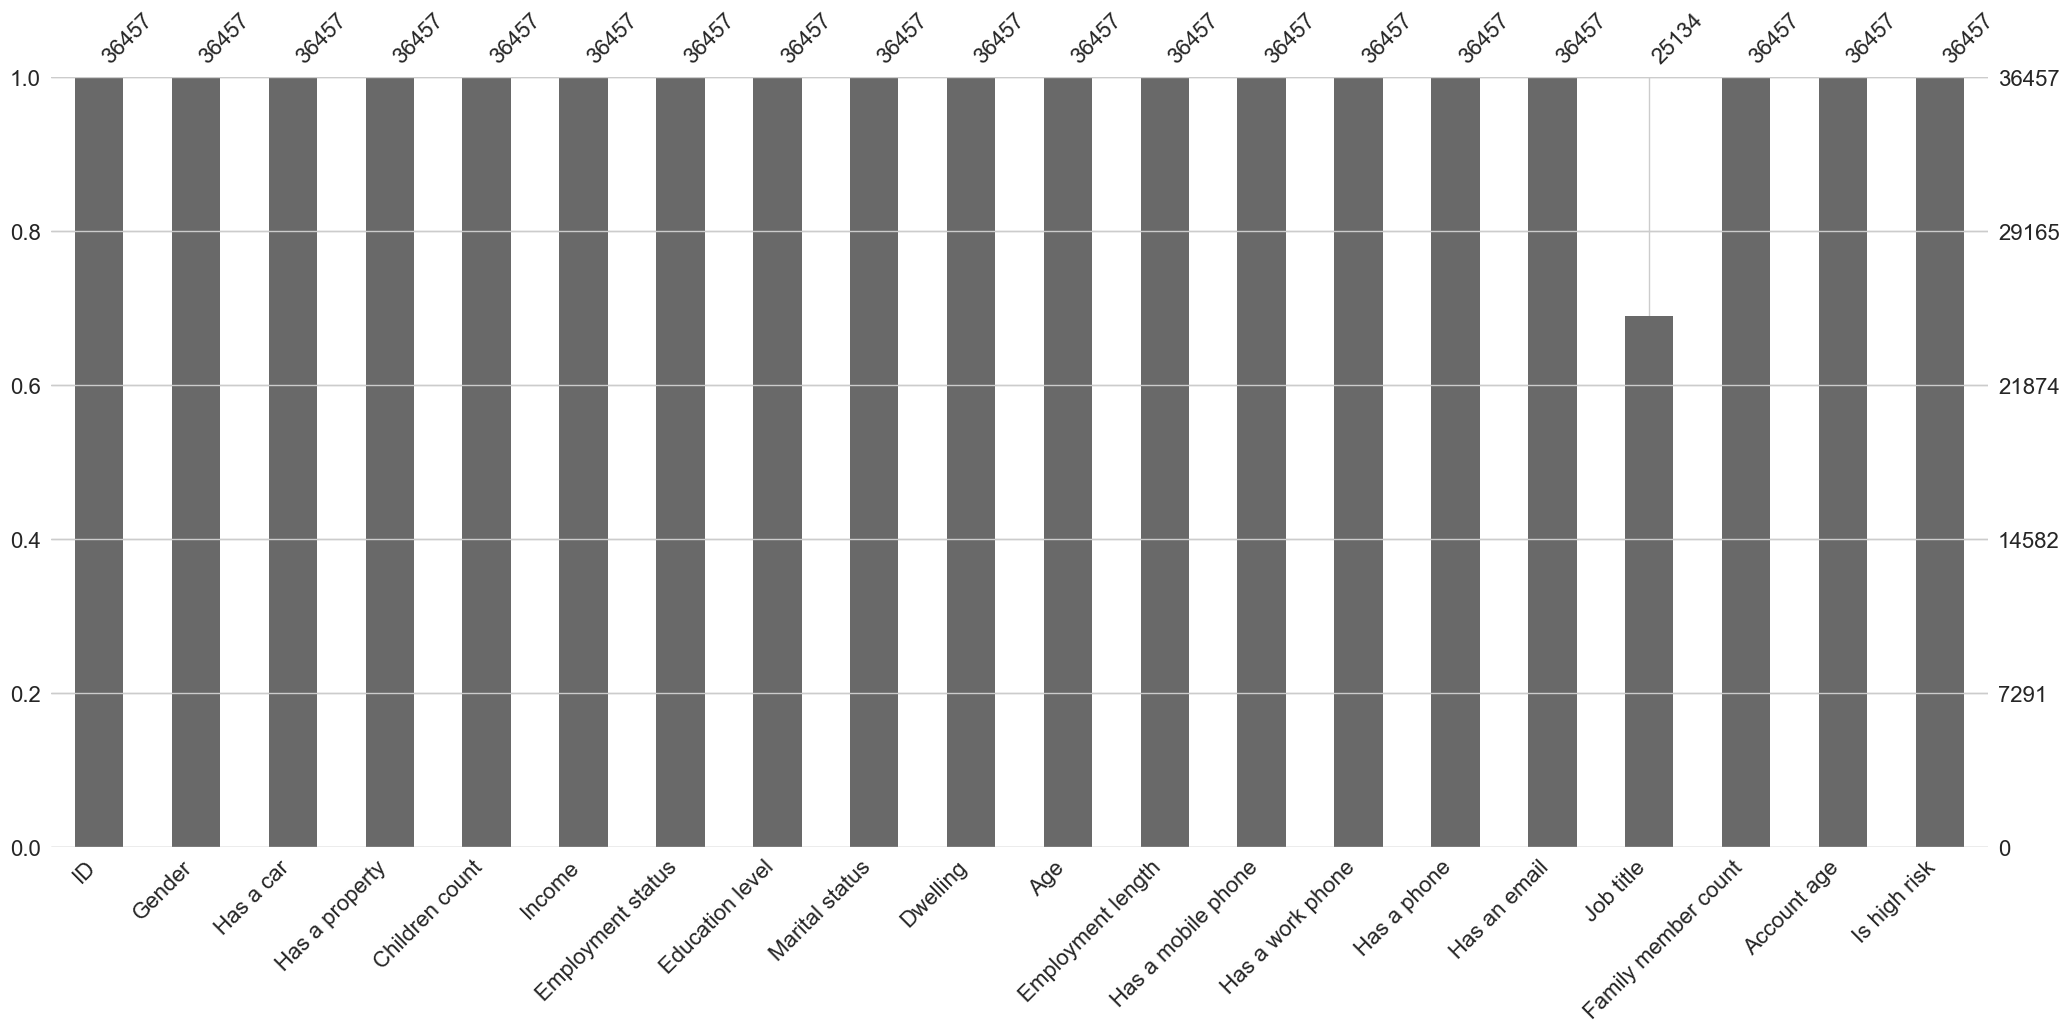

In [16]:
msno.bar(cc_dataset_end_to_end_dataset)
plt.show()

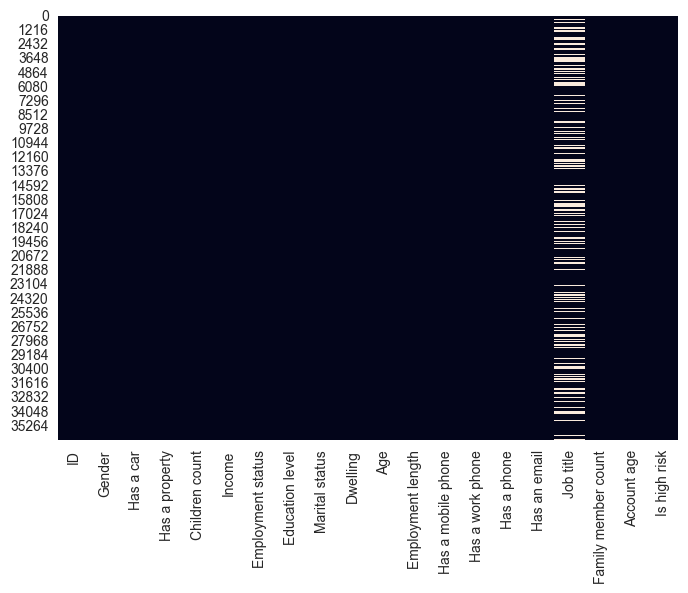

In [17]:
sns.heatmap(cc_dataset_end_to_end_dataset.isnull(), cbar=False)
plt.show()

## 2.3 Functions to explore each feature

In [18]:
#helper that will return the value count and frequency of each observation within a predictor
def metric_count_share_calc(df,feature):
    ftr_value_cnt = df[feature].value_counts()
    ftr_value_cnt_norm = df[feature].value_counts(normalize=True) * 100
    ftr_value_cnt_concat = pd.concat([ftr_value_cnt, ftr_value_cnt_norm], axis=1)
    ftr_value_cnt_concat.columns = ['Count', 'Frequency (%)']
    return ftr_value_cnt_concat

In [19]:
# helper to build display general information about the predictor
def build_summary_feature(df,feature):
    match feature:
        case 'Age':
            # change the predictor to be express in positive numbers days
            print('Description:\n{}'.format((np.abs(df[feature])/365.25).describe()))
            print('*'*50)
            print('Object type:{}'.format(df[feature].dtype))
        case 'Employment length':
            # select only the rows where the rows are negative to ignore whose who have retired or unemployed
            employment_len_no_ret = cc_train_clone['Employment length'][cc_train_clone['Employment length'] < 0]
            employment_len_no_ret_yrs = np.abs(employment_len_no_ret)/365.25
            print('Description:\n{}'.format((employment_len_no_ret_yrs).describe()))
            print('*'*50)
            print('Object type:{}'.format(employment_len_no_ret.dtype))
        case 'Account age':
            # change the account age to a positive number of months
            print('Description:\n{}'.format((np.abs(df[feature])).describe()))
            print('*'*50)
            print('Object type:{}'.format(df[feature].dtype))
        case _:
            print('Description:\n{}'.format(df[feature].describe()))
            print('*'*50)
            print('Object type:\n{}'.format(df[feature].dtype))
            print('*'*50)
            print(metric_count_share_calc(df,feature))

In [20]:
# helper to build a pie chart chart
donut_palette = sns.color_palette('Set1')
def make_donut_chart(df,feature):
    match feature:
        case 'Dwelling' | 'Education level':
            ratio_size = metric_count_share_calc(df, feature)
            ratio_size_len = len(ratio_size.index)
            ratio_list = []
            for i in range(ratio_size_len):
                ratio_list.append(ratio_size.iloc[i]['Frequency (%)'])
            fig_v2, ax_v2 = plt.subplots(figsize=(8,8))
            # %1.2f%% display decimals in the pie chart with 2 decimal places
            plt.pie(ratio_list,startangle=90, wedgeprops={'edgecolor': 'black'},colors=donut_palette)
            plt.title('Pie chart of {}'.format(feature))
            plt.legend(loc='best',labels=ratio_size.index)
            plt.axis('equal')
            return plt.show()
        case _:
            ratio_size = metric_count_share_calc(df, feature)
            ratio_size_len = len(ratio_size.index)
            ratio_list = []
            for i in range(ratio_size_len):
                ratio_list.append(ratio_size.iloc[i]['Frequency (%)'])
            fig_v2, ax_v2 = plt.subplots(figsize=(8,8))
            # %1.2f%% display decimals in the pie chart with 2 decimal places
            plt.pie(ratio_list, labels=ratio_size.index, autopct='%1.2f%%', startangle=90, wedgeprops={'edgecolor': 'black'}, colors=donut_palette)
            plt.title('Pie chart of {}'.format(feature))
            plt.legend(loc='best')
            plt.axis('equal')
            return plt.show()

In [21]:
def make_bar_chart(df, feature):
    ratio_df = metric_count_share_calc(df, feature).reset_index()
    ratio_df.columns = [feature, 'Count', 'Frequency (%)']

    match feature:
        case 'Marital status' | 'Dwelling' | 'Job title' | 'Employment status' | 'Education level':
            fig_v2, ax_v2 = plt.subplots(figsize=(6, 10))
            sns.barplot(
                data=ratio_df,
                x=feature,
                y='Count',
                hue=feature,
                palette='Set1',
                dodge=False,
                ax_v2=ax_v2
            )
            ax_v2.set_xticklabels(ax_v2.get_xticklabels(), rotation=45, ha='right')
            if ax_v2.legend_ is not None:
              ax_v2.legend_.remove()
            ax_v2.set_xlabel(feature)
            ax_v2.set_ylabel('Count')
            ax_v2.set_title(f'{feature} count')
            plt.show()

        case _:
            fig_v2, ax_v2 = plt.subplots(figsize=(6, 10))
            sns.barplot(
                data=ratio_df,
                x=feature,
                y='Count',
                hue=feature,
                palette='Set1',
                dodge=False,
                ax_v2=ax_v2
            )
            if ax_v2.legend_ is not None:
                ax_v2.legend_.remove()
            ax_v2.set_xlabel(feature)
            ax_v2.set_ylabel('Count')
            ax_v2.set_title(f'{feature} count')
            plt.show()


In [22]:
# helper to build a box chart
def make_box_chart(df,feature):
    match feature:
        case 'Age':
            fig_v2, ax_v2 = plt.subplots(figsize=(2,8))
            # change the predictor to be express in positive numbers days
            sns.boxplot(y=np.abs(df[feature])/365.25, color=sns.color_palette('Set1')[0])
            plt.title('{} distribution(Boxplot)'.format(feature))
            return plt.show()
        case 'Children count':
            fig_v2, ax_v2 = plt.subplots(figsize=(2,8))
            sns.boxplot(y=df[feature], color=sns.color_palette('Set1')[0])
            plt.title('{} distribution(Boxplot)'.format(feature))
            plt.yticks(np.arange(0,df[feature].max(),1))
            return plt.show()
        case 'Employment length':
            fig_v2, ax_v2 = plt.subplots(figsize=(2,8))
            employment_len_no_ret = cc_train_clone['Employment length'][cc_train_clone['Employment length'] < 0]
            # employement length in days is a negative number so we need to change it to positive and change it to days
            employment_len_no_ret_yrs = np.abs(employment_len_no_ret)/365.25
            sns.boxplot(y=employment_len_no_ret_yrs, color=sns.color_palette('Set1')[0])
            plt.title('{} distribution(Boxplot)'.format(feature))
            plt.yticks(np.arange(0,employment_len_no_ret_yrs.max(),2))
            return plt.show()
        case 'Income':
            fig_v2, ax_v2 = plt.subplots(figsize=(2,8))
            sns.boxplot(y=df[feature], color=sns.color_palette('Set1')[0])
            plt.title('{} distribution(Boxplot)'.format(feature))
            # suppress scientific notation
            ax_v2.get_yaxis().set_major_formatter(
                matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
            return plt.show()
        case 'Account age':
            fig_v2, ax_v2 = plt.subplots(figsize=(2,8))
            sns.boxplot(y=np.abs(df[feature]), color=sns.color_palette('Set1')[0])
            plt.title('{} distribution(Boxplot)'.format(feature))
            return plt.show()
        case _:
            fig_v2, ax_v2 = plt.subplots(figsize=(2,8))
            sns.boxplot(y=df[feature], color=sns.color_palette('Set1')[0])
            plt.title('{} distribution(Boxplot)'.format(feature))
            return plt.show()

In [49]:
# helper to build a histogram chart
def make_hist_chart(df,feature, the_bins=50):
    match feature:
        case 'Age':
            fig_v2, ax_v2 = plt.subplots(figsize=(18,10))
            # change the predictor to be express in positive numbers days
            sns.histplot(np.abs(df[feature])/365.25,bins=the_bins,kde=True)
            plt.title('{} distribution'.format(feature))
            return plt.show()
        case 'Income':
            fig_v2, ax_v2 = plt.subplots(figsize=(18,10))
            sns.histplot(df[feature],bins=the_bins,kde=True)
            # suppress scientific notation
            ax_v2.get_xaxis().set_major_formatter(
                matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
            plt.title('{} distribution'.format(feature))
            return plt.show()
        case 'Employment length':
            employment_len_no_ret = cc_train_clone['Employment length'][cc_train_clone['Employment length'] < 0]
            # change the predictor to be express in positive numbers days
            employment_len_no_ret_yrs = np.abs(employment_len_no_ret)/365.25
            fig_v2, ax_v2 = plt.subplots(figsize=(18,10))
            sns.histplot(employment_len_no_ret_yrs,bins=the_bins,kde=True)
            plt.title('{} distribution'.format(feature))
            return plt.show()
        case 'Account age':
            fig_v2, ax_v2 = plt.subplots(figsize=(18,10))
            sns.histplot(np.abs(df[feature]),bins=the_bins,kde=True)
            plt.title('{} distribution'.format(feature))
            return plt.show()
        case _:
            fig_v2, ax_v2 = plt.subplots(figsize=(18,10))
            sns.histplot(df[feature],bins=the_bins,kde=True)
            plt.title('{} distribution'.format(feature))
            return plt.show()

In [24]:
# High risk vs low risk applicants compared on a box chart
def low_high_risk_box_chart(df,feature):
    match feature:
        case 'Age':
            print(np.abs(df.groupby('Is high risk')[feature].mean()/365.25))
            fig_v2, ax_v2 = plt.subplots(figsize=(5,8))
            sns.boxplot(y=np.abs(df[feature])/365.25,x=df['Is high risk'], palette='Set1')
            plt.xticks(ticks=[0,1],labels=['no','yes'])
            plt.title('High risk individuals grouped by age')
            return plt.show()
        case 'Income':
            print(np.abs(df.groupby('Is high risk')[feature].mean()))
            fig_v2, ax_v2 = plt.subplots(figsize=(5,8))
            sns.boxplot(y=np.abs(df[feature]),x=df['Is high risk'], palette='Set1')
            plt.xticks(ticks=[0,1],labels=['no','yes'])
            # suppress scientific notation
            ax_v2.get_yaxis().set_major_formatter(
                matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
            plt.title('High risk individuals grouped by {}'.format(feature))
            return plt.show()
        case 'Employment length':
            #checking is an applicant is high risk or not (for those who have negative employment length aka the employed ones)
            employment_no_ret = cc_train_clone['Employment length'][cc_train_clone['Employment length'] <0]
            employment_no_ret_idx = employment_no_ret.index
            employment_len_no_ret_yrs = np.abs(employment_no_ret)/365.25
            employment_no_ret_df = cc_train_clone.iloc[employment_no_ret_idx][['Employment length','Is high risk']]
            employment_no_ret_is_high_risk = employment_no_ret_df.groupby('Is high risk')['Employment length'].mean()
            # compare the age of high risk individuals with the age of low risk individuals (those who are employed)
            print(np.abs(employment_no_ret_is_high_risk)/365.25)
            fig_v2, ax_v2 = plt.subplots(figsize=(5,8))
            sns.boxplot(y=employment_len_no_ret_yrs,x=df['Is high risk'], palette='Set1')
            plt.xticks(ticks=[0,1],labels=['no','yes'])
            plt.title('High vs low risk individuals grouped by {}'.format(feature))
            return plt.show()
        case _:
            print(np.abs(df.groupby('Is high risk')[feature].mean()))
            fig_v2, ax_v2 = plt.subplots(figsize=(5,8))
            sns.boxplot(y=np.abs(df[feature]),x=df['Is high risk'], palette='Set1')
            plt.xticks(ticks=[0,1],labels=['no','yes'])
            plt.title('High risk individuals grouped by {}'.format(feature))
            return plt.show()

In [25]:
# High risk vs low risk applicants compared on a bar chart
def low_high_risk_bar_chart(df,feature):
    is_high_risk_grp = df.groupby(feature)['Is high risk'].sum()
    is_high_risk_grp_srt = is_high_risk_grp.sort_values(ascending=False)
    print(dict(is_high_risk_grp_srt))
    fig_v2, ax_v2 = plt.subplots(figsize=(6,10))
    sns.barplot(x=is_high_risk_grp_srt.index,y=is_high_risk_grp_srt.values, palette='Set1', ax_v2=ax_v2)
    ax_v2.set_xticklabels(labels=is_high_risk_grp_srt.index,rotation=45, ha='right')
    plt.ylabel('Count')
    plt.title('High risk applicants count grouped by {}'.format(feature))
    return plt.show()

## 2.4 Feature Analysis

### 2.4.1 Gender

In [66]:
build_summary_feature(cc_train_clone,'Gender')

Description:
count     29165
unique        2
top           F
freq      19549
Name: Gender, dtype: object
**************************************************
Object type:
object
**************************************************
        Count  Frequency (%)
Gender                      
F       19549          67.03
M        9616          32.97


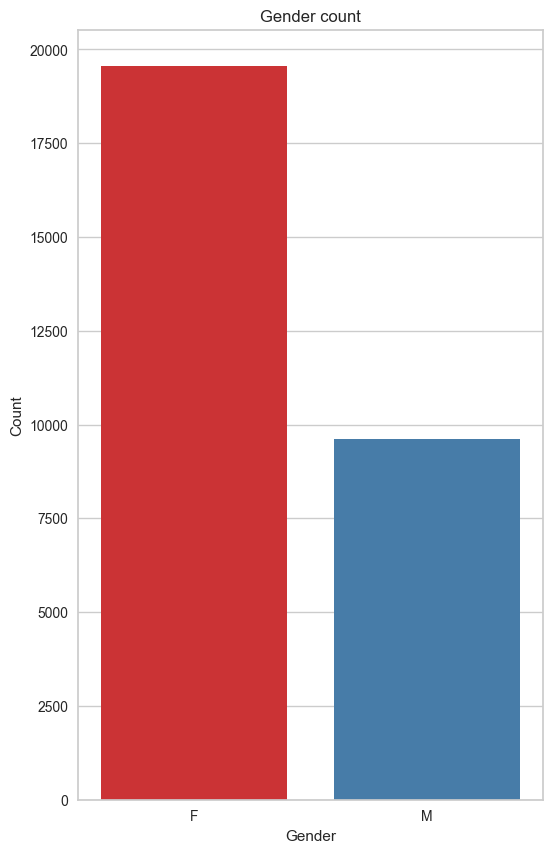

In [67]:
make_bar_chart(cc_train_clone,'Gender')

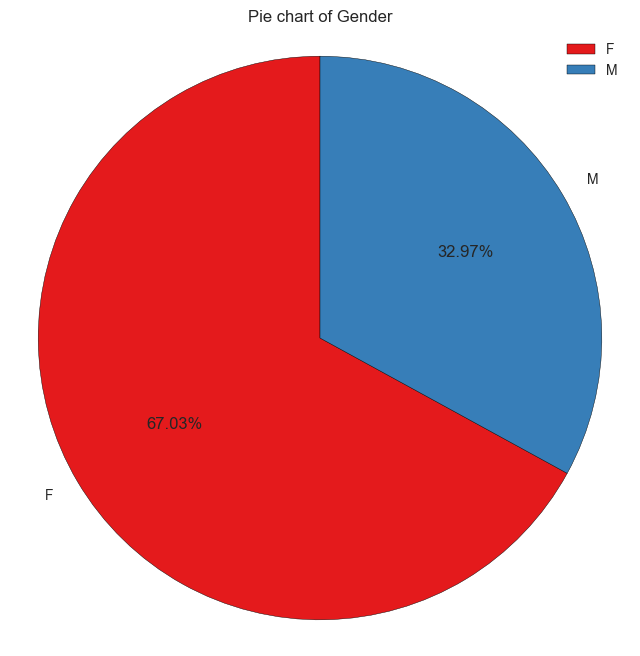

In [68]:
make_donut_chart(cc_train_clone,'Gender')

### 2.4.2 Age

In [69]:
build_summary_feature(cc_train_clone,'Age')

Description:
count   29165.00
mean       43.75
std        11.51
min        21.10
25%        34.15
50%        42.61
75%        53.23
max        68.86
Name: Age, dtype: float64
**************************************************
Object type:int64


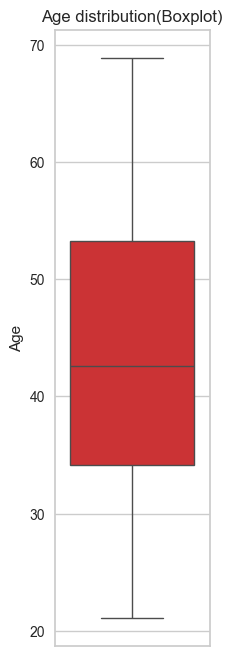

In [70]:
make_box_chart(cc_train_clone,'Age')

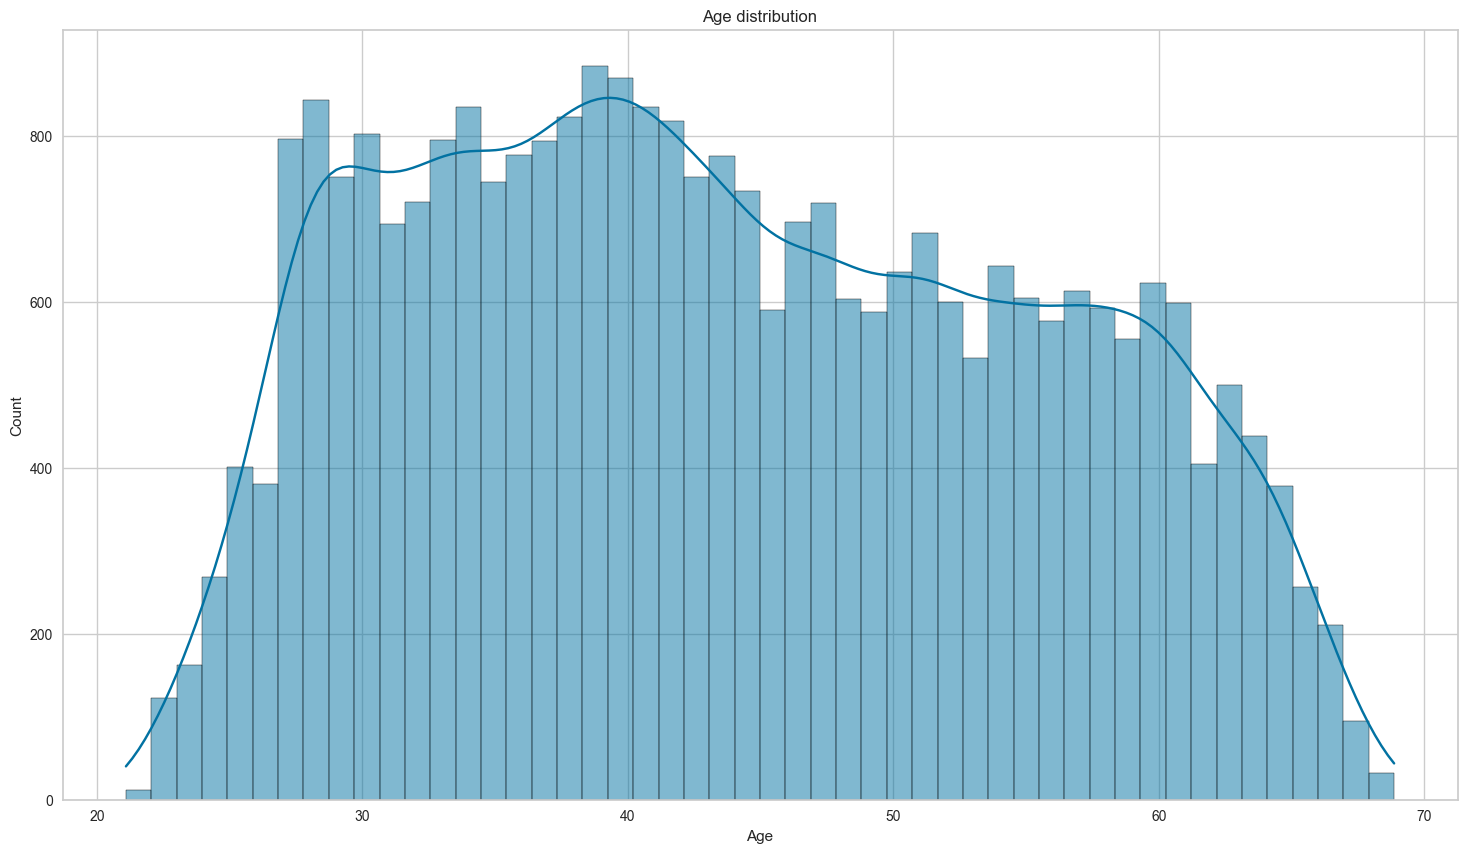

In [71]:
make_hist_chart(cc_train_clone,'Age')

Is high risk
0   43.75
1   43.54
Name: Age, dtype: float64


C:\Users\karan\AppData\Local\Temp\ipykernel_45188\1270967700.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=np.abs(df[feature])/365.25,x=df['Is high risk'], palette='Set1')


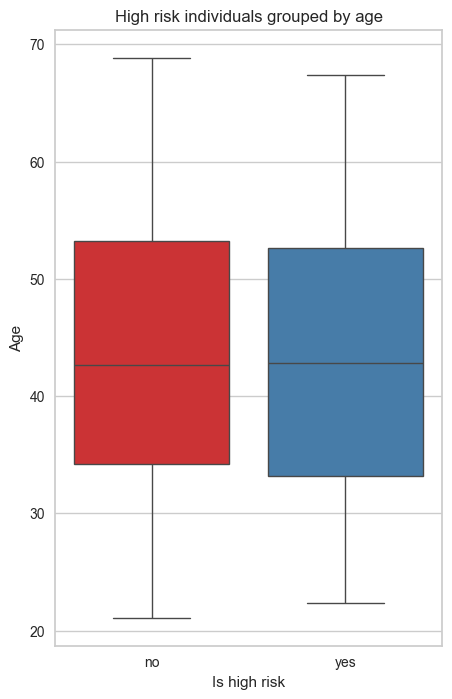

In [72]:
low_high_risk_box_chart(cc_train_clone,'Age')

Interpretation:

- The youngest applicant is 21 years old while the oldest is 68 years old. with the average of 43.7 and median of 42.6(outliers insensitive)
- Age feature is not normally distributed, it is slightly positively skew
- There is no difference between the average age of high and low risk applicants

### 2.4.3 Marital Status

In [73]:
build_summary_feature(cc_train_clone,'Marital status')

Description:
count       29165
unique          5
top       Married
freq        20044
Name: Marital status, dtype: object
**************************************************
Object type:
object
**************************************************
                      Count  Frequency (%)
Marital status                            
Married               20044          68.73
Single / not married   3864          13.25
Civil marriage         2312           7.93
Separated              1712           5.87
Widow                  1233           4.23


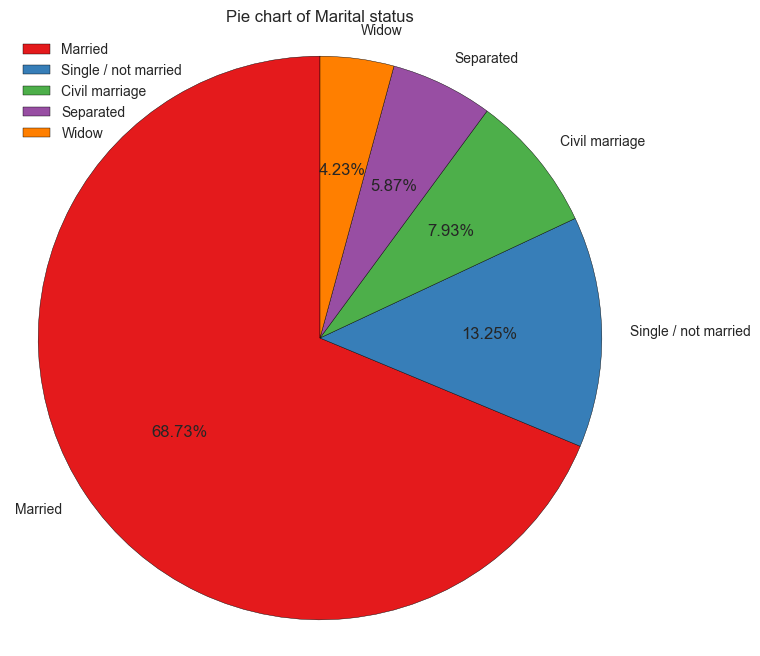

In [74]:
make_donut_chart(cc_train_clone,'Marital status')

C:\Users\karan\AppData\Local\Temp\ipykernel_45188\1500166791.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


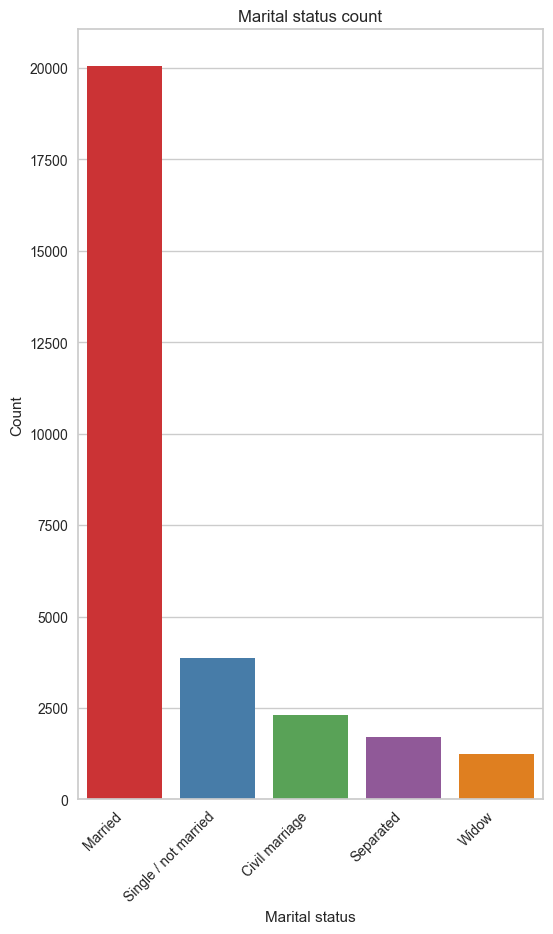

In [75]:
make_bar_chart(cc_train_clone,'Marital status')

{'Married': 320, 'Single / not married': 87, 'Civil marriage': 34, 'Widow': 34, 'Separated': 24}


C:\Users\karan\AppData\Local\Temp\ipykernel_45188\2271037549.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=is_high_risk_grp_srt.index,y=is_high_risk_grp_srt.values, palette='Set1', ax=ax)
C:\Users\karan\AppData\Local\Temp\ipykernel_45188\2271037549.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels=is_high_risk_grp_srt.index,rotation=45, ha='right')


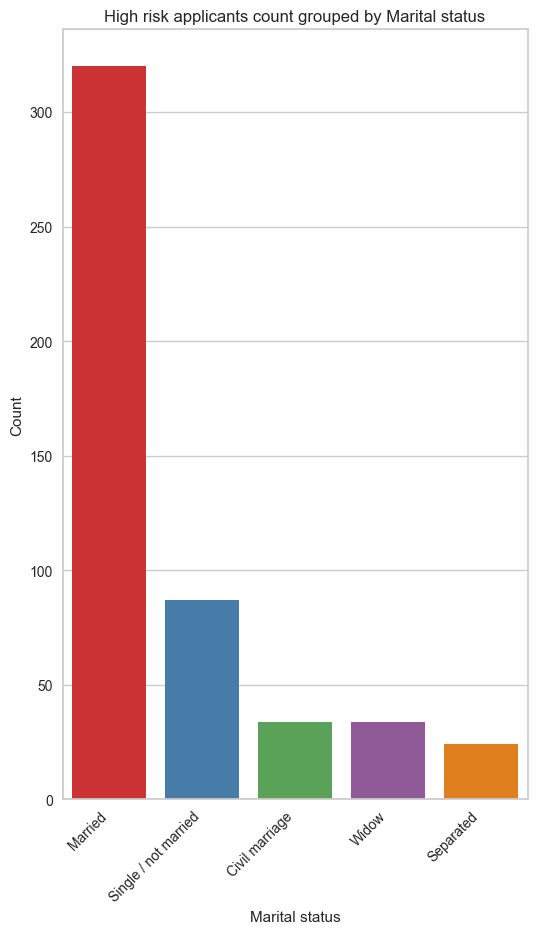

In [76]:
low_high_risk_bar_chart(cc_train_clone,'Marital status')

Interpretation:

- Most applicants are married
- Even though we have a higher number of applicants who are separated than those who are widow, it seems like widow applicants are high risk than those who are separated.

### 2.4.4 Family Member Count

In [77]:
build_summary_feature(cc_train_clone,'Family member count')

Description:
count   29165.00
mean        2.20
std         0.91
min         1.00
25%         2.00
50%         2.00
75%         3.00
max        20.00
Name: Family member count, dtype: float64
**************************************************
Object type:
float64
**************************************************
                     Count  Frequency (%)
Family member count                      
2.00                 15552          53.32
1.00                  5613          19.25
3.00                  5121          17.56
4.00                  2503           8.58
5.00                   309           1.06
6.00                    48           0.16
7.00                    14           0.05
9.00                     2           0.01
15.00                    2           0.01
20.00                    1           0.00


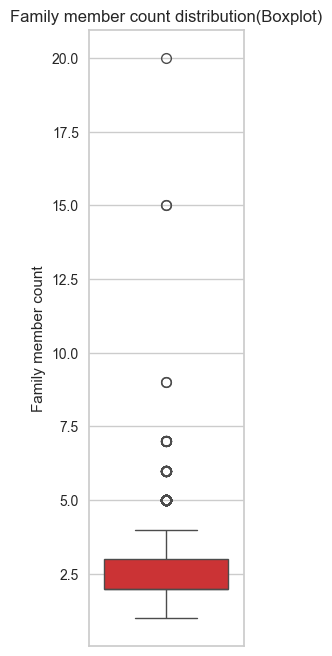

In [78]:
make_box_chart(cc_train_clone,'Family member count')

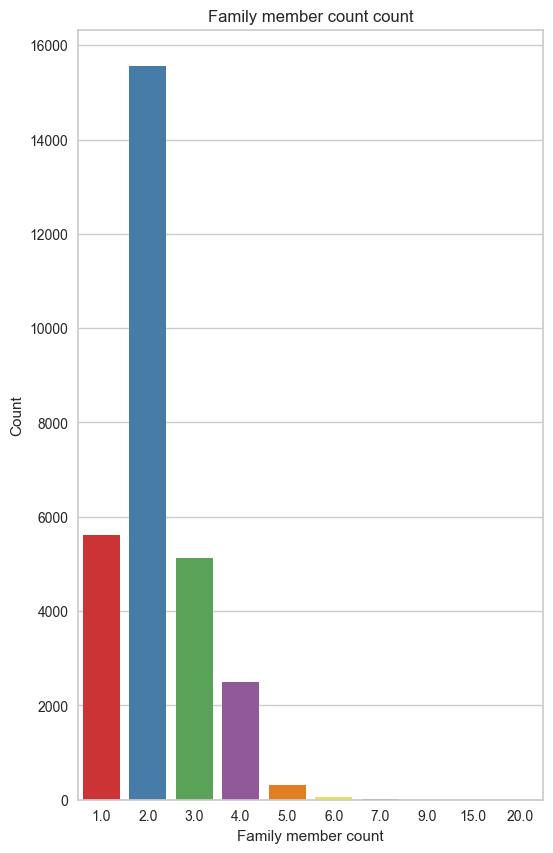

In [79]:
make_bar_chart(cc_train_clone,'Family member count')

Interpretation:

- Most applicants are two in their household, this is also confirmed with the fact that most don’t have a child (more on this in a bit)
- We also have 6 outliers, 2 of them are extreme with 20 and 15 members in their household

### 2.4.5 Children Count

In [80]:
build_summary_feature(cc_train_clone,'Children count')

Description:
count   29165.00
mean        0.43
std         0.74
min         0.00
25%         0.00
50%         0.00
75%         1.00
max        19.00
Name: Children count, dtype: float64
**************************************************
Object type:
int64
**************************************************
                Count  Frequency (%)
Children count                      
0               20143          69.07
1                6003          20.58
2                2624           9.00
3                 323           1.11
4                  52           0.18
5                  15           0.05
7                   2           0.01
14                  2           0.01
19                  1           0.00


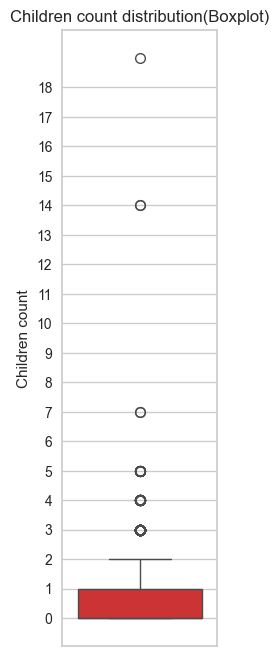

In [81]:
make_box_chart(cc_train_clone,'Children count')

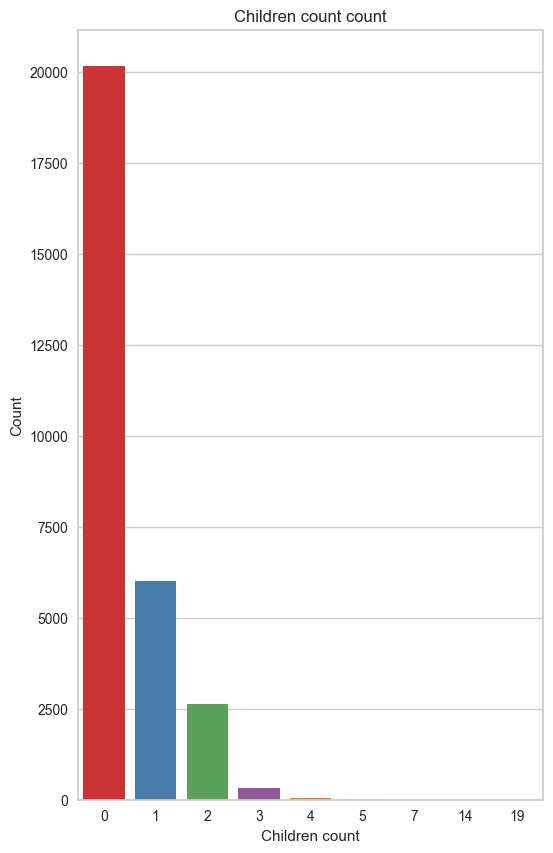

In [82]:
make_bar_chart(cc_train_clone,'Children count')

Interpretation:

- As previously discussed most applicant don’t have a child
- Also here we have 6 outliers, probably the same from the family member count

### 2.4.6 Dwelling Type

In [83]:
build_summary_feature(cc_train_clone,'Dwelling')

Description:
count                 29165
unique                    6
top       House / apartment
freq                  26059
Name: Dwelling, dtype: object
**************************************************
Object type:
object
**************************************************
                     Count  Frequency (%)
Dwelling                                 
House / apartment    26059          89.35
With parents          1406           4.82
Municipal apartment    912           3.13
Rented apartment       453           1.55
Office apartment       208           0.71
Co-op apartment        127           0.44


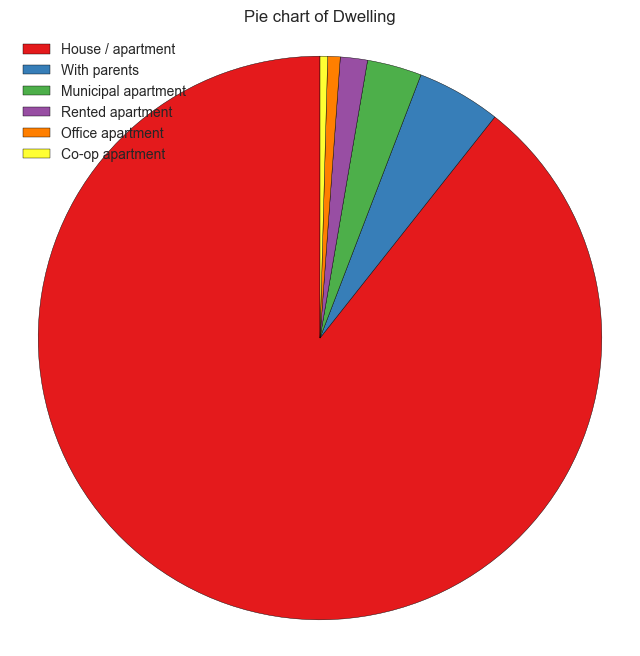

In [84]:
make_donut_chart(cc_train_clone,'Dwelling')

C:\Users\karan\AppData\Local\Temp\ipykernel_45188\1500166791.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


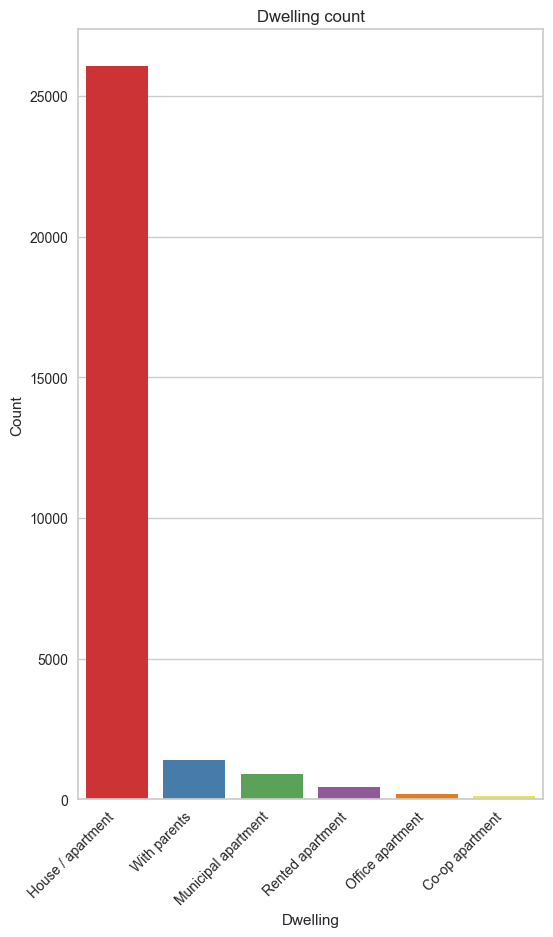

In [85]:
make_bar_chart(cc_train_clone,'Dwelling')


Interpretation:
- Almost every applicants live in house or apartment

### 2.4.7 Income

In [86]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
build_summary_feature(cc_train_clone,'Income')

Description:
count     29165.00
mean     186890.39
std      101409.64
min       27000.00
25%      121500.00
50%      157500.00
75%      225000.00
max     1575000.00
Name: Income, dtype: float64
**************************************************
Object type:
float64
**************************************************
           Count  Frequency (%)
Income                         
135000.00   3468          11.89
180000.00   2487           8.53
157500.00   2469           8.47
225000.00   2373           8.14
112500.00   2359           8.09
...          ...            ...
89550.00       1           0.00
265581.00      1           0.00
61875.00       1           0.00
234135.00      1           0.00
82350.00       1           0.00

[259 rows x 2 columns]


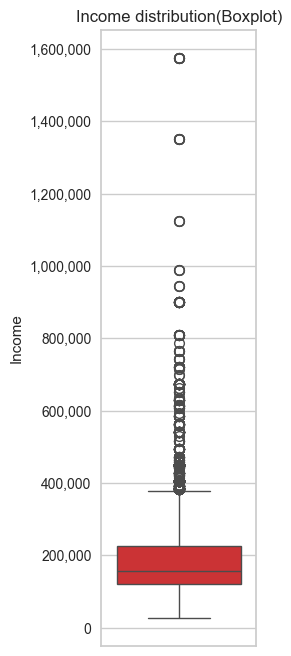

In [91]:
make_box_chart(cc_train_clone,'Income')

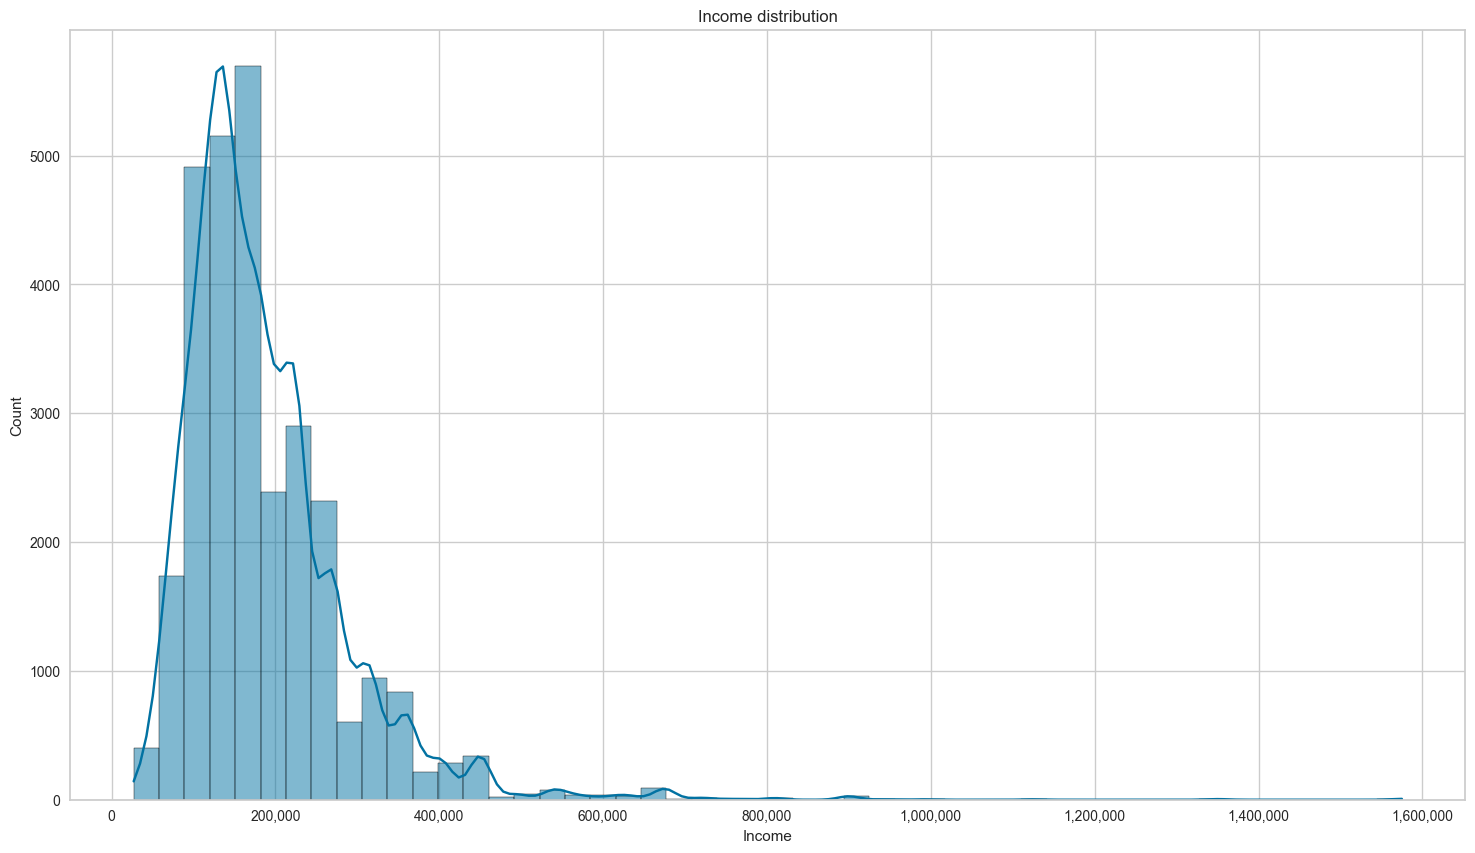

In [92]:
make_hist_chart(cc_train_clone,'Income')

Is high risk
0   186913.94
1   185537.26
Name: Income, dtype: float64


C:\Users\karan\AppData\Local\Temp\ipykernel_45188\1270967700.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=np.abs(df[feature]),x=df['Is high risk'], palette='Set1')


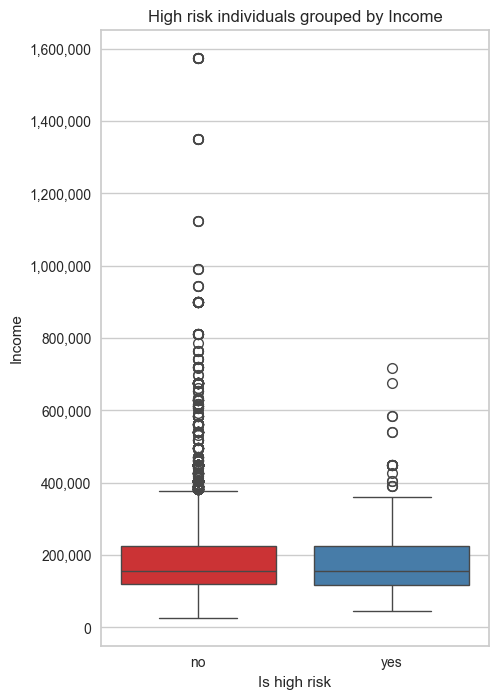

In [93]:
low_high_risk_box_chart(cc_train_clone,'Income')

Interpretation:

- The average income is 186890 but this amount accounts for outliers. If we ignore the outlier most people make 157500
- We have 3 applicants who makes more than 1000000
- This feature is positively skewed
- High risk and low risk applicants have roughly similar income

### 2.4.8 Job Title

In [94]:
build_summary_feature(cc_train_clone,'Job title')

Description:
count        20138
unique          18
top       Laborers
freq          5004
Name: Job title, dtype: object
**************************************************
Object type:
object
**************************************************
                       Count  Frequency (%)
Job title                                  
Laborers                5004          24.85
Core staff              2866          14.23
Sales staff             2773          13.77
Managers                2422          12.03
Drivers                 1722           8.55
High skill tech staff   1133           5.63
Accountants              998           4.96
Medicine staff           956           4.75
Cooking staff            521           2.59
Security staff           464           2.30
Cleaning staff           425           2.11
Private service staff    287           1.43
Low-skill Laborers       138           0.69
Waiters/barmen staff     127           0.63
Secretaries              122           0.61
HR staff  

In [95]:
job_title_nan_count_v2 = cc_train_clone['Job title'].isna().sum()
print(job_title_nan_count_v2)

9027


In [96]:
rows_total_count_v2 = cc_train_clone.shape[0]
print('The percentage of missing rows is {:.2f} %'.format(job_title_nan_count_v2 * 100 / rows_total_count_v2))

The percentage of missing rows is 30.95 %


C:\Users\karan\AppData\Local\Temp\ipykernel_45188\1500166791.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


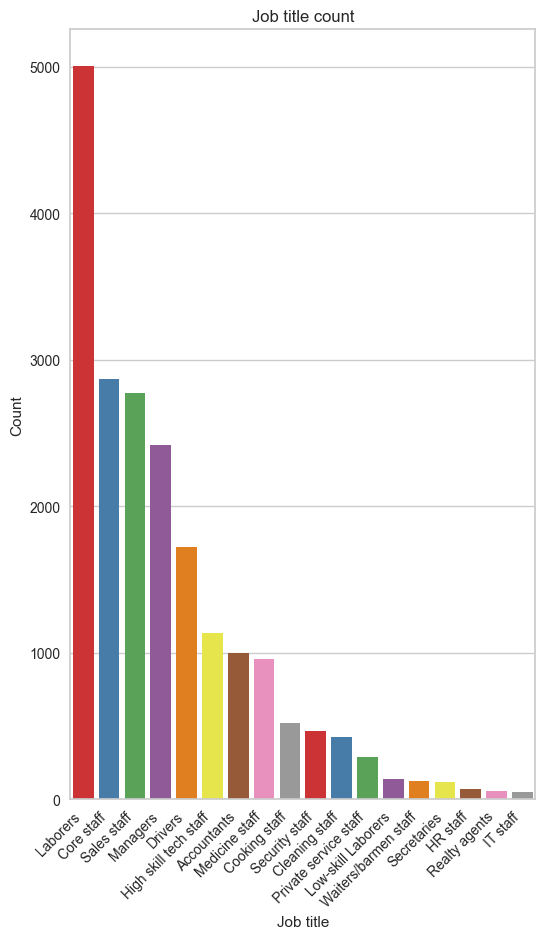

In [97]:
make_bar_chart(cc_train_clone,'Job title')

Interpretation:

- The most prolific Job title is laborers by far
- We have 30.95% if missing data

### 2.4.9 Employment Status

In [98]:
build_summary_feature(cc_train_clone,'Employment status')

Description:
count       29165
unique          5
top       Working
freq        15056
Name: Employment status, dtype: object
**************************************************
Object type:
object
**************************************************
                      Count  Frequency (%)
Employment status                         
Working               15056          51.62
Commercial associate   6801          23.32
Pensioner              4920          16.87
State servant          2381           8.16
Student                   7           0.02


C:\Users\karan\AppData\Local\Temp\ipykernel_45188\1500166791.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


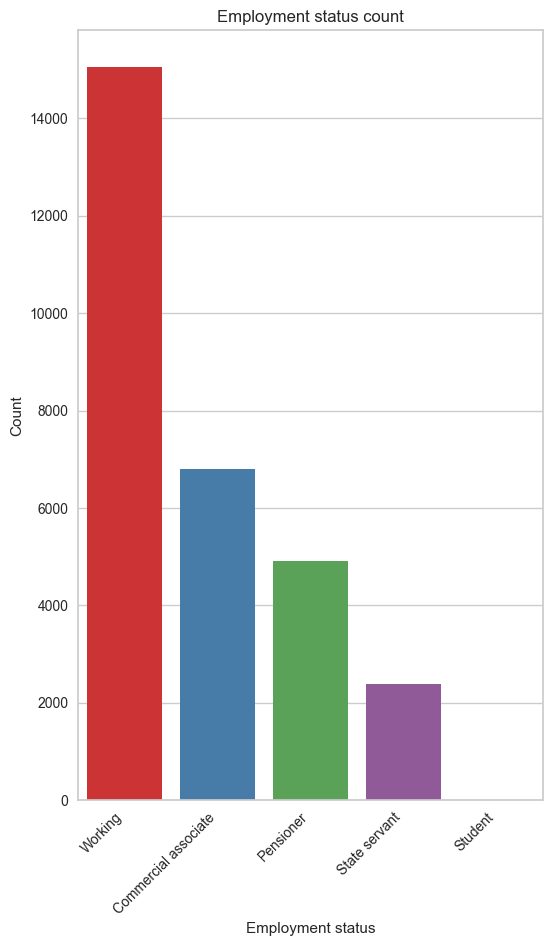

In [99]:
make_bar_chart(cc_train_clone,'Employment status')

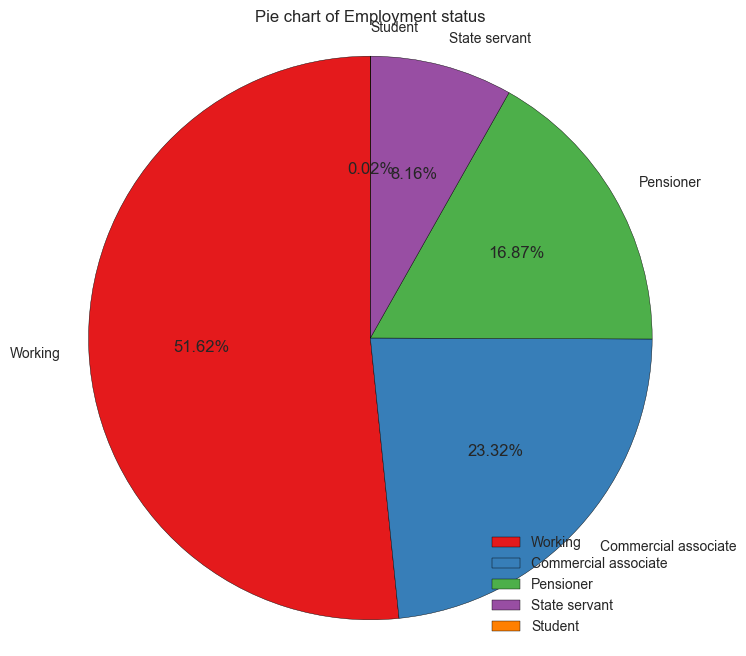

In [100]:
make_donut_chart(cc_train_clone,'Employment status')

Interpretation:

- Most applicants are employed

### 2.4.10 Education Level

In [101]:
build_summary_feature(cc_train_clone,'Education level')

Description:
count                             29165
unique                                5
top       Secondary / secondary special
freq                              19803
Name: Education level, dtype: object
**************************************************
Object type:
object
**************************************************
                               Count  Frequency (%)
Education level                                    
Secondary / secondary special  19803          67.90
Higher education                7910          27.12
Incomplete higher               1129           3.87
Lower secondary                  298           1.02
Academic degree                   25           0.09


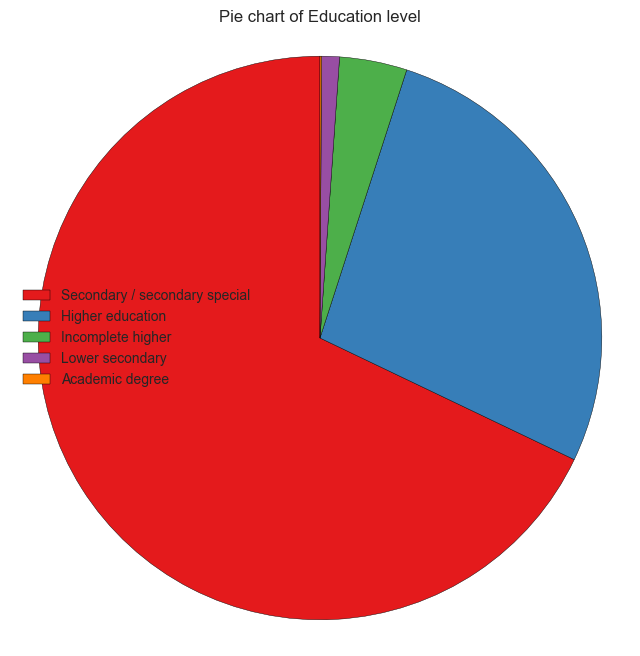

In [102]:
make_donut_chart(cc_train_clone,'Education level')

C:\Users\karan\AppData\Local\Temp\ipykernel_45188\1500166791.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


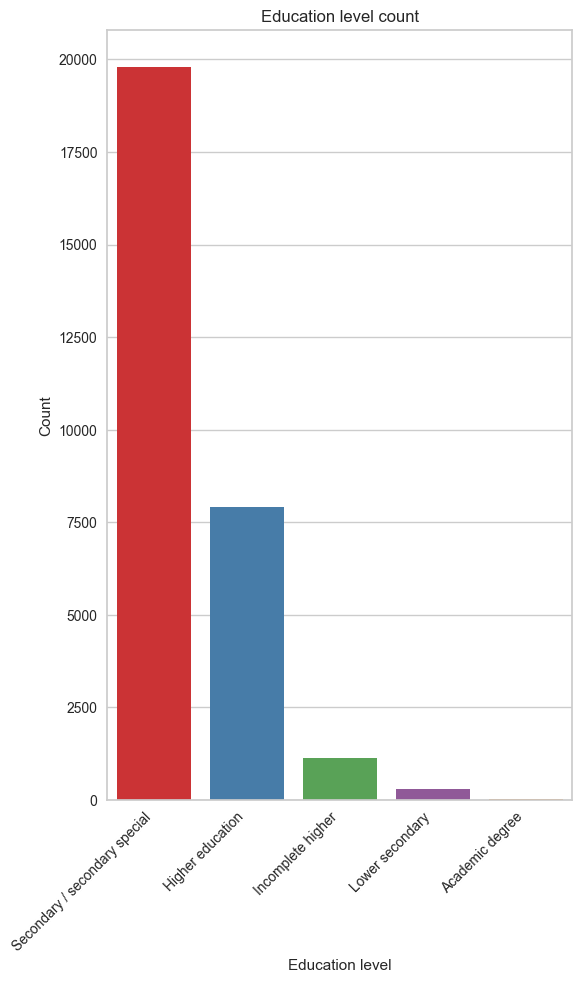

In [103]:
make_bar_chart(cc_train_clone,'Education level')

Interpretation:

- The majority of applicants have completed their secondary degree, ¼ completed their higher education

### 2.4.11 Employement Length

In [104]:
build_summary_feature(cc_train_clone,'Employment length')

Description:
count   24257.00
mean        7.26
std         6.46
min         0.05
25%         2.68
50%         5.45
75%         9.60
max        43.02
Name: Employment length, dtype: float64
**************************************************
Object type:int64


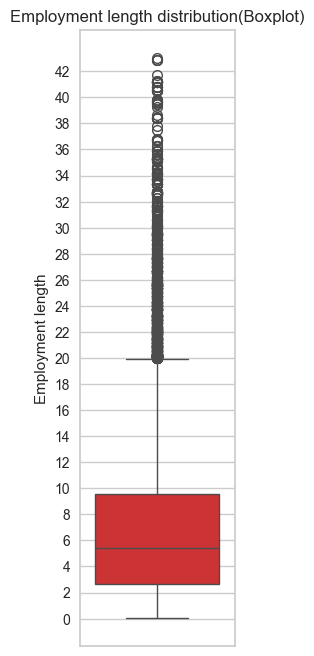

In [105]:
make_box_chart(cc_train_clone,'Employment length')

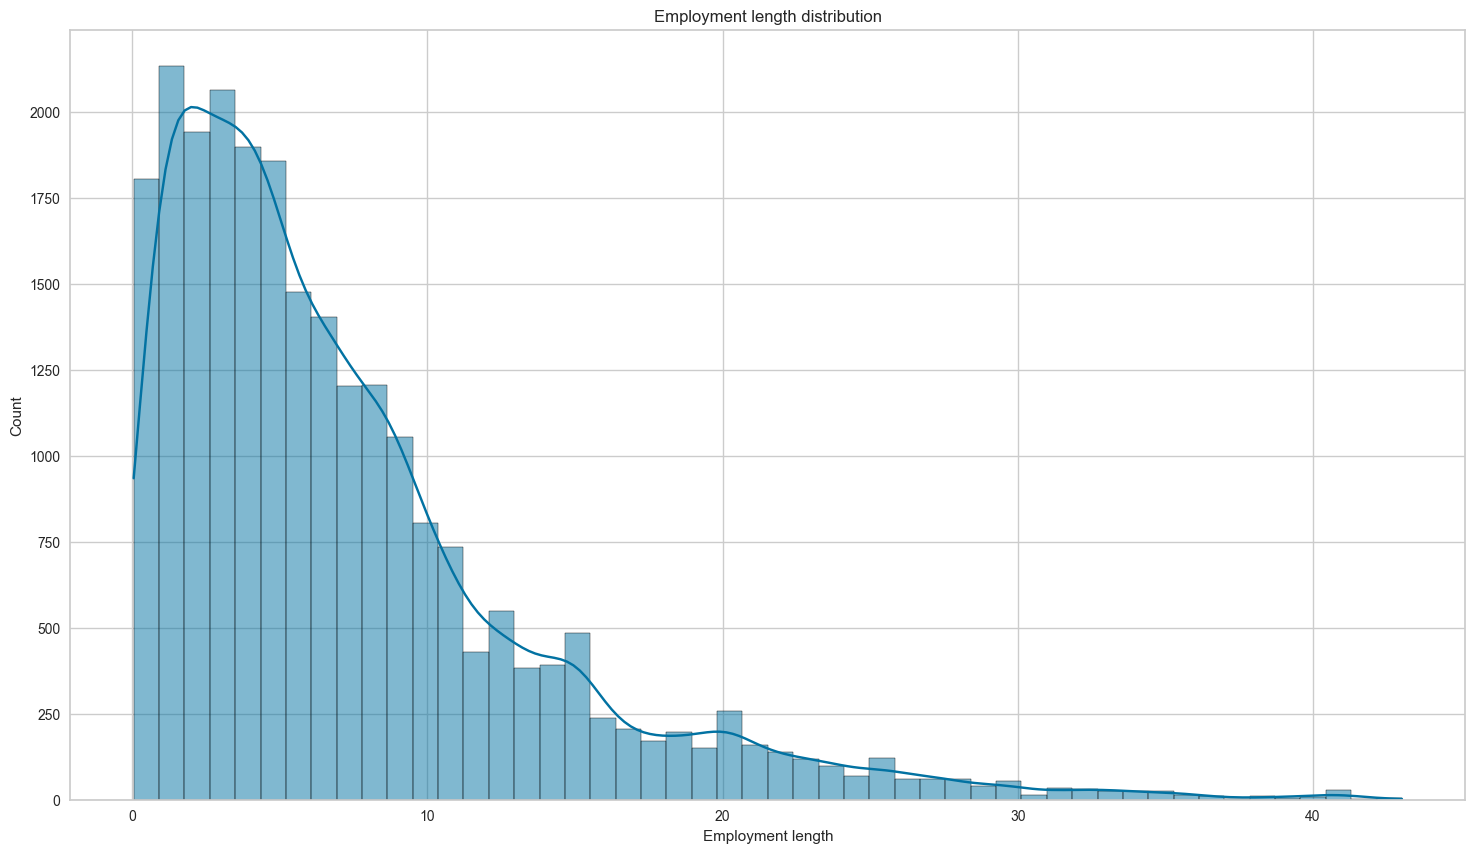

In [106]:
make_hist_chart(cc_train_clone,'Employment length')

Is high risk
0   7.29
1   5.75
Name: Employment length, dtype: float64


C:\Users\karan\AppData\Local\Temp\ipykernel_45188\1270967700.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=employment_len_no_ret_yrs,x=df['Is high risk'], palette='Set1')


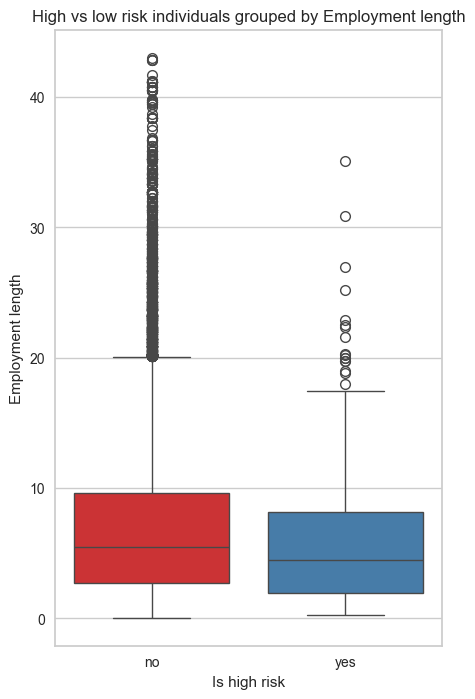

In [107]:
# distribution of employment length for high vs low risk applicants
# Here 0 means No and 1 means Yes
low_high_risk_box_chart(cc_train_clone,'Employment length')

Interpretation:

- Most of applicant have been working for 5 to 7 years on average
- We have quite a number of outliers who have been working for more than 20 years+
- The employment length is positively skewed
- Those who are high risk have a low employment length of 5 versus 7 years for the low risk

### 2.4.12 Has a Car

In [108]:
build_summary_feature(cc_train_clone,'Has a car')

Description:
count     29165
unique        2
top           N
freq      18128
Name: Has a car, dtype: object
**************************************************
Object type:
object
**************************************************
           Count  Frequency (%)
Has a car                      
N          18128          62.16
Y          11037          37.84


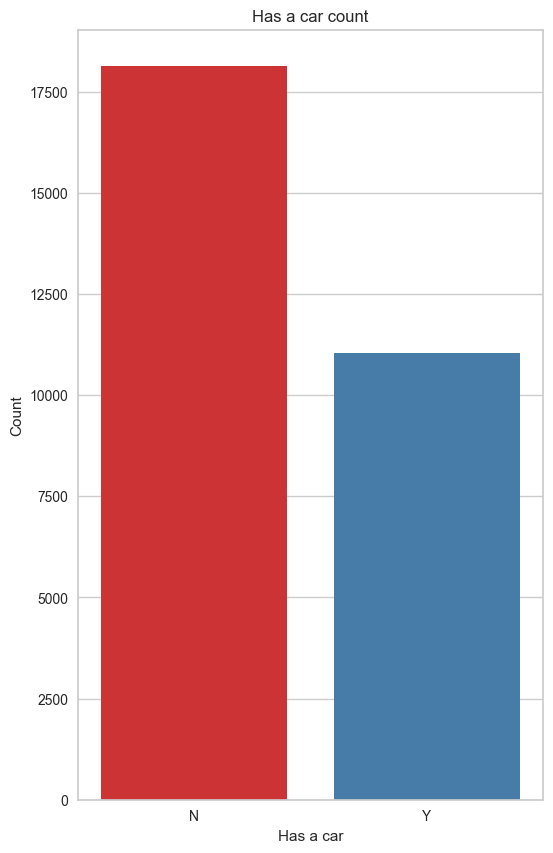

In [109]:
make_bar_chart(cc_train_clone,'Has a car')

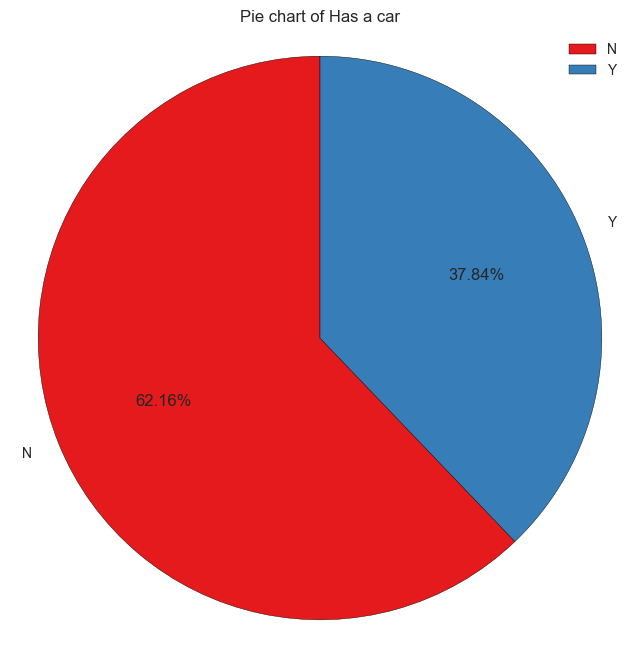

In [110]:
make_donut_chart(cc_train_clone,'Has a car')

Interpretation:

- Most applicant don’t own a car

### 2.4.13 Has a property

In [111]:
build_summary_feature(cc_train_clone,'Has a property')

Description:
count     29165
unique        2
top           Y
freq      19557
Name: Has a property, dtype: object
**************************************************
Object type:
object
**************************************************
                Count  Frequency (%)
Has a property                      
Y               19557          67.06
N                9608          32.94


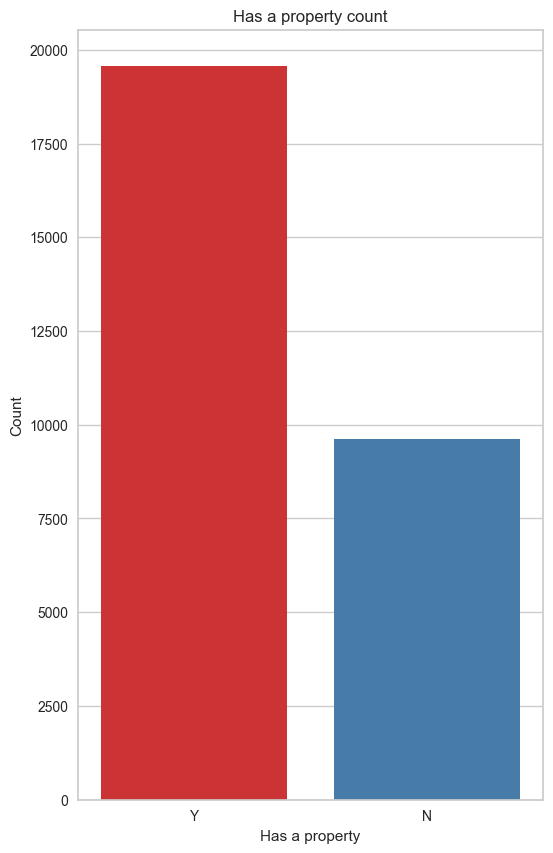

In [112]:
make_bar_chart(cc_train_clone,'Has a property')

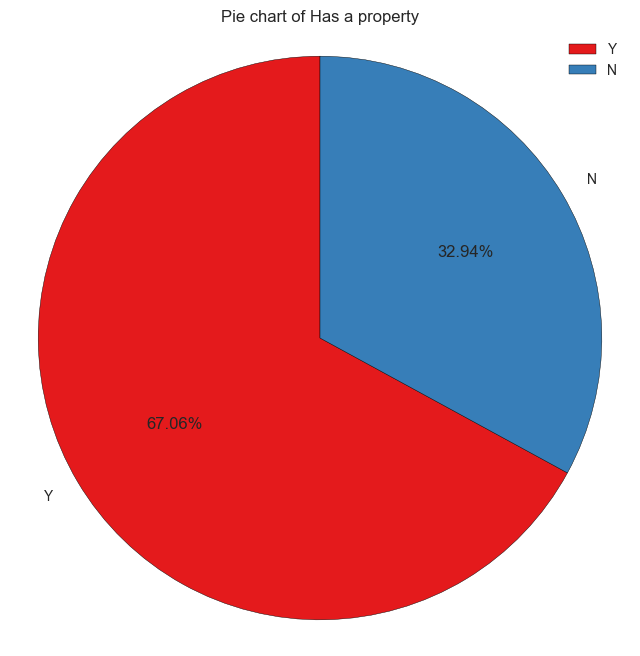

In [113]:
make_donut_chart(cc_train_clone,'Has a property')

Interpretation:

- Most applicants own a property

### 2.4.14 Has a Work Phone

In [114]:
build_summary_feature(cc_train_clone,'Has a work phone')

Description:
count   29165.00
mean        0.22
std         0.42
min         0.00
25%         0.00
50%         0.00
75%         0.00
max         1.00
Name: Has a work phone, dtype: float64
**************************************************
Object type:
int64
**************************************************
                  Count  Frequency (%)
Has a work phone                      
0                 22623          77.57
1                  6542          22.43


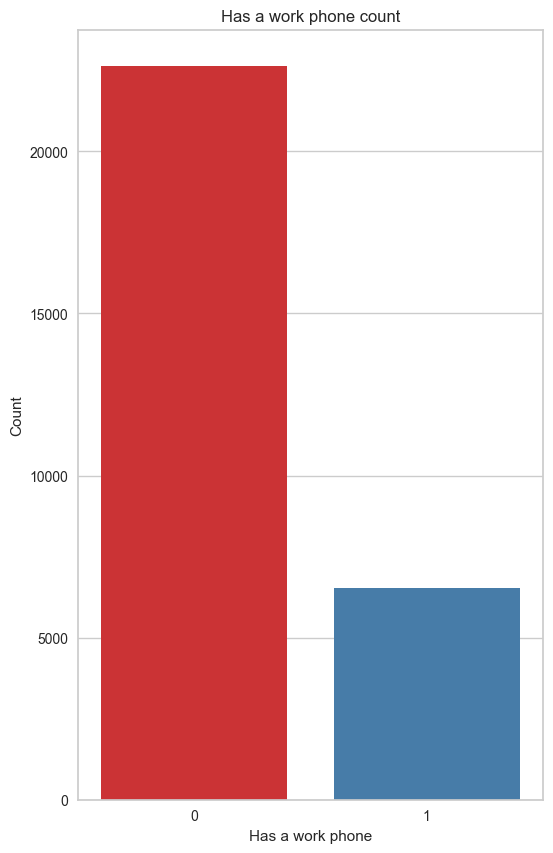

In [115]:
make_bar_chart(cc_train_clone,'Has a work phone')

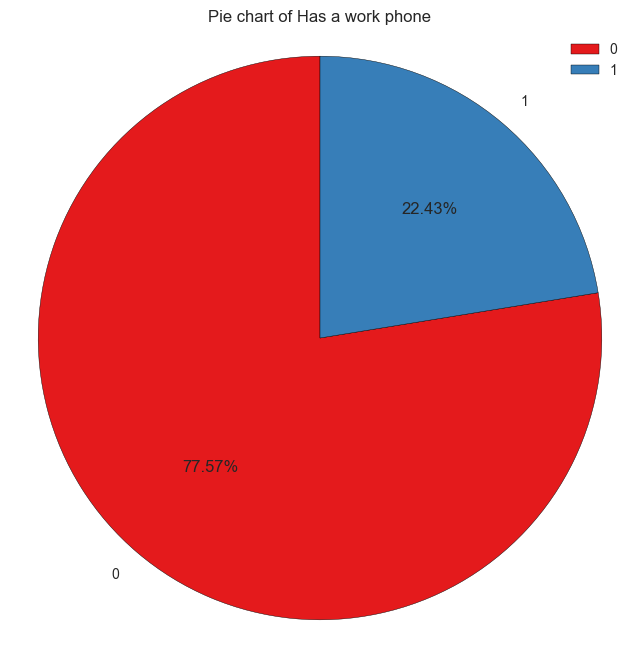

In [116]:
make_donut_chart(cc_train_clone,'Has a work phone')

Interpretation:

- More than ¾ of applicants don’t have a work phone
- Note: Here 0 is no and 1 is yes

### 2.4.15 Has a mobile phone

In [117]:
build_summary_feature(cc_train_clone,'Has a mobile phone')

Description:
count   29165.00
mean        1.00
std         0.00
min         1.00
25%         1.00
50%         1.00
75%         1.00
max         1.00
Name: Has a mobile phone, dtype: float64
**************************************************
Object type:
int64
**************************************************
                    Count  Frequency (%)
Has a mobile phone                      
1                   29165         100.00


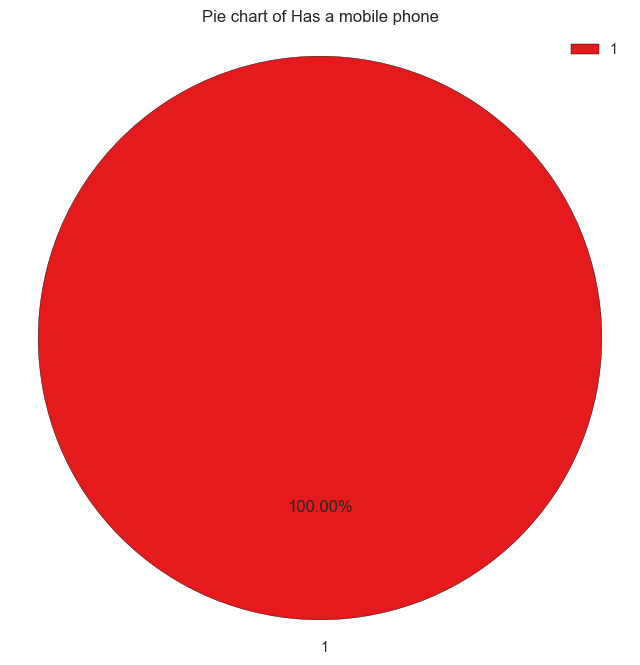

In [118]:
make_donut_chart(cc_train_clone,'Has a mobile phone')

Interpretation:

- All the applicants without exception have a mobile phone
- Note: Here 0 is no and 1 is yes

### 2.4.16 Has a phone

In [119]:
build_summary_feature(cc_train_clone,'Has a phone')

Description:
count   29165.00
mean        0.29
std         0.46
min         0.00
25%         0.00
50%         0.00
75%         1.00
max         1.00
Name: Has a phone, dtype: float64
**************************************************
Object type:
int64
**************************************************
             Count  Frequency (%)
Has a phone                      
0            20562          70.50
1             8603          29.50


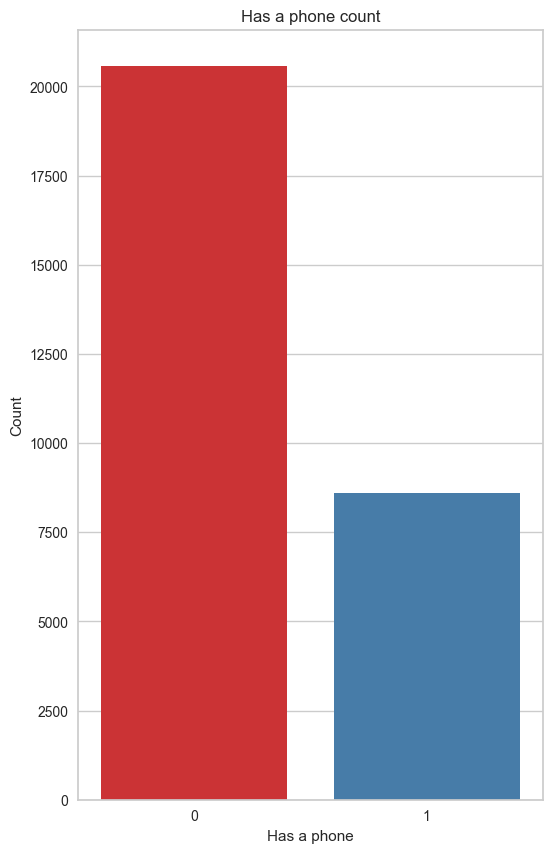

In [120]:
make_bar_chart(cc_train_clone,'Has a phone')

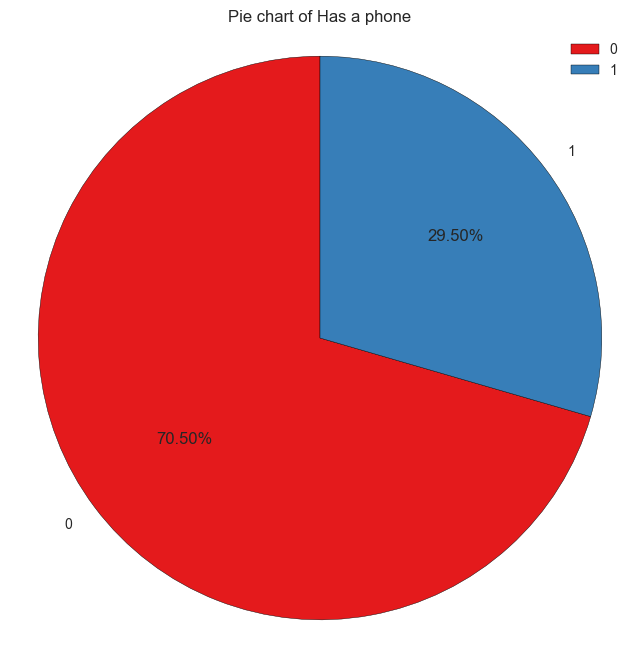

In [121]:
make_donut_chart(cc_train_clone,'Has a phone')

Interpretation:

- Most applicants don’t have a phone (probably a home phone)
- Note: Here 0 is no and 1 is yes

### 2.4.17 Has an email

In [122]:
build_summary_feature(cc_train_clone,'Has an email')

Description:
count   29165.00
mean        0.09
std         0.29
min         0.00
25%         0.00
50%         0.00
75%         0.00
max         1.00
Name: Has an email, dtype: float64
**************************************************
Object type:
int64
**************************************************
              Count  Frequency (%)
Has an email                      
0             26532          90.97
1              2633           9.03


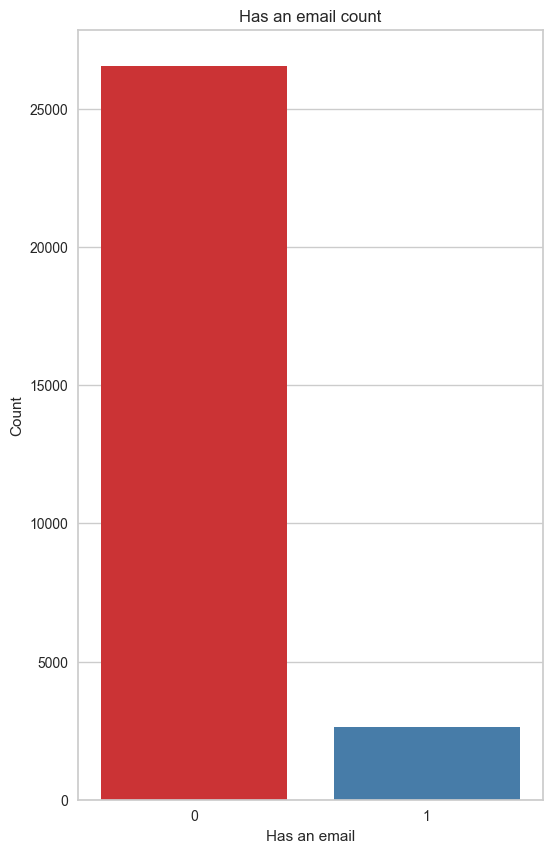

In [123]:
make_bar_chart(cc_train_clone,'Has an email')

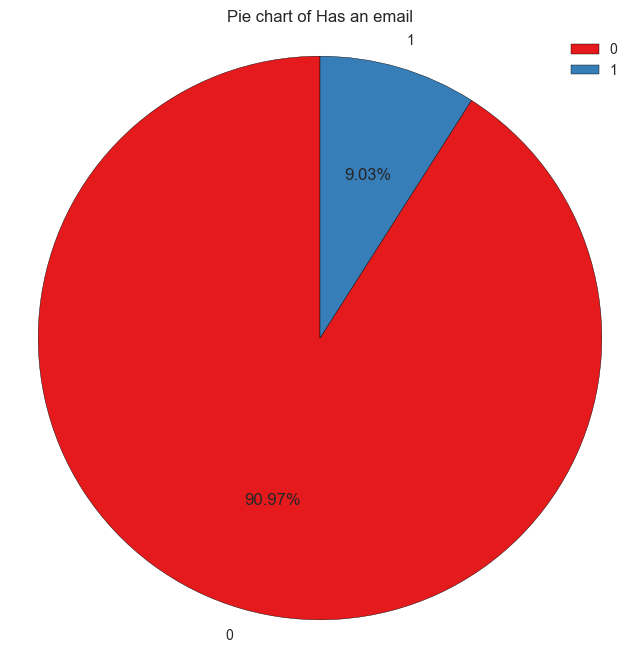

In [124]:
make_donut_chart(cc_train_clone,'Has an email')

Interpretation:

- More than 90% of applicants don’t have an email
- Note: Here 0 is no and 1 is yes

### 2.4.18 Account Age

In [125]:
build_summary_feature(cc_train_clone,'Account age')

Description:
count   29165.00
mean       26.14
std        16.49
min         0.00
25%        12.00
50%        24.00
75%        39.00
max        60.00
Name: Account age, dtype: float64
**************************************************
Object type:float64


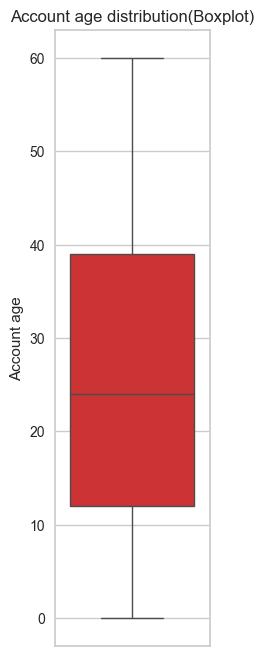

In [126]:
make_box_chart(cc_train_clone,'Account age')

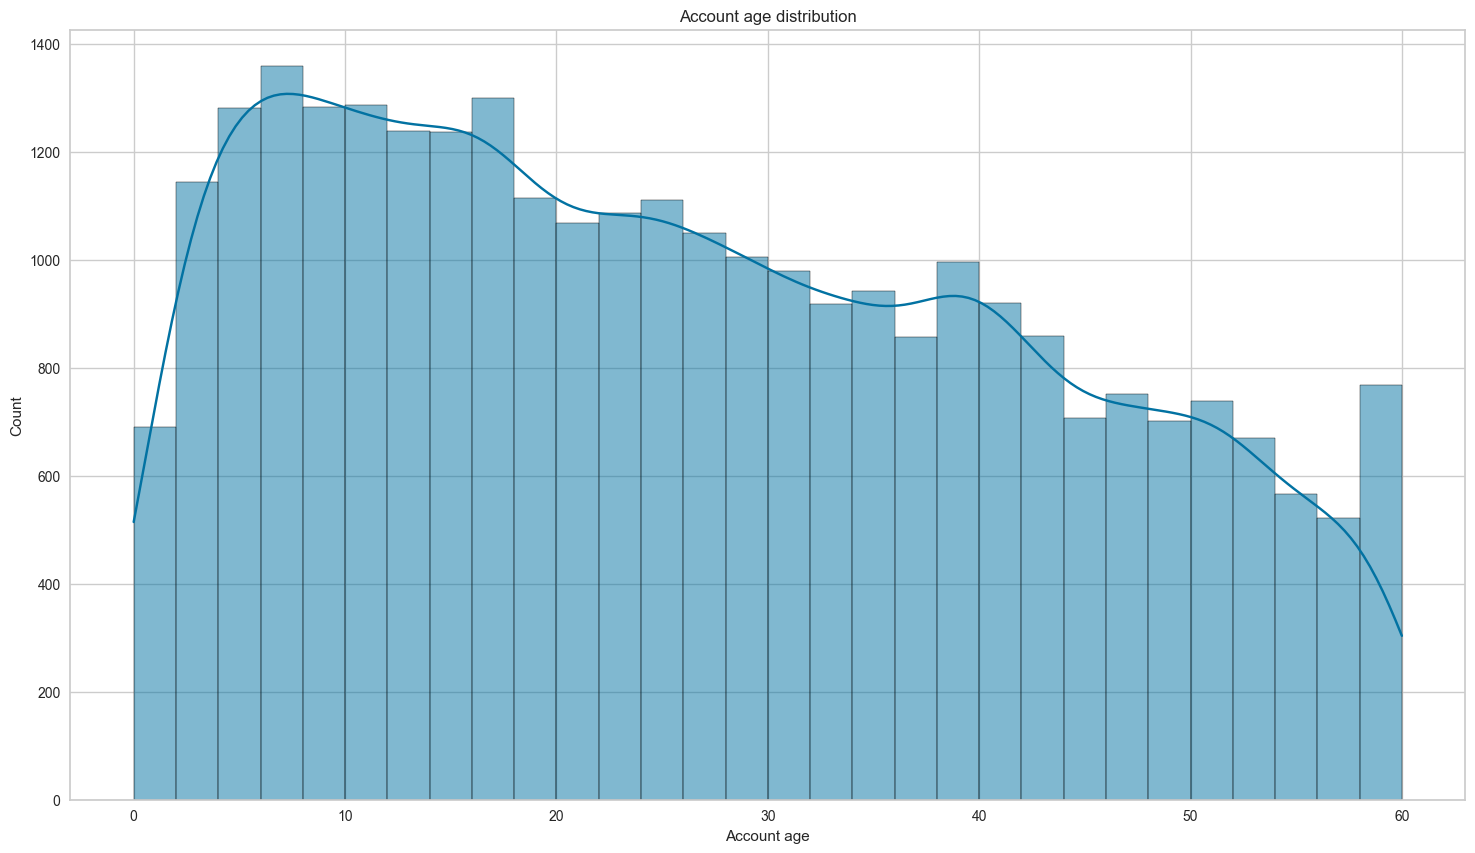

In [127]:
make_hist_chart(cc_train_clone,'Account age', the_bins=30)

Is high risk
0   26.00
1   34.04
Name: Account age, dtype: float64


C:\Users\karan\AppData\Local\Temp\ipykernel_45188\1270967700.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=np.abs(df[feature]),x=df['Is high risk'], palette='Set1')


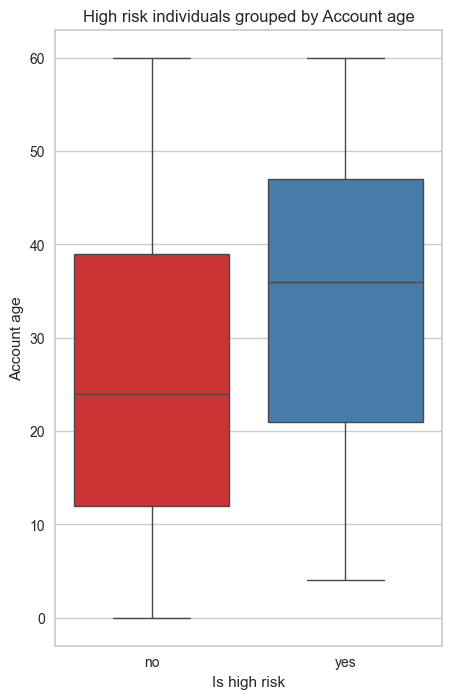

In [128]:
low_high_risk_box_chart(cc_train_clone,'Account age')


Interpretation:

- Most accounts are 26 months old
- ccount age is not normally distributed, it is positively skewed
- The accounts that have been flagged as high risk are on average 34 months old vs 26 months old for old account

### 2.4.19 Is High Risk ( Target Variable )

In [ ]:
build_summary_feature(cc_train_clone,'Is high risk')

Description:
count     29165
unique        2
top           0
freq      28666
Name: Is high risk, dtype: int64
**************************************************
Object type:
object
**************************************************
              Count  Frequency (%)
Is high risk                      
0             28666          98.29
1               499           1.71


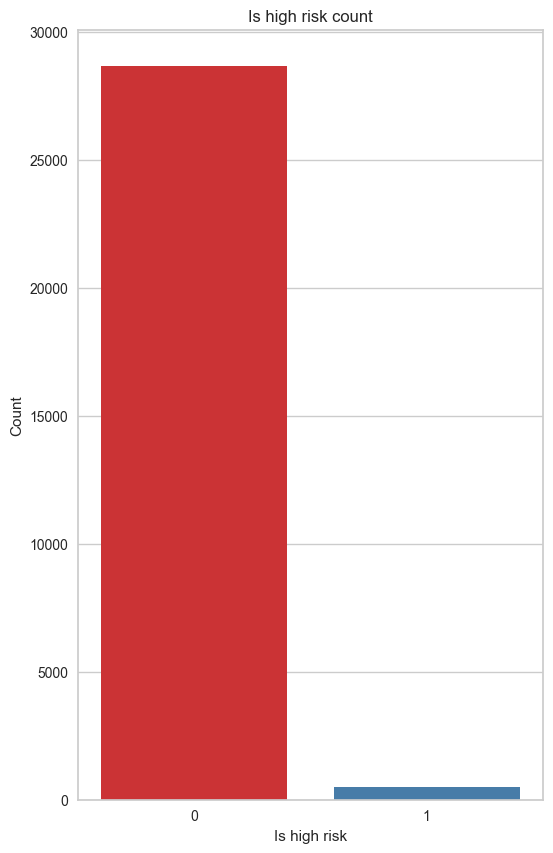

In [ ]:
make_bar_chart(cc_train_clone,'Is high risk')

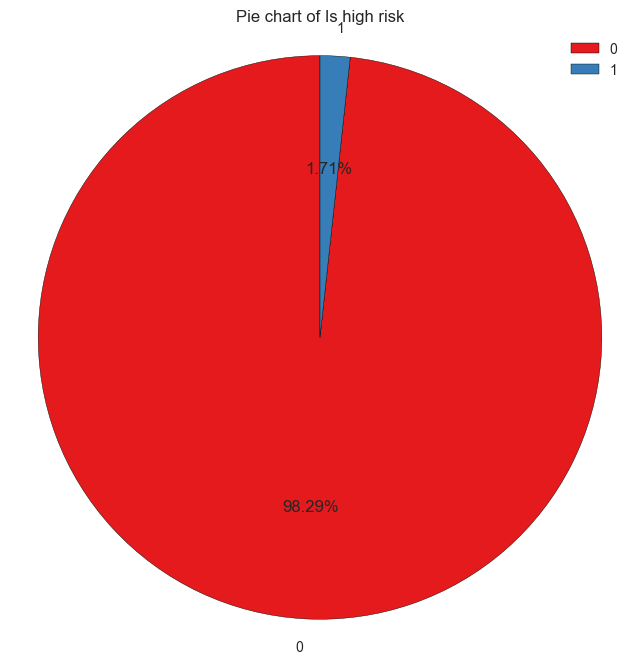

In [ ]:
make_donut_chart(cc_train_clone,'Is high risk')

Interpretation:

- A vast majority of applicants are low risk applicants.
- We have a very imbalance data.
- Note: Here 0 is no and 1 is yes

## 2.5 Bivariate Analysis

### 2.5.1 Numerical vs Numerical Features

#### 2.5.1.1 Scatter plots

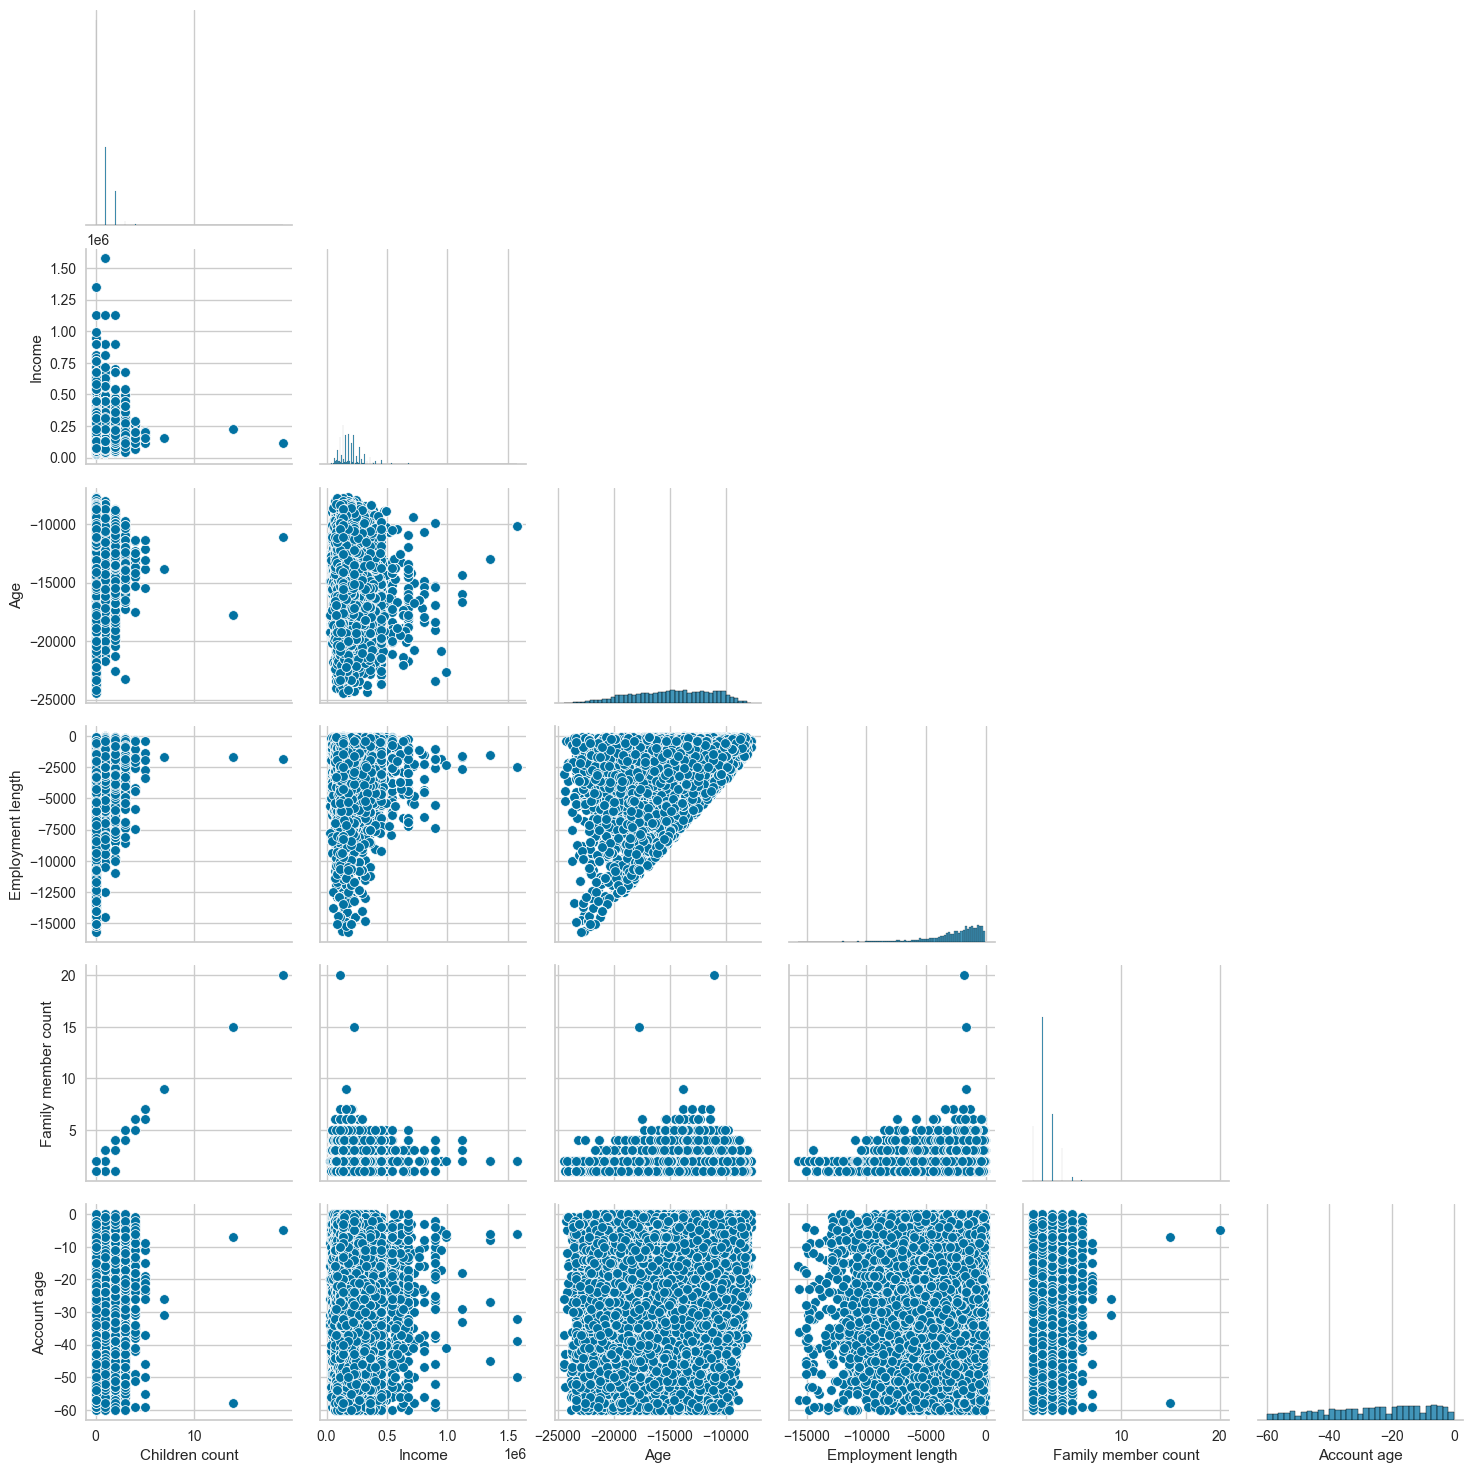

In [129]:
sns.pairplot(cc_train_clone[cc_train_clone['Employment length'] < 0].drop(['ID','Has a mobile phone', 'Has a work phone', 'Has a phone', 'Has an email','Is high risk'],axis=1),corner=True)
plt.show()

Interpretation:

- We can see a positive linear correlation between the family member and the children count. This makes sense, the more the children someone have, the larger the family member count. This is a multicollinearity problem. Meaning that the features are highly correlated. we aim to need to drop one of them.
- Another interesting trend is the Employment length and age. This also makes sense, the longer the employee has been working, the older they are.

#### 2.5.1.1.1 Family member count vs children count (numerical vs numerical feature comparison)

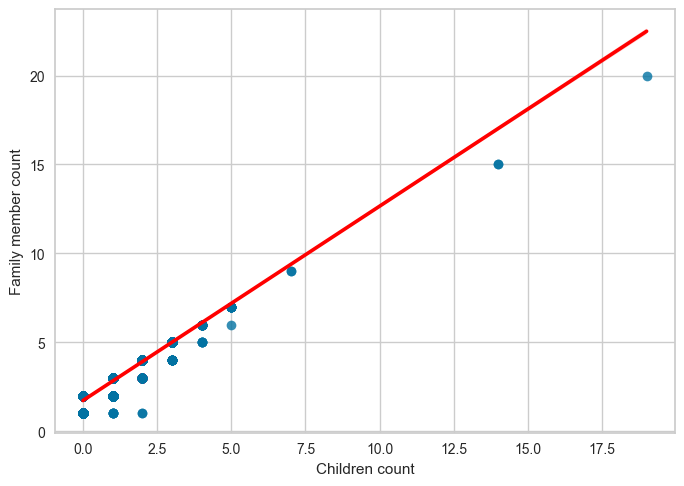

In [130]:
sns.regplot(x='Children count',y='Family member count',data=cc_train_clone,line_kws={'color': 'red'})
plt.show()

#### 2.5.1.1.2 Account age vs age (numerical vs numerical feature comparison)

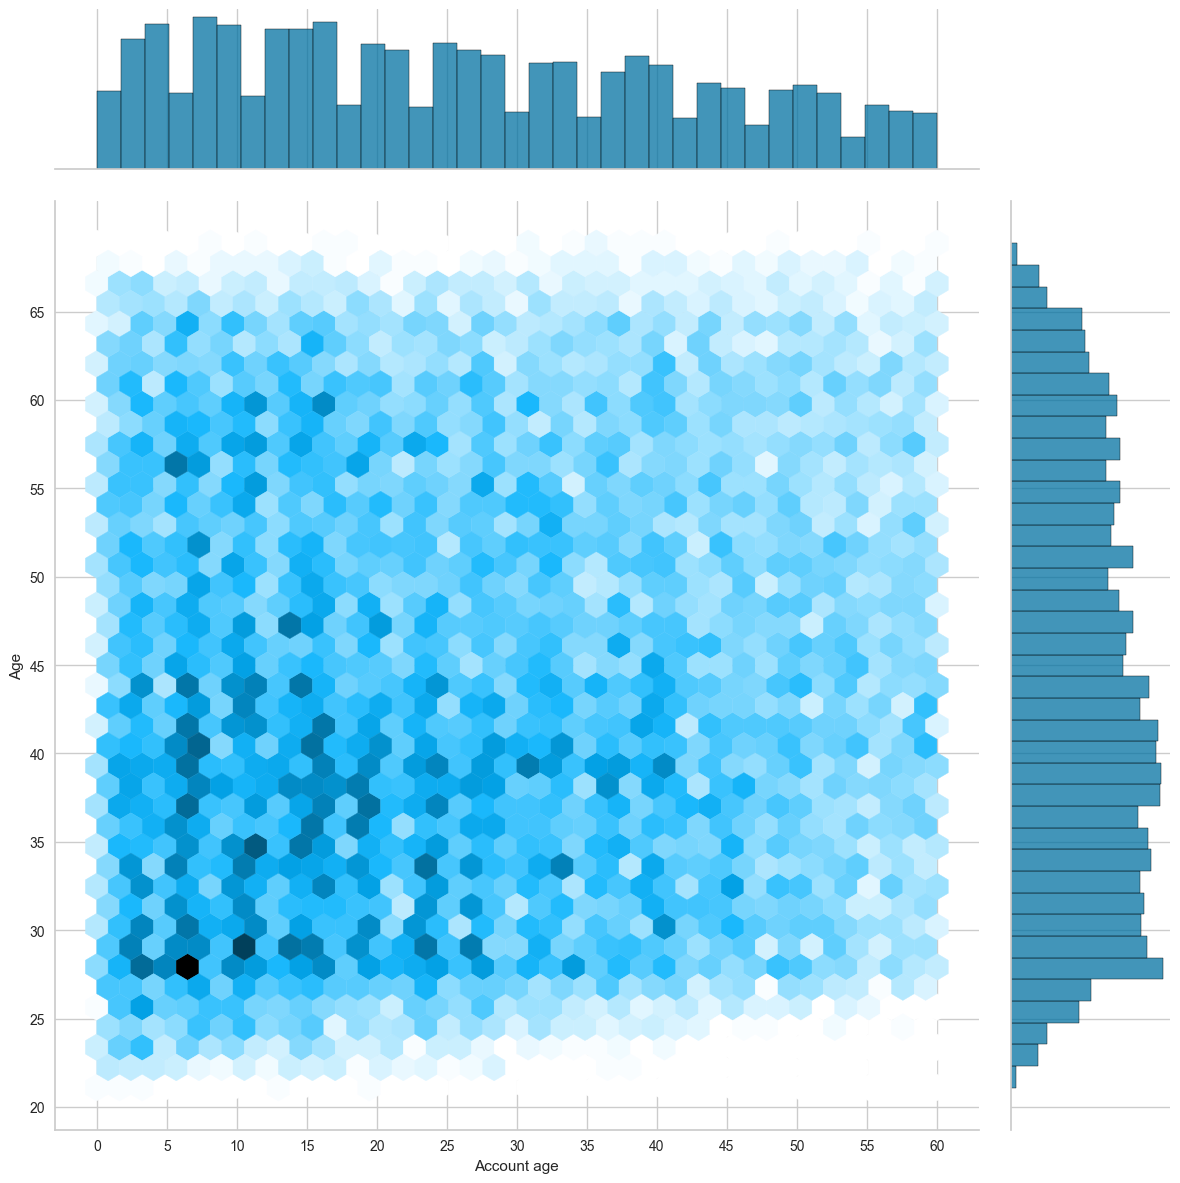

In [131]:
y_age_v2 = np.abs(cc_train_clone['Age']) / 365.25

sns.jointplot(
    x=np.abs(cc_train_clone['Account age']),
    y=y_age_v2,
    kind="hex",
    height=12
)

plt.yticks(np.arange(20, y_age_v2.max(), 5))
plt.xticks(np.arange(0, 65, 5))
plt.ylabel('Age')
plt.show()

#### 2.5.1.1.3 Employment length vs age (numerical vs numerical feature comparison)

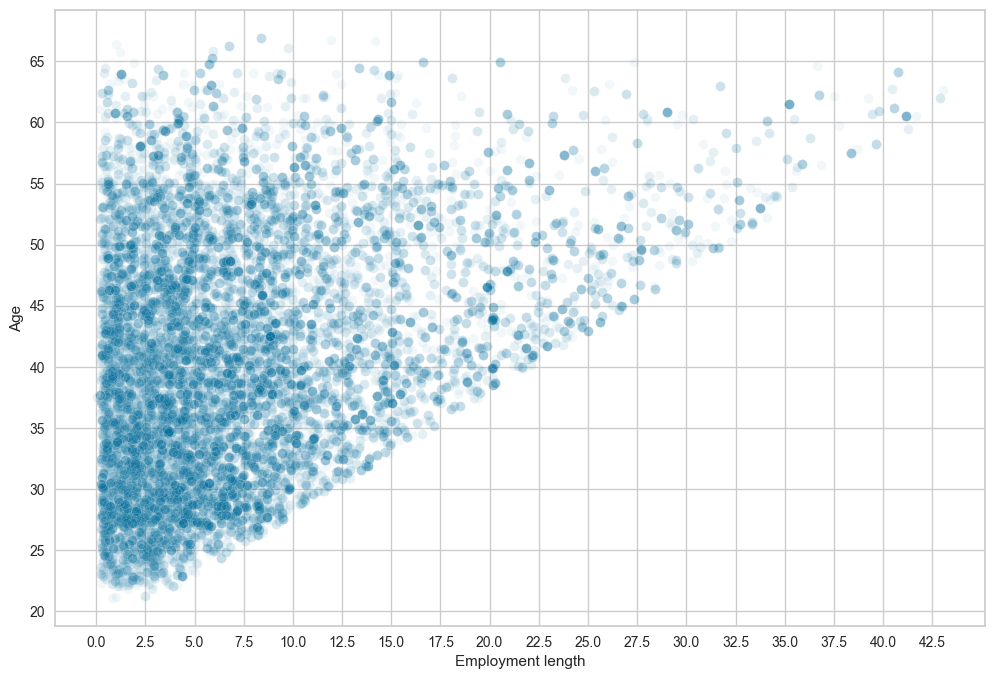

In [132]:
x_employ_length_v2 = (
    np.abs(cc_train_clone[cc_train_clone['Employment length'] < 0]['Employment length'])
    / 365.25
)

fig_v2, ax_v2 = plt.subplots(figsize=(12, 8))

sns.scatterplot(
    x=x_employ_length_v2,
    y=y_age_v2,
    alpha=0.05,
    ax_v2=ax_v2
)

plt.xticks(np.arange(0, x_employ_length_v2.max(), 2.5))
plt.yticks(np.arange(20, y_age_v2.max(), 5))
plt.show()

Interpretation:

- This scatterplot shows that the age of the applicants is correlated with the length of the employment. The reason why it is shaped like a reversed triangle, it is because the age of the applicants increase with the length of the employment. You can't have an employment length > than the age

### 2.5.1.2 Correlation analysis

In [133]:
# change the datatype of label predictor to int
is_high_risk_int_v2 = cc_train_clone['Is high risk'].astype('int32')

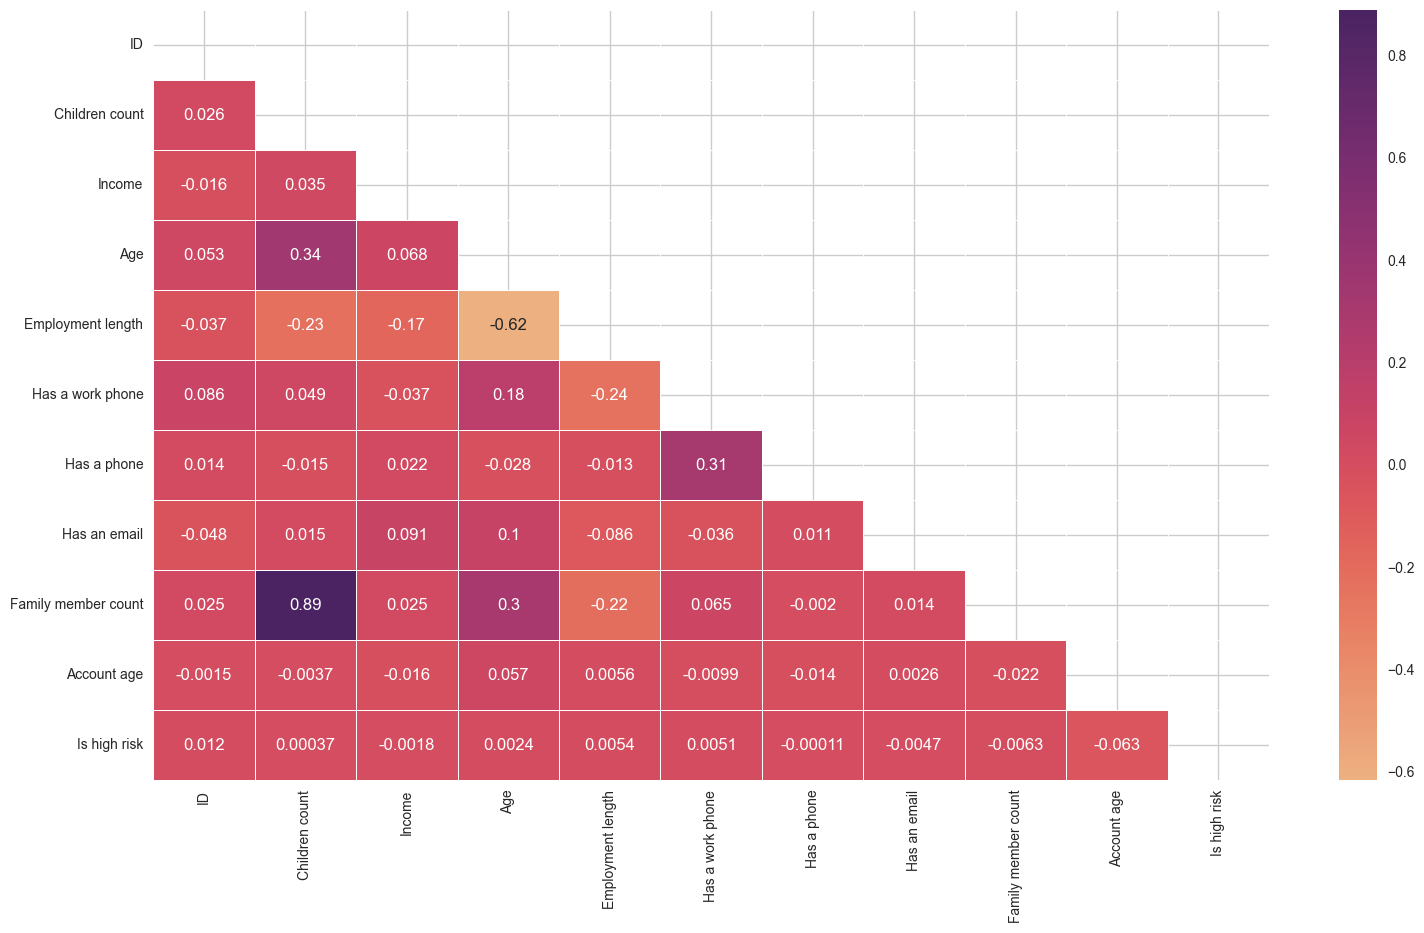

In [134]:
# correlation analysis with heatmap, after dropping the has a mobile phone with the label predictor as int
df_corr_v2 = pd.concat(
    [cc_train_clone.drop(['Has a mobile phone', 'Is high risk'], axis=1), is_high_risk_int_v2],
    axis=1
)

cc_train_clone_corr_no_mobile = df_corr_v2.select_dtypes(include='number').corr()
# Get the lower triangle of the correlation matrix
# Generate a mask for the upper triangle
mask_v2 = np.zeros_like(cc_train_clone_corr_no_mobile, dtype='bool')
mask_v2[np.triu_indices_from(mask_v2)] = True
# Set up the matplotlib figure
fig_v2, ax_v2 = plt.subplots(figsize=(18,10))
# seaborn heatmap
sns.heatmap(cc_train_clone_corr_no_mobile, annot=True, cmap='flare',mask_v2=mask_v2, linewidths=.5)
# chart the heatmap
plt.show()

Interpretation:

- There is no feature that is correlated with the target feature
- Family member count is highly correlated with children count as previously discussed
- Age has some positive correlation with the family member count and children count. The older a person is, the most likely he/she will have a larger family.
- Another positive correlation is having a phone and having a work phone.
- The final positive correlation is between the age and work phone. The younger someone is the less likely he/she will have a work phone.
- We also have a negative correlation between the employment length and the age as previously seen.

### 2.5.2 Numerical vs categorical features (ANOVA)

#### 2.5.2.1 Age vs the rest of categorical features

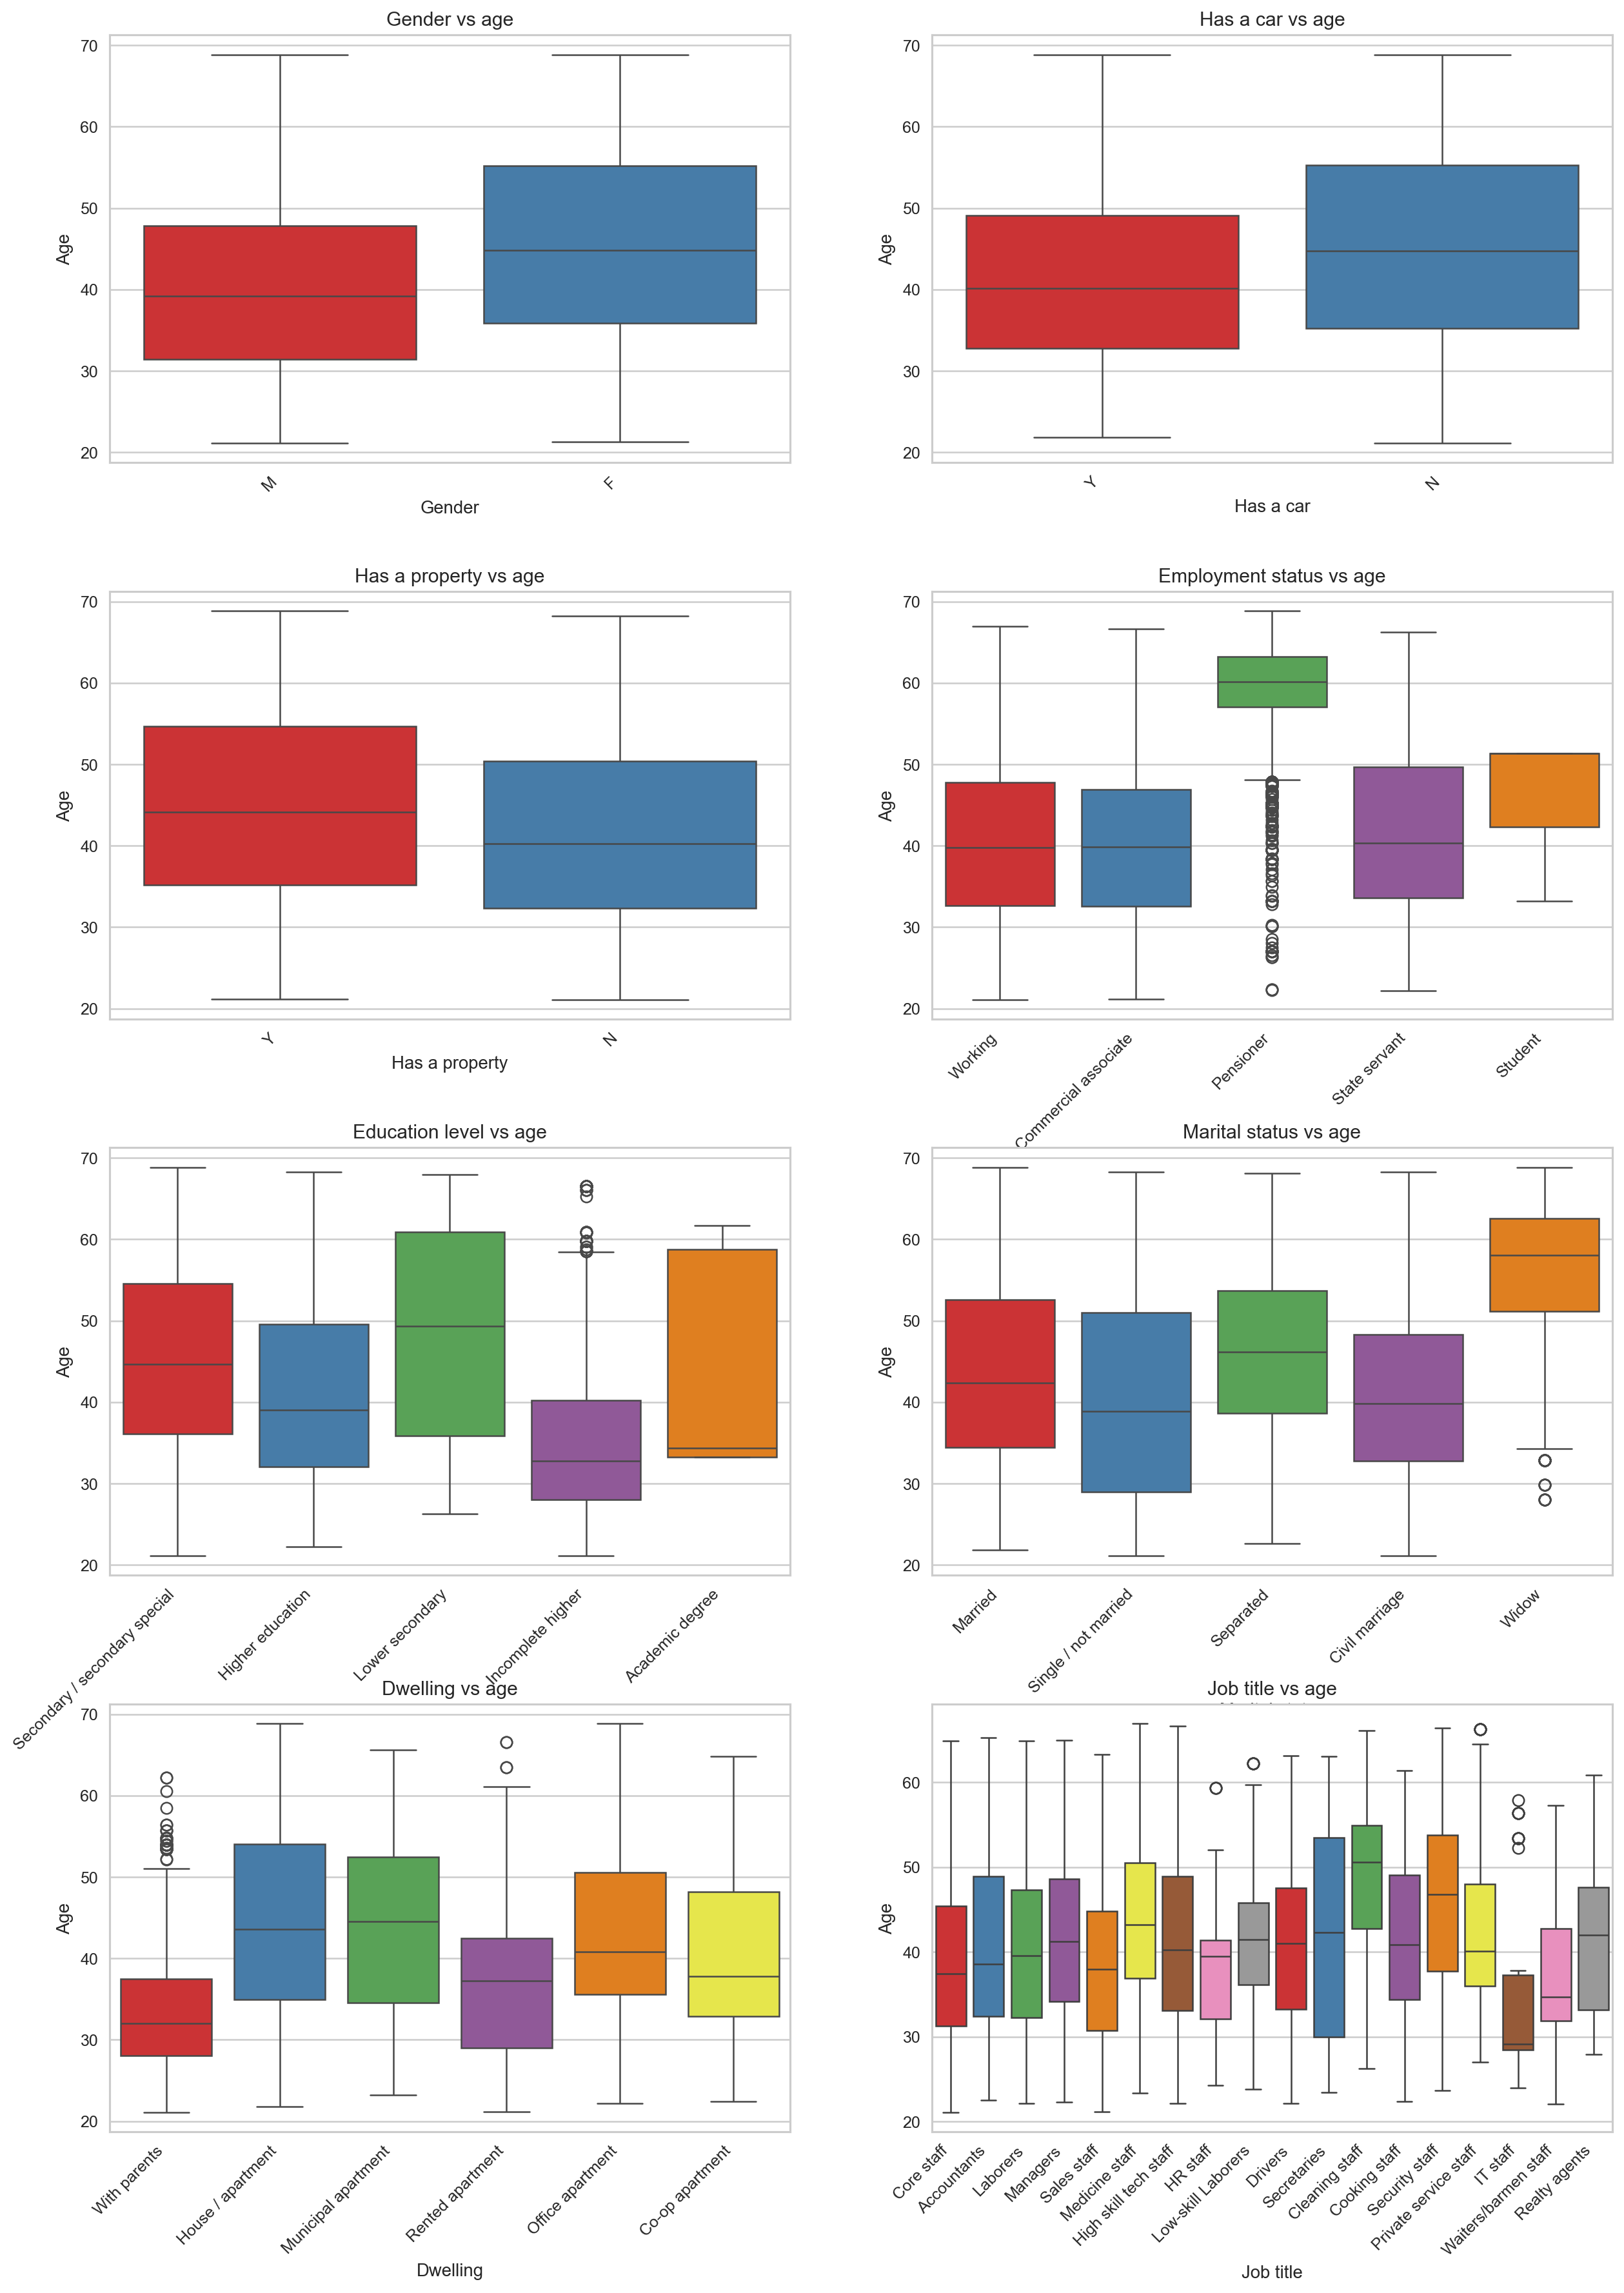

In [135]:
fig_v2, axes_v2 = plt.subplots(4, 2, figsize=(15, 20), dpi=180)
fig_v2.tight_layout(pad=5.0)

cat_features_v2 = [
    'Gender', 'Has a car', 'Has a property', 'Employment status',
    'Education level', 'Marital status', 'Dwelling', 'Job title'
]

for cat_ft_count_v2, ax_v2 in enumerate(axes_v2):
    for row_count_v2 in range(4):
        for feature_count in range(2):
            sns.boxplot(
                ax_v2=axes_v2[row_count_v2, feature_count],
                x=cc_train_clone[cat_features_v2[cat_ft_count_v2]],
                y=np.abs(cc_train_clone['Age']) / 365.25,
                hue=cc_train_clone[cat_features_v2[cat_ft_count_v2]],
                palette='Set1',
                dodge=False
            )
            axes_v2[row_count_v2, feature_count].set_title(cat_features_v2[cat_ft_count_v2] + " vs age")
            plt.sca(axes_v2[row_count_v2, feature_count])
            plt.xticks(rotation=45, ha='right')
            plt.ylabel('Age')

            # drop redundant legend
            if axes_v2[row_count_v2, feature_count].legend_ is not None:
                axes_v2[row_count_v2, feature_count].legend_.remove()

            cat_ft_count_v2 += 1
    break

plt.show()

Interpretation:

- Female applicants are older than their male counterpart.
- Those who don't own a car tend to be older.
- Those who own a property tend to be older than those who don't.
- Of course, the pensioners are older that those who are working (We also see that some have pensioned at a young age, those are outliers).
- It is also interesting to see that those who hold an academic degree are younger in general than the other groups.
- Obviously, the widows tend to be much older. We also see some outliers in their 30's as well.
- With no surprise, those who live with parent tend to be younger. We also see some outlier as well.
- Lastly, who work as cleaning staff tend to be older while those who work in IT tend to be younger.

#### 2.4.2.2 Income vs the rest of categorical features

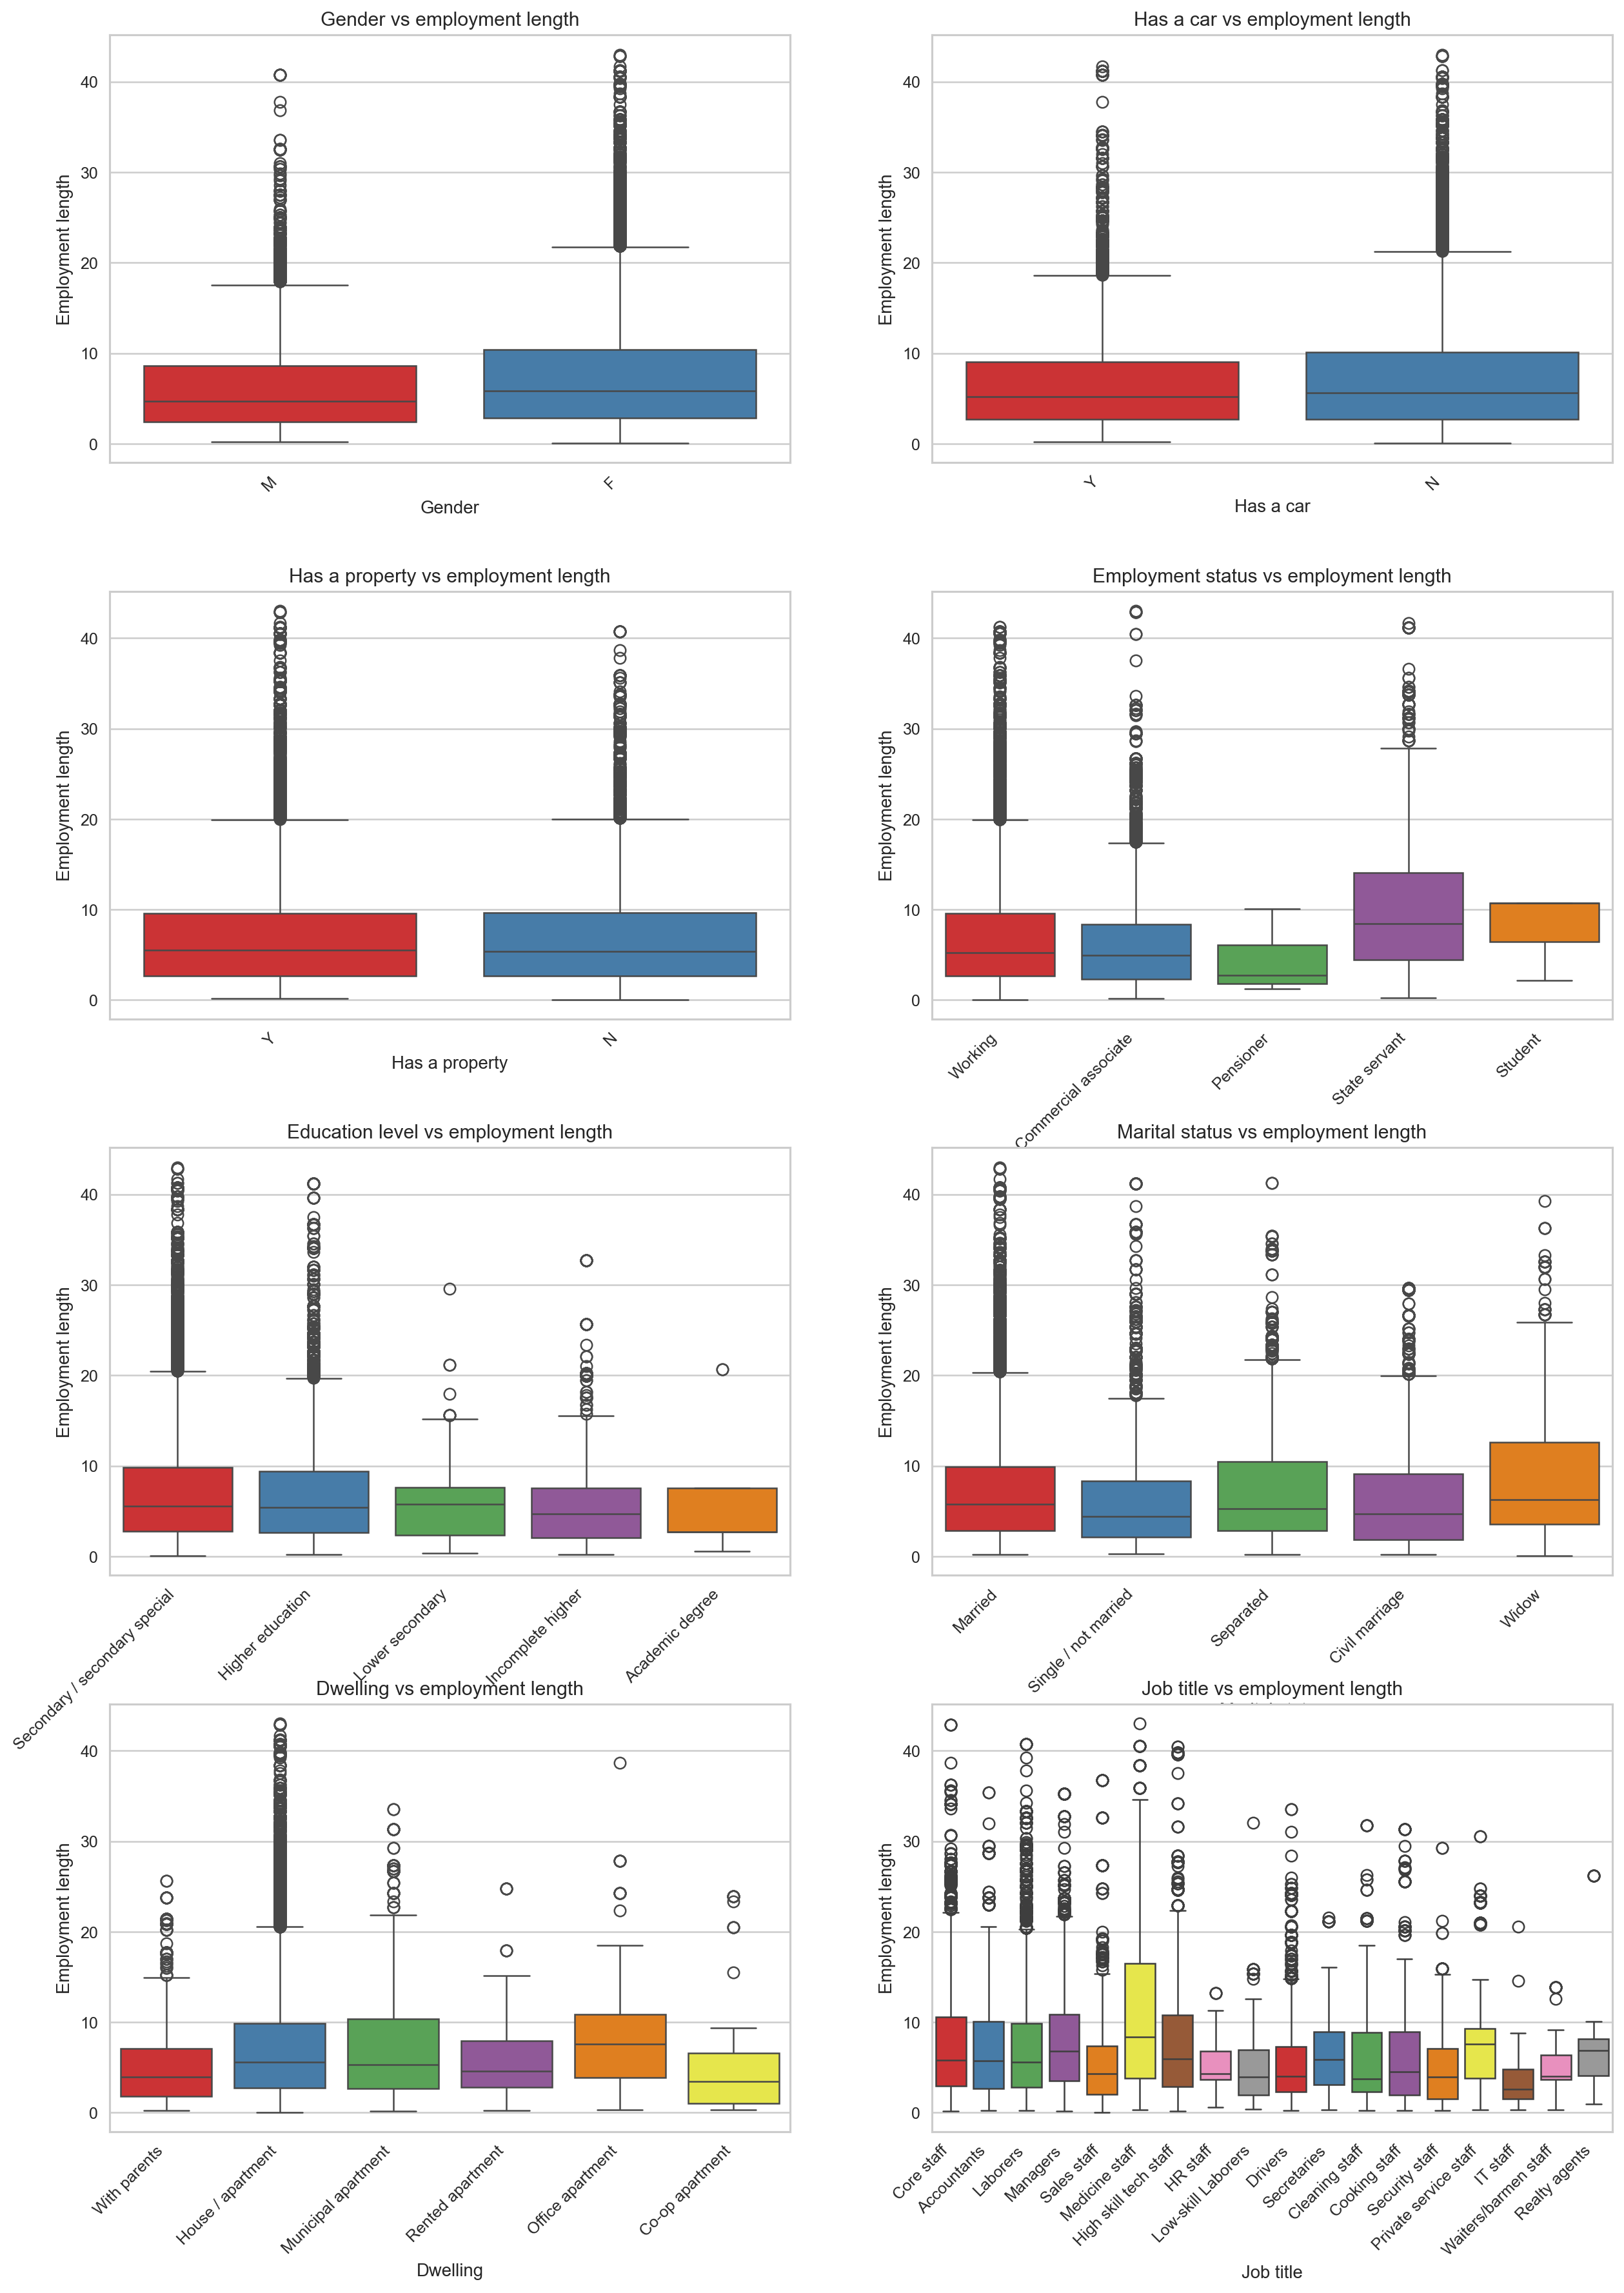

In [136]:
fig_v2, axes_v2 = plt.subplots(4, 2, figsize=(15, 20), dpi=180)
fig_v2.tight_layout(pad=5.0)

for cat_ft_count_v2, ax_v2 in enumerate(axes_v2):
    for row_count_v2 in range(4):
        for feature_count in range(2):
            sns.boxplot(
                ax_v2=axes_v2[row_count_v2, feature_count],
                x=cc_train_clone[cat_features_v2[cat_ft_count_v2]],
                y=np.abs(
                    cc_train_clone[cc_train_clone['Employment length'] < 0]['Employment length']
                ) / 365.25,
                hue=cc_train_clone[cat_features_v2[cat_ft_count_v2]],
                palette='Set1',
                dodge=False
            )

            axes_v2[row_count_v2, feature_count].set_title(
                cat_features_v2[cat_ft_count_v2] + " vs employment length"
            )

            plt.sca(axes_v2[row_count_v2, feature_count])
            plt.ylabel('Employment length')
            plt.xticks(rotation=45, ha='right')

            # drop redundant legend
            if axes_v2[row_count_v2, feature_count].legend_ is not None:
                axes_v2[row_count_v2, feature_count].legend_.remove()

            cat_ft_count_v2 += 1
    break

plt.show()

Interpretation:

- State employed applicant tend to have been employed longer than the rest.
- Those who work in the medical field, have been employed longer than the rest.

### 2.4.3 Categorical vs categorical features (Chi-square test)

Null hypothesis: the feature's categories have no effect on the target variable. Alternate hypothesis: one(or more) of the feature categories has a significant effect on the target variable.

In [137]:
def chisq_fn(feature):
    # selection row with high risk
    high_risk_ft = cc_train_clone[cc_train_clone['Is high risk'] == 1][feature]
    high_risk_ft_ct = pd.crosstab(index=high_risk_ft, columns=['Count']).rename_axis(None, axis=1)
    # drop the index predictor name
    high_risk_ft_ct.index.name = None
    # observe values
    obs = high_risk_ft_ct
    print('Observed values:\n')
    print(obs)
    print('\n')
    # expected values
    print(obs.index)
    exp = pd.DataFrame([obs['Count'].sum()/len(obs)] * len(obs.index),columns=['Count'], index=obs.index)
    print('Expected values:\n')
    print(exp)
    print('\n')
    # chi-square eval
    chi_squared_stat = (((obs-exp)**2)/exp).sum()
    print('Chi-square:\n')
    print(chi_squared_stat[0])
    print('\n')
    #critical value
    crit = stats.chi2.ppf(q = 0.95, df = len(obs) - 1)
    print('Critical value:\n')
    print(crit)
    print('\n')
    # p-value
    p_value = 1 - stats.chi2.cdf(x = chi_squared_stat, df = len(obs) - 1)
    print('P-value:\n')
    print(p_value)
    print('\n')
    if chi_squared_stat[0] >= crit:
        print('Reject the null hypothesis')
    elif chi_squared_stat[0] <= crit:
        print('Fail to reject the null hypothesis')

In [138]:
from scipy.stats import chi2_contingency

def chisq_feature_vs_label(df, feature, target='Is high risk'):
    # contingency table: rows = label (0/1), columns = categories
    table = pd.crosstab(df[target], df[feature])

    chi2_stat, p, dof, expected = chi2_contingency(table)

    print(f'Feature: {feature}')
    print('Contingency table (observed):')
    print(table)
    print('\nChi-square:', chi2_stat)
    print('dof:', dof)
    print('p-value:', p)

    if p < 0.05:
        print('Reject H0: feature is associated with target')
    else:
        print('Fail to reject H0: no evidence of association')


In [139]:
cat_ft_v2 = ['Gender', 'Has a car', 'Has a property', 'Employment status',
          'Education level', 'Marital status', 'Dwelling', 'Job title']

for ft_v2 in cat_ft_v2:
    print('\n' + '*'*10)
    chisq_feature_vs_label(cc_train_clone, ft_v2)


**********
Feature: Gender
Contingency table (observed):
Gender            F     M
Is high risk             
0             19243  9423
1               306   193

Chi-square: 7.2198190810918454
dof: 1
p-value: 0.007210297447255477
Reject H0: feature is associated with target

**********
Feature: Has a car
Contingency table (observed):
Has a car         N      Y
Is high risk              
0             17811  10855
1               317    182

Chi-square: 0.348204727221194
dof: 1
p-value: 0.5551311539343562
Fail to reject H0: no evidence of association

**********
Feature: Has a property
Contingency table (observed):
Has a property     N      Y
Is high risk               
0               9398  19268
1                210    289

Chi-square: 18.782642112088492
dof: 1
p-value: 1.4649435529152776e-05
Reject H0: feature is associated with target

**********
Feature: Employment status
Contingency table (observed):
Employment status  Commercial associate  Pensioner  State servant  Student  \
Is

## 2.5 Business findings from the EDA

- Typical profile of an applicant is: a Female in her early 40’s, married with a partner and no child. She has been employed for 5 years with a salary of 157500. She has completed her secondary education. She does not own a car but owns a property (a house/ apartment). Her account is 26 months old.
- Age and income do not have any effects on the target variable
- Those who are flagged as bad client, tend to have a shorter employment length and older accounts. They also constitute less than 2% of total applicants.
- Most applicants are 20 to 45 years old and have an account that is 25 months old or less.

# 3. Prepare the data

## 3.1 Transform to be done on each feature

ID:

Drop the feature
Gender:

One hot encoding
Age:

Min-max scaling
Fix skewness
Abs value and div 365.25
Marital status:

One hot encoding
Family member count

Fix outliers
Children count

Fix outliers
Drop feature
Dwelling type

One hot encoding
Income

Remove outliers
Fix skewness
Min-max scaling
Job title

One hot encoding
Impute missing values
Employment status:

One hot encoding
Education level:

Ordinal encoding
Employment length:

Remove outliers
Min-max scaling
Abs value and div 365.25
change days of employments of retirees to 0
Has a car:

Change it numerical
One-hot encoding
Has a property:

Change it numerical
One-hot encoding
Has a mobile phone:

Drop feature
Has a work phone:

One-hot encoding
Has a phone:

One-hot encoding
Has an email:

One-hot encoding
Account age:

Drop feature
Is high risk(Target):

Change the data type to numerical
balance the data with SMOTE

## 3.2 Data Cleaning

### 3.2.1 Outliers handling

In [156]:
class OutlierRemoverV2(BaseEstimator, TransformerMixin):
    def __init__(self,feat_with_outliers = ['Family member count','Income', 'Employment length']):
        self.feat_with_outliers = feat_with_outliers
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.feat_with_outliers).issubset(df.columns)):
            # 25% quantile
            Q1 = df[self.feat_with_outliers].quantile(.25)
            # 75% quantile
            Q3 = df[self.feat_with_outliers].quantile(.75)
            IQR = Q3 - Q1
            # keep the dataset within 3 IQR
            df = df[~((df[self.feat_with_outliers] < (Q1 - 3 * IQR)) |(df[self.feat_with_outliers] > (Q3 + 3 * IQR))).any(axis=1)]
            return df
        else:
            print("One or more features are not in the dataframe")
            return df

## 3.3 Feature selection

### 3.3.1 Drop features

In [157]:
class DropFeaturesV2(BaseEstimator,TransformerMixin):
    def __init__(self,feature_to_drop = ['ID','Has a mobile phone','Children count','Job title','Account age']):
        self.feature_to_drop = feature_to_drop
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.feature_to_drop).issubset(df.columns)):
            df.drop(self.feature_to_drop,axis=1,inplace=True)
            return df
        else:
            print("One or more features are not in the dataframe")
            return df

Why are we droping these features?

- ID: ID is not useful for prediction, it helped us when we were merging the two datasets but after that, there is no need to keep it.
- Has a mobile phone: Since everyone has a mobile phone, this feature does not inform us about anything.
- Children count: is highly correlated with Family member count, and to avoid multicollinearity, we drop it.
- Job title: Has some missing values and the count of each category is not very different to justify the use of mode. So we drop it.
- Account age: Because account was used to create the target, reusing will make our Estimator to overfit. Plus, this information is unknown while applying for a credit card.

## 3.4 Feature engineering

### 3.4.1 Time conversion

In [158]:
class TimeConversionHandlerV2(BaseEstimator, TransformerMixin):
    def __init__(self, feat_with_days = ['Employment length', 'Age']):
        self.feat_with_days = feat_with_days
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        if (set(self.feat_with_days).issubset(X.columns)):
            # transform days to absolute value
            X[['Employment length','Age']] = np.abs(X[['Employment length','Age']])
            return X
        else:
            print("One or more features are not in the dataframe")
            return X

### 3.4.2 Retiree handling (in the employment length feature)

In [159]:
class RetireeHandlerV2(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, df):
        return self
    def transform(self, df):
        if 'Employment length' in df.columns:
            # select rows with employment length is 365243 which corresponds to retirees
            df_ret_idx = df['Employment length'][df['Employment length'] == 365243].index
            # change 365243 to 0
            df.loc[df_ret_idx,'Employment length'] = 0
            return df
        else:
            print("Employment length is not in the dataframe")
            return df

### 3.4.3 Skewness handling

In [160]:
class SkewnessHandlerV2(BaseEstimator, TransformerMixin):
    def __init__(self,feat_with_skewness=['Income','Age']):
        self.feat_with_skewness = feat_with_skewness
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.feat_with_skewness).issubset(df.columns)):
            # Handle skewness with cubic root transformation
            df[self.feat_with_skewness] = np.cbrt(df[self.feat_with_skewness])
            return df
        else:
            print("One or more features are not in the dataframe")
            return df

### 3.4.4 Binning

In [161]:
class BinningNumToYNV2(BaseEstimator, TransformerMixin):
    def __init__(self,feat_with_num_enc=['Has a work phone','Has a phone','Has an email']):
        self.feat_with_num_enc = feat_with_num_enc
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.feat_with_num_enc).issubset(df.columns)):
            # Change 0 to N and 1 to Y for all the features in feat_with_num_enc
            for ft_v2 in self.feat_with_num_enc:
                df[ft_v2] = df[ft_v2].map({1:'Y',0:'N'})
            return df
        else:
            print("One or more features are not in the dataframe")
            return df

### 3.4.5 One hot encoding (with feature's name)

In [162]:
class OneHotWithFeatureNames(BaseEstimator,TransformerMixin):
    def __init__(self,one_hot_enc_ft = ['Gender', 'Marital status', 'Dwelling', 'Employment status', 'Has a car', 'Has a property', 'Has a work phone', 'Has a phone', 'Has an email']):
        self.one_hot_enc_ft = one_hot_enc_ft
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.one_hot_enc_ft).issubset(df.columns)):
            # helper to one hot encode the features in one_hot_enc_ft
            def one_hot_enc(df,one_hot_enc_ft):
                one_hot_enc = OneHotEncoder()
                one_hot_enc.fit(df[one_hot_enc_ft])
                # get the result of the one hot encoding columns names
                feat_names_one_hot_enc = one_hot_enc.get_feature_names_out(one_hot_enc_ft)
                # change the array of the one hot encoding to a dataframe with the column names
                df = pd.DataFrame(one_hot_enc.transform(df[self.one_hot_enc_ft]).toarray(),columns=feat_names_one_hot_enc,index=df.index)
                return df
            # helper to concatenat the one hot encoded features with the rest of features that were not encoded
            def concat_with_rest(df,one_hot_enc_df,one_hot_enc_ft):
                # get the rest of the features
                rest_of_features = [ft_v2 for ft_v2 in df.columns if ft_v2 not in one_hot_enc_ft]
                # concatenate the rest of the features with the one hot encoded features
                df_concat = pd.concat([one_hot_enc_df, df[rest_of_features]],axis=1)
                return df_concat
            # one hot encoded dataframe
            one_hot_enc_df = one_hot_enc(df,self.one_hot_enc_ft)
            # returns the concatenated dataframe
            full_df_one_hot_enc = concat_with_rest(df,one_hot_enc_df,self.one_hot_enc_ft)
            return full_df_one_hot_enc
        else:
            print("One or more features are not in the dataframe")
            return df

### 3.4.6 Ordinal encoding (with feature's names)

In [163]:
class OrdinalFeatureNames(BaseEstimator,TransformerMixin):
    def __init__(self,ordinal_enc_ft = ['Education level']):
        self.ordinal_enc_ft = ordinal_enc_ft
    def fit(self,df):
        return self
    def transform(self,df):
        if 'Education level' in df.columns:
            ordinal_enc = OrdinalEncoder()
            df[self.ordinal_enc_ft] = ordinal_enc.fit_transform(df[self.ordinal_enc_ft])
            return df
        else:
            print("Education level is not in the dataframe")
            return df

### 3.4.7 Min-Max scaling (with feature's names)

In [164]:
class MinMaxWithFeatureNames(BaseEstimator,TransformerMixin):
    def __init__(self,min_max_scaler_ft = ['Age', 'Income', 'Employment length']):
        self.min_max_scaler_ft = min_max_scaler_ft
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.min_max_scaler_ft).issubset(df.columns)):
            min_max_enc = MinMaxScaler()
            df[self.min_max_scaler_ft] = min_max_enc.fit_transform(df[self.min_max_scaler_ft])
            return df
        else:
            print("One or more features are not in the dataframe")
            return df

### 3.4.8 Change the data types of the target feature

In [165]:
class ChangeToNumLabel(BaseEstimator,TransformerMixin):
    def __init__(self):
        pass
    def fit(self,df):
        return self
    def transform(self,df):
        if 'Is high risk' in df.columns:
            df['Is high risk'] = pd.to_numeric(df['Is high risk'])
            return df
        else:
            print("Is high risk is not in the dataframe")
            return df

### 3.4.9 Oversampling

In [166]:
class OversampleV2(BaseEstimator,TransformerMixin):
    def __init__(self):
        pass
    def fit(self,df):
        return self
    def transform(self,df):
        if 'Is high risk' in df.columns:
            # smote helper to oversample the minority class to fix the imbalance dataset
            oversample = SMOTE(sampling_strategy='minority')
            X_bal, y_bal = oversample.fit_resample(df.loc[:, df.columns != 'Is high risk'],df['Is high risk'])
            df_bal = pd.concat([pd.DataFrame(X_bal),pd.DataFrame(y_bal)],axis=1)
            return df_bal
        else:
            print("Is high risk is not in the dataframe")
            return df

We are oversampling with SMOTE because the minority class (Is high risk = 1) is very rare in the data.

## 3.5 Data Preprocessing

In [167]:
def end_to_end_pipe(df):
    # build the pipeline that will call all the class from OutlierRemoval to OversampleSMOTE in one go
    pipeline = Pipeline([
        ('outlier_remover', OutlierRemoverV2()),
        ('feature_dropper', DropFeaturesV2()),
        ('time_conversion_handler', TimeConversionHandlerV2()),
        ('retiree_handler', RetireeHandlerV2()),
        ('skewness_handler', SkewnessHandlerV2()),
        ('binning_num_to_yn', BinningNumToYNV2()),
        ('one_hot_with_feat_names', OneHotWithFeatureNames()),
        ('ordinal_feat_names', OrdinalFeatureNames()),
        ('min_max_with_feat_names', MinMaxWithFeatureNames()),
        ('change_to_num_target', ChangeToNumLabel()),
        ('oversample', OversampleV2())
    ])
    df_pipe_prep = pipeline.fit_transform(df)
    return df_pipe_prep

In [168]:
pd.options.mode.chained_assignment = None  # Hide the copy warning
cc_train_prepared = end_to_end_pipe(cc_train_clone)

In [169]:
cc_train_prepared.shape

(46544, 34)

In [170]:
pd.set_option('display.max_columns', None)
cc_train_prepared.head()

Gender_F  Gender_M  Marital status_Civil marriage  Marital status_Married  \
0      0.00      1.00                           0.00                    1.00   
1      1.00      0.00                           0.00                    0.00   
2      1.00      0.00                           0.00                    1.00   
3      1.00      0.00                           0.00                    0.00   
4      1.00      0.00                           0.00                    0.00   

   Marital status_Separated  Marital status_Single / not married  \
0                      0.00                                 0.00   
1                      0.00                                 1.00   
2                      0.00                                 0.00   
3                      0.00                                 1.00   
4                      1.00                                 0.00   

   Marital status_Widow  Dwelling_Co-op apartment  Dwelling_House / apartment  \
0                  0.00                      0.00                        0.00   
1                  0.00                      0.00                        1.00   
2                  0.00                      0.00                        1.00   
3                  0.00                      0.00                        1.00   
4                  0.00                      0.00                        1.00   

   Dwelling_Municipal apartment  Dwelling_Office apartment  \
0                          0.00                       0.00   
1                          0.00                       0.00   
2                          0.00                       0.00   
3                          0.00                       0.00   
4                          0.00                       0.00   

   Dwelling_Rented apartment  Dwelling_With parents  \
0                       0.00                   1.00   
1                       0.00                   0.00   
2                       0.00                   0.00   
3                       0.00                   0.00   
4                       0.00                   0.00   

   Employment status_Commercial associate  Employment status_Pensioner  \
0                                    0.00                         0.00   
1                                    1.00                         0.00   
2                                    1.00                         0.00   
3                                    1.00                         0.00   
4                                    0.00                         0.00   

   Employment status_State servant  Employment status_Student  \
0                             0.00                       0.00   
1                             0.00                       0.00   
2                             0.00                       0.00   
3                             0.00                       0.00   
4                             0.00                       0.00   

   Employment status_Working  Has a car_N  Has a car_Y  Has a property_N  \
0                       1.00         0.00         1.00              0.00   
1                       0.00         0.00         1.00              1.00   
2                       0.00         1.00         0.00              0.00   
3                       0.00         0.00         1.00              0.00   
4                       1.00         1.00         0.00              1.00   

   Has a property_Y  Has a work phone_N  Has a work phone_Y  Has a phone_N  \
0              1.00                1.00                0.00           1.00   
1              0.00                1.00                0.00           1.00   
2              1.00                1.00                0.00           1.00   
3              1.00                1.00                0.00           1.00   
4              0.00                1.00                0.00           0.00   

   Has a phone_Y  Has an email_N  Has an email_Y  Income  Education level  \
0           0.00            1.00            0.00    0.42             4.00   
1     

In [171]:
# split the fit dataset into X and y (label)
X_cc_train_prepared, y_cc_train_prepared = cc_train_prepared.loc[:, cc_train_prepared.columns != 'Is high risk'], cc_train_prepared['Is high risk'].astype('int64')

# 4. Short-list promising models

## 4.1 Models training

In [194]:
classifiers_v2 = {
    'sgd':SGDClassifier(random_state=42,loss='perceptron'),
    'logistic_regression':LogisticRegression(random_state=42,max_iter=1000),
    'decision_tree':DecisionTreeClassifier(random_state=42),
    'random_forest':RandomForestClassifier(random_state=42),
    'gaussian_naive_bayes':GaussianNB(),
    'k_nearest_neighbors':KNeighborsClassifier(),
    'gradient_boosting':GradientBoostingClassifier(random_state=42),
    'linear_discriminant_analysis':LinearDiscriminantAnalysis(),
    'bagging':BaggingClassifier(random_state=42),
    'neural_network':MLPClassifier(random_state=42,max_iter=1000),
    'adaboost':AdaBoostClassifier(random_state=42),
    'extra_trees':ExtraTreesClassifier(random_state=42),
    }

In [173]:
# helper to get the predictor importance of the classifier, and chart it
def feature_importance_chart(estimator_trn, estimator_name):
    if estimator_name not in ['sgd','support_vector_machine','gaussian_naive_bayes','k_nearest_neighbors','bagging','neural_network']:
        # change xtick font size
        plt.rcParams['xtick.labelsize'] = 12
        plt.rcParams['ytick.labelsize'] = 12
        # top 10 most predictive features
        top_10_feat = FeatureImportances(estimator_trn, relative=False, topn=10)
        # top 10 least predictive features
        bottom_10_feat = FeatureImportances(estimator_trn, relative=False, topn=-10)
        #change the figure size
        plt.figure(figsize=(10, 4))
        #change x label font size
        plt.xlabel('xlabel', fontsize=14)
        # Fit to get the predictor importances
        top_10_feat.fit(X_cc_train_prepared, y_cc_train_prepared)
        # show the chart
        top_10_feat.show()
        print('\n')
        plt.figure(figsize=(10, 4))
        plt.xlabel('xlabel', fontsize=14)
        # Fit to get the predictor importances
        bottom_10_feat.fit(X_cc_train_prepared, y_cc_train_prepared)
        # show the chart
        bottom_10_feat.show()
        print('\n')
    else:
        print('No feature importance for {0}'.format(estimator_name))
        print('\n')

In [184]:
def y_prediction_fn(estimator_trn, estimator_name, final_model=False):
    if final_model == False:
        y_cc_train_pred_path = Path('saved_models/{0}/y_train_copy_pred_{0}.sav'.format(estimator_name))
        y_cc_train_pred_path.parent.mkdir(parents=True, exist_ok=True)

        try:
            y_cc_train_pred_path.resolve(strict=True)
        except FileNotFoundError:
            y_cc_train_pred = cross_val_predict(
                estimator_trn, X_cc_train_prepared, y_cc_train_prepared, cv=10, n_jobs=-1
            )
            joblib.dump(y_cc_train_pred, y_cc_train_pred_path)
            return y_cc_train_pred
        else:
            return joblib.load(y_cc_train_pred_path)

    else:
        y_cc_train_pred_path_final = Path('saved_models_final/{0}/y_train_copy_pred_{0}_final.sav'.format(estimator_name))
        y_cc_train_pred_path_final.parent.mkdir(parents=True, exist_ok=True)

        try:
            y_cc_train_pred_path_final.resolve(strict=True)
        except FileNotFoundError:
            y_cc_train_pred_final = cross_val_predict(
                estimator_trn, X_cc_train_prepared, y_cc_train_prepared, cv=10, n_jobs=-1
            )
            joblib.dump(y_cc_train_pred_final, y_cc_train_pred_path_final)
            return y_cc_train_pred_final
        else:
            return joblib.load(y_cc_train_pred_path_final)


In [185]:
def confusion_matrix_fn(estimator_trn, estimator_name, final_model=False):
    if final_model == False:
        fig_v2, ax_v2 = plt.subplots(figsize=(8,8))
        ConfusionMatrixDisplay.from_predictions(
            y_cc_train_prepared,
            y_prediction_fn(estimator_trn, estimator_name),
            ax_v2=ax_v2,
            cmap='Blues',
            values_format='d'
        )
        plt.grid(visible=None)
        plt.xlabel('Predicted label', fontsize=14)
        plt.ylabel('True label', fontsize=14)
        plt.title(f'Confusion Matrix - {model_name}', fontsize=14)
        plt.show()
        print('\n')
    else:
        fig_v2, ax_v2 = plt.subplots(figsize=(8,8))
        ConfusionMatrixDisplay.from_predictions(
            y_cc_train_prepared,
            y_prediction_fn(estimator_trn, estimator_name, final_model=True),
            ax_v2=ax_v2,
            cmap='Blues',
            values_format='d'
        )
        plt.grid(visible=None)
        plt.xlabel('Predicted label', fontsize=14)
        plt.ylabel('True label', fontsize=14)
        plt.title(f'Confusion Matrix - {model_name}', fontsize=14)
        plt.show()
        print('\n')

In [186]:
def roc_curve_fn(estimator_trn, estimator_name, final_model=False):
    if final_model == False:
        y_proba_path = Path(f'saved_models/{model_name}/y_cc_train_proba_{model_name}.sav')
        y_proba_path.parent.mkdir(parents=True, exist_ok=True)

        try:
            y_proba_path.resolve(strict=True)
        except FileNotFoundError:
            if hasattr(estimator_trn, "predict_proba"):
                y_cc_train_score = estimator_trn.predict_proba(X_cc_train_prepared)[:, 1]
            else:
                y_cc_train_score = estimator_trn.decision_function(X_cc_train_prepared)

            joblib.dump(y_cc_train_score, y_proba_path)
        else:
            y_cc_train_score = joblib.load(y_proba_path)
            if hasattr(y_cc_train_score, "ndim") and y_cc_train_score.ndim == 2:
                y_cc_train_score = y_cc_train_score[:, 1]

        RocCurveDisplay.from_predictions(
            y_cc_train_prepared,
            y_cc_train_score,
            name=estimator_name
        )

        plt.title(f'ROC curve for {model_name}')
        plt.grid(visible=None)
        plt.show()
        print('\n')

    else:
        y_proba_path_final = Path(f'saved_models_final/{model_name}/y_cc_train_proba_{model_name}_final.sav')
        y_proba_path_final.parent.mkdir(parents=True, exist_ok=True)

        try:
            y_proba_path_final.resolve(strict=True)
        except FileNotFoundError:
            if hasattr(estimator_trn, "predict_proba"):
                y_cc_train_score_final = estimator_trn.predict_proba(X_cc_train_prepared)[:, 1]
            else:
                y_cc_train_score_final = estimator_trn.decision_function(X_cc_train_prepared)

            joblib.dump(y_cc_train_score_final, y_proba_path_final)
        else:
            y_cc_train_score_final = joblib.load(y_proba_path_final)
            if hasattr(y_cc_train_score_final, "ndim") and y_cc_train_score_final.ndim == 2:
                y_cc_train_score_final = y_cc_train_score_final[:, 1]

        RocCurveDisplay.from_predictions(
            y_cc_train_prepared,
            y_cc_train_score_final,
            name=estimator_name
        )

        plt.title(f'ROC curve for {model_name}')
        plt.grid(visible=None)
        plt.show()
        print('\n')


In [187]:
def score_fn(estimator_trn, estimator_name, final_model=False):
    if final_model == False:
        y_pred = y_prediction_fn(estimator_trn, estimator_name)
        class_report = classification_report(y_cc_train_prepared.astype(int), y_pred.astype(int))
        print(class_report)
    else:
        y_pred_final = y_prediction_fn(estimator_trn, estimator_name, final_model=True)
        class_report_final = classification_report(y_cc_train_prepared.astype(int), y_pred_final.astype(int))
        print(class_report_final)

In [188]:
# helper to fit the estimator
def train_estimator(estimator, estimator_name, final_model=False):
    if final_model == False:
        model_file_path = Path('saved_models/{0}/{0}_model.sav'.format(estimator_name))
        model_file_path.parent.mkdir(parents=True, exist_ok=True)

        try:
            model_file_path.resolve(strict=True)
        except FileNotFoundError:
            if estimator_name == 'sgd':
                calibrated_model = CalibratedClassifierCV(estimator, cv=10, method='sigmoid')
                estimator_trn = calibrated_model.fit(X_cc_train_prepared, y_cc_train_prepared)
            else:
                estimator_trn = estimator.fit(X_cc_train_prepared, y_cc_train_prepared)

            joblib.dump(estimator_trn, model_file_path)
            return estimator_trn
        else:
            return joblib.load(model_file_path)

    else:
        final_model_file_path = Path('saved_models_final/{0}/{0}_model.sav'.format(estimator_name))
        final_model_file_path.parent.mkdir(parents=True, exist_ok=True)

        try:
            final_model_file_path.resolve(strict=True)
        except FileNotFoundError:
            estimator_trn = estimator.fit(X_cc_train_prepared, y_cc_train_prepared)
            joblib.dump(estimator_trn, final_model_file_path)
            return estimator_trn
        else:
            return joblib.load(final_model_file_path)


In [189]:
def dir_ensure_estimator():
    # verify if the folder for saving the estimator exists, if not build it
    if not os.path.exists('saved_models/{}'.format(estimator_name)):
        os.makedirs('saved_models/{}'.format(estimator_name))




----------------------  sgd  ----------------------


              precision    recall  f1-score   support

           0       0.56      0.62      0.59     23272
           1       0.58      0.52      0.55     23272

    accuracy                           0.57     46544
   macro avg       0.57      0.57      0.57     46544
weighted avg       0.57      0.57      0.57     46544



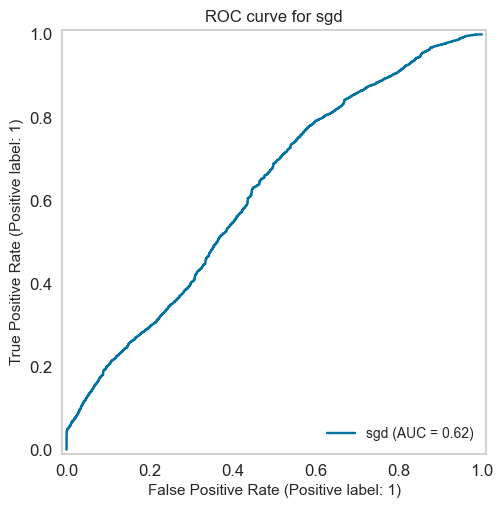

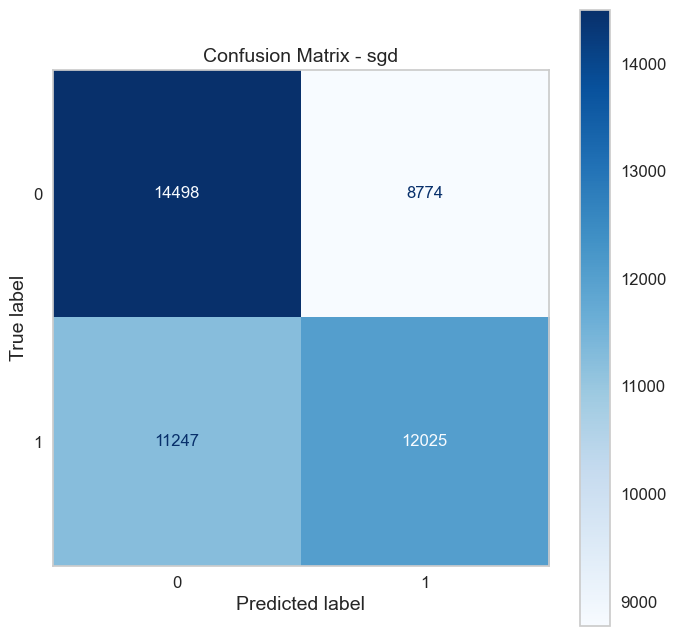



No feature importance for sgd





----------------------  logistic_regression  ----------------------


              precision    recall  f1-score   support

           0       0.59      0.57      0.58     23272
           1       0.58      0.61      0.60     23272

    accuracy                           0.59     46544
   macro avg       0.59      0.59      0.59     46544
weighted avg       0.59      0.59      0.59     46544



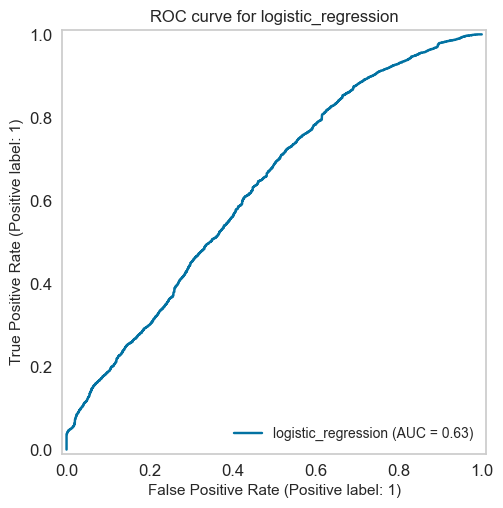

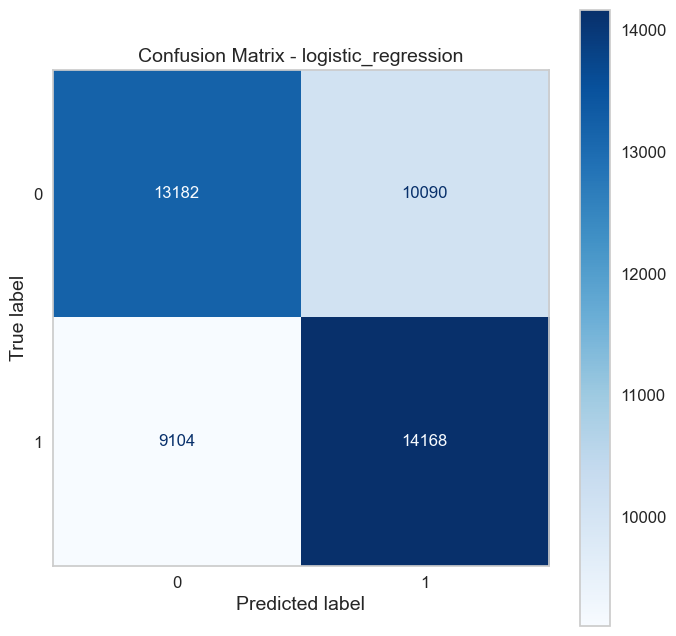

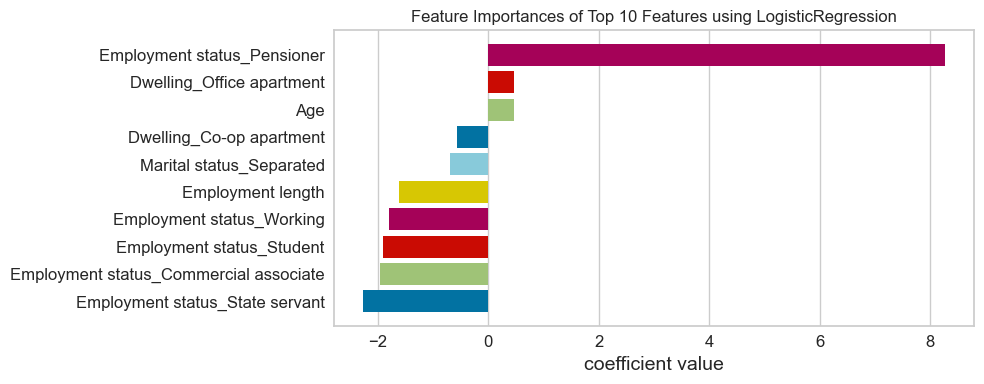

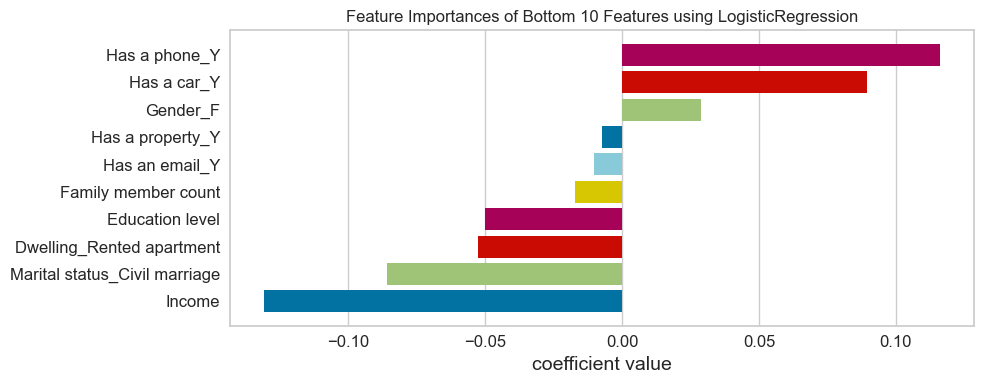






----------------------  decision_tree  ----------------------


              precision    recall  f1-score   support

           0       0.98      0.98      0.98     23272
           1       0.98      0.98      0.98     23272

    accuracy                           0.98     46544
   macro avg       0.98      0.98      0.98     46544
weighted avg       0.98      0.98      0.98     46544



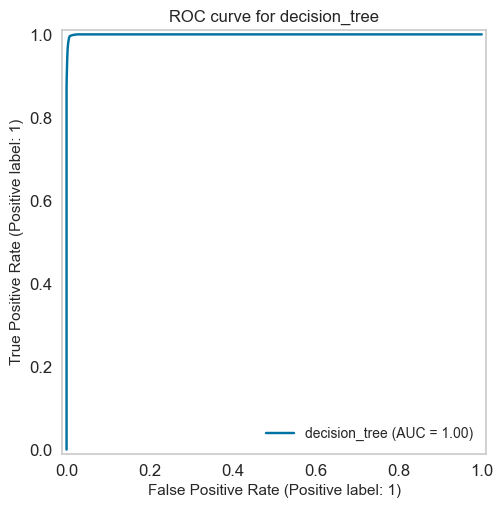

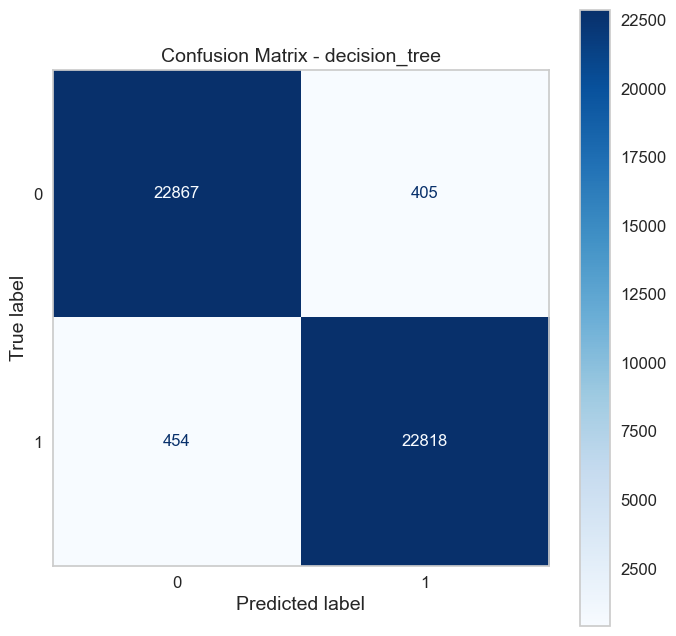

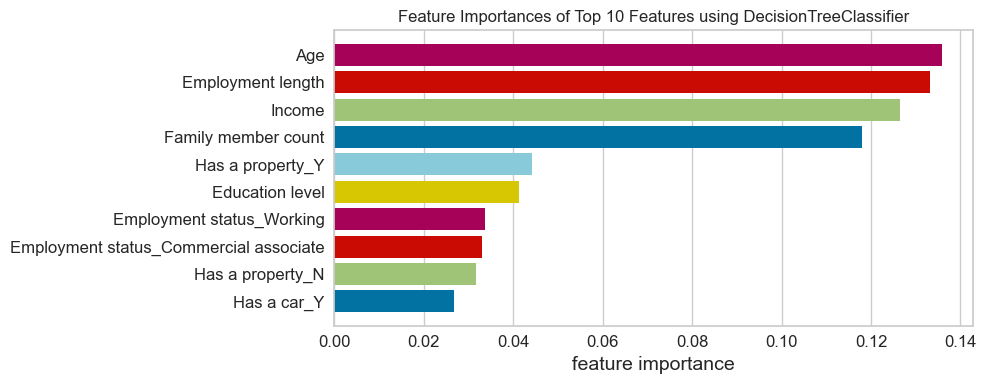

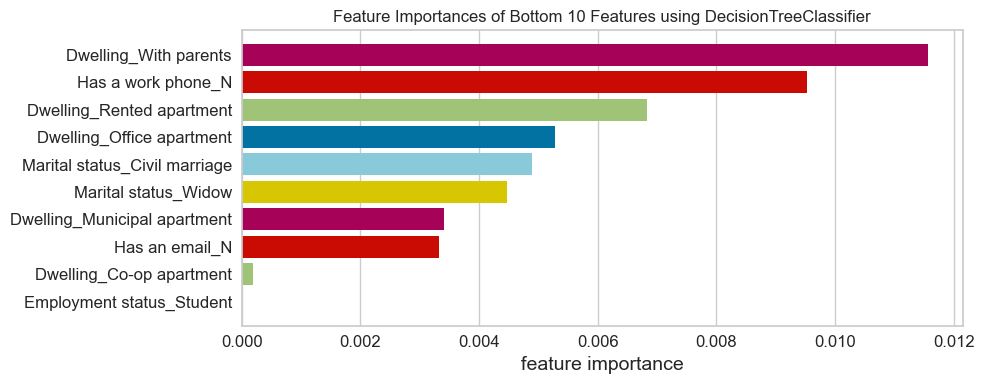






----------------------  random_forest  ----------------------


              precision    recall  f1-score   support

           0       0.99      0.99      0.99     23272
           1       0.99      0.99      0.99     23272

    accuracy                           0.99     46544
   macro avg       0.99      0.99      0.99     46544
weighted avg       0.99      0.99      0.99     46544



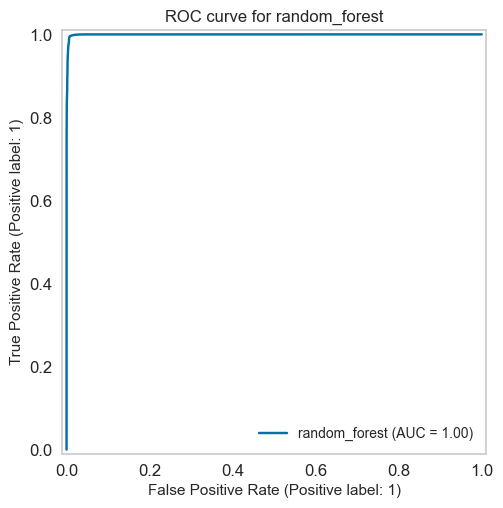

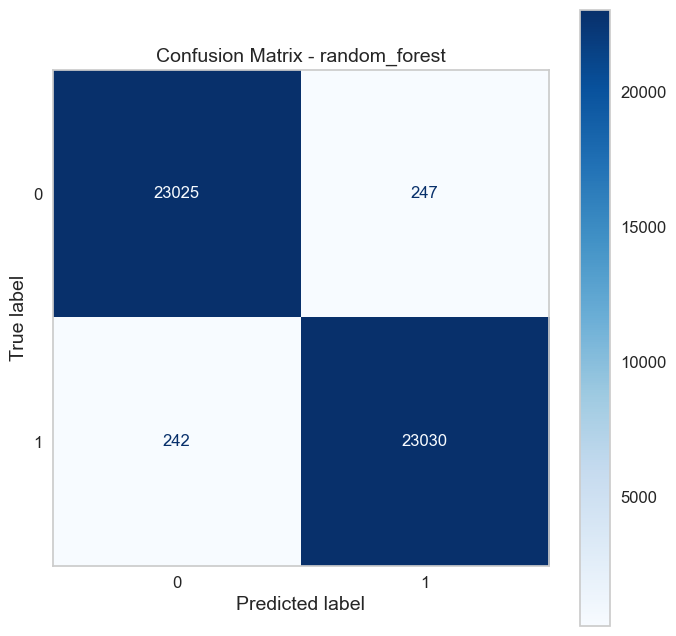

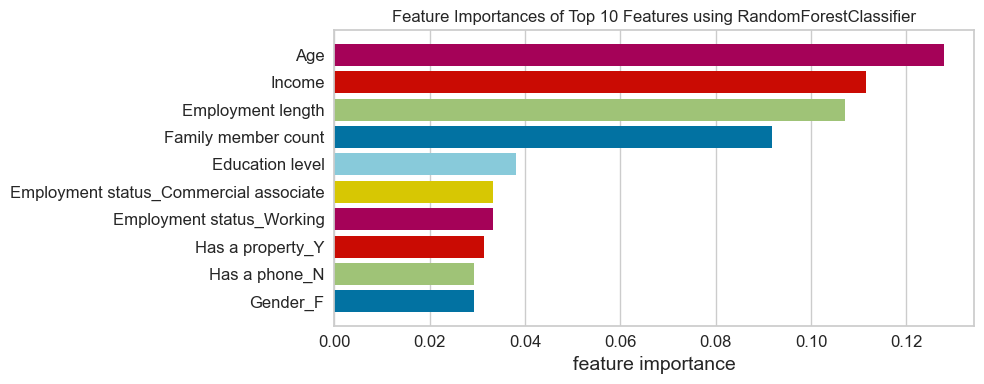

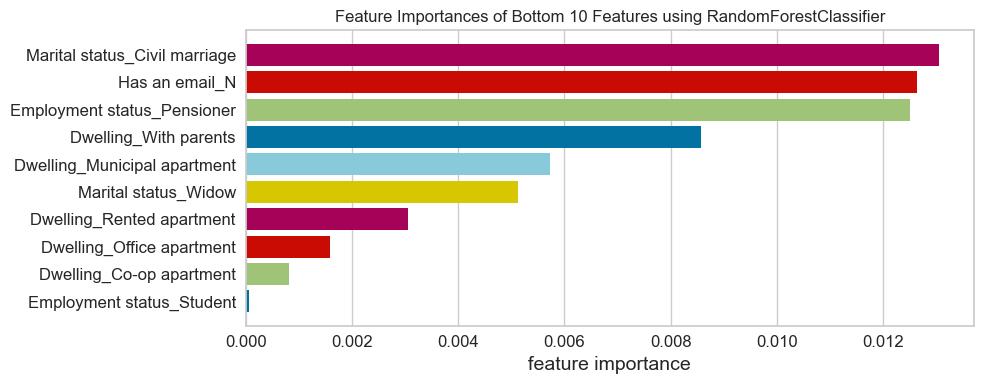






----------------------  gaussian_naive_bayes  ----------------------


              precision    recall  f1-score   support

           0       0.59      0.50      0.54     23272
           1       0.57      0.65      0.61     23272

    accuracy                           0.58     46544
   macro avg       0.58      0.58      0.58     46544
weighted avg       0.58      0.58      0.58     46544



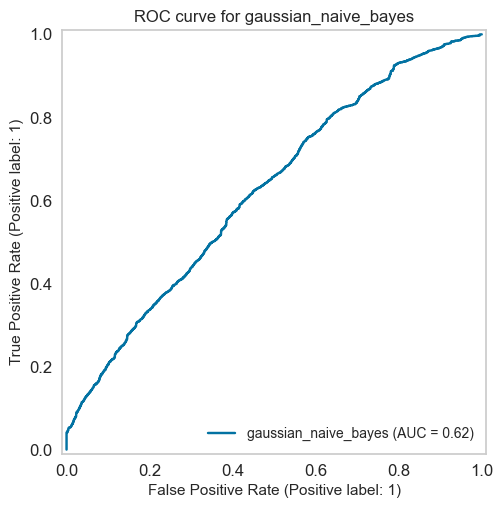

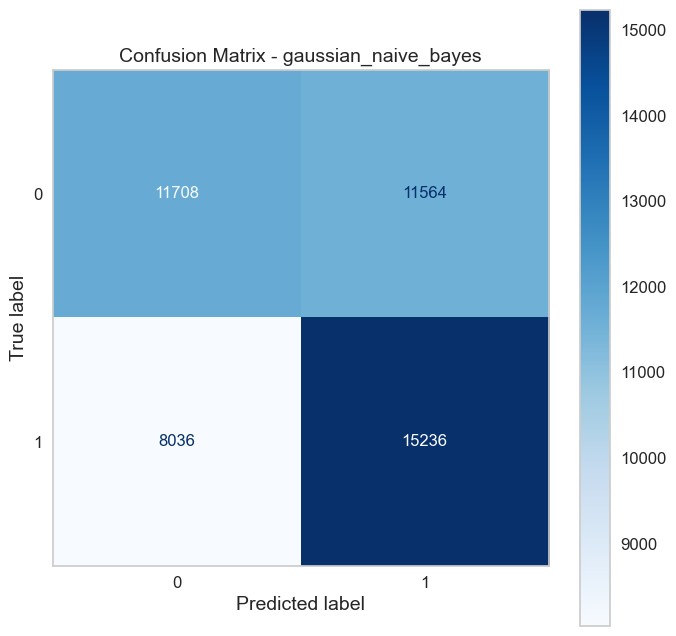



No feature importance for gaussian_naive_bayes





----------------------  k_nearest_neighbors  ----------------------


              precision    recall  f1-score   support

           0       0.93      0.96      0.95     23272
           1       0.96      0.93      0.94     23272

    accuracy                           0.94     46544
   macro avg       0.95      0.94      0.94     46544
weighted avg       0.95      0.94      0.94     46544



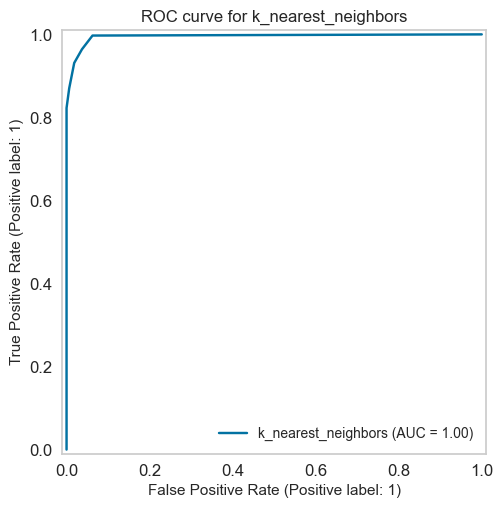

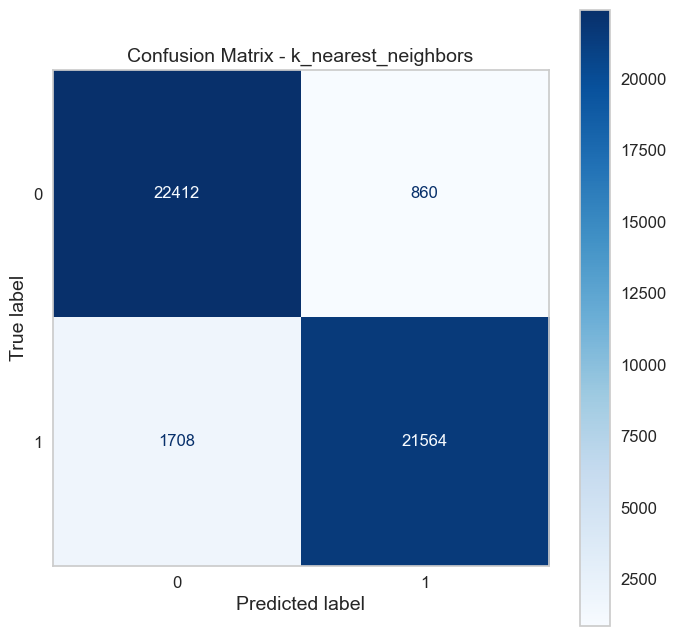



No feature importance for k_nearest_neighbors





----------------------  gradient_boosting  ----------------------


              precision    recall  f1-score   support

           0       0.90      0.91      0.90     23272
           1       0.91      0.90      0.90     23272

    accuracy                           0.90     46544
   macro avg       0.90      0.90      0.90     46544
weighted avg       0.90      0.90      0.90     46544



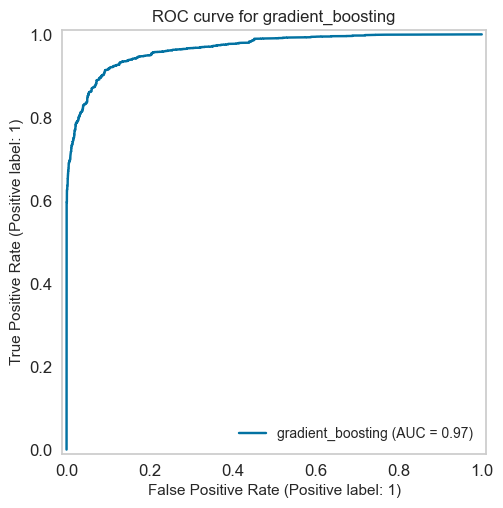

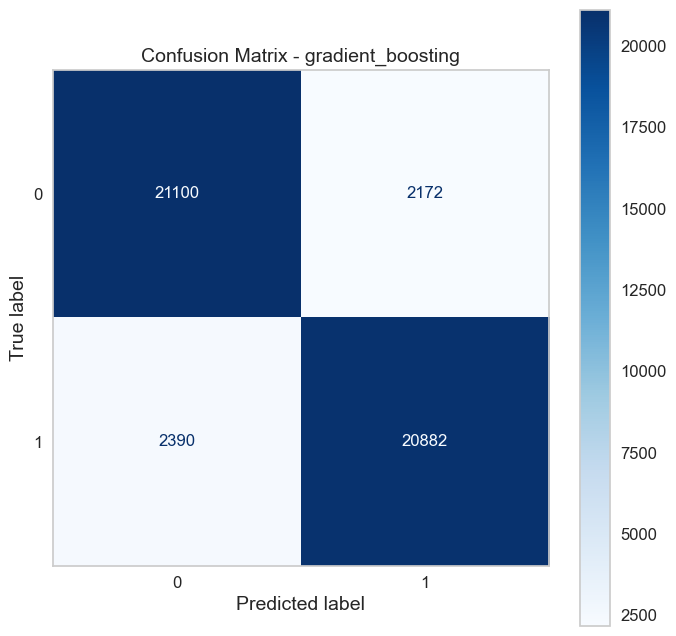

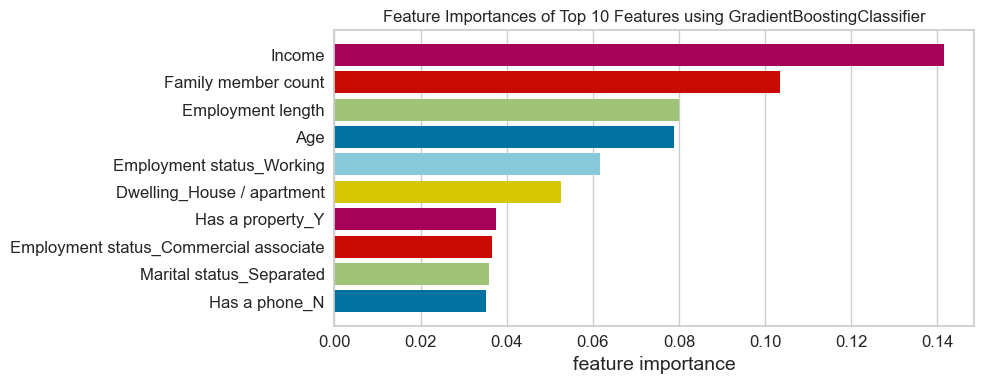

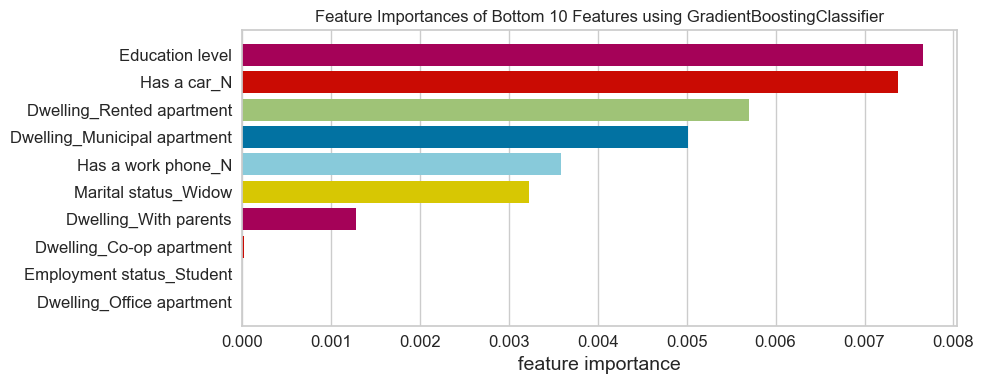






----------------------  linear_discriminant_analysis  ----------------------


              precision    recall  f1-score   support

           0       0.59      0.56      0.57     23272
           1       0.58      0.62      0.60     23272

    accuracy                           0.59     46544
   macro avg       0.59      0.59      0.59     46544
weighted avg       0.59      0.59      0.59     46544



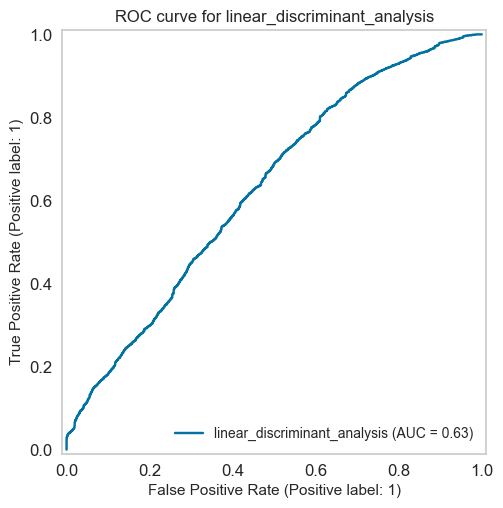

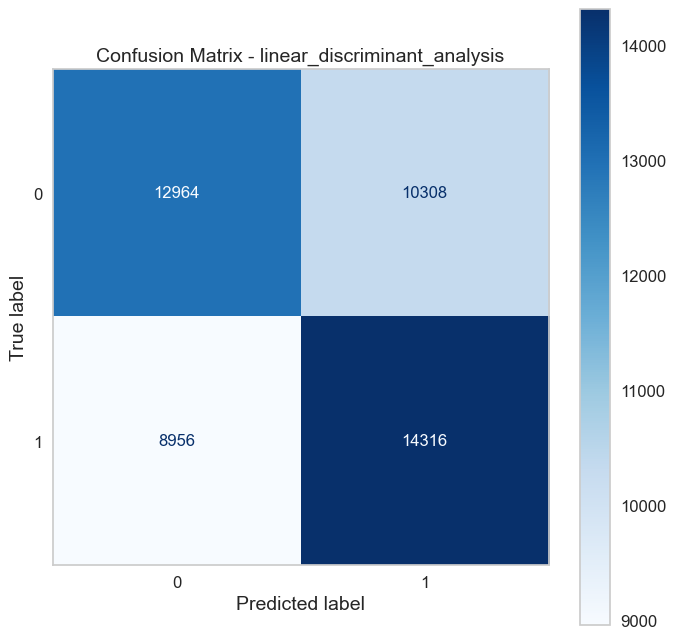

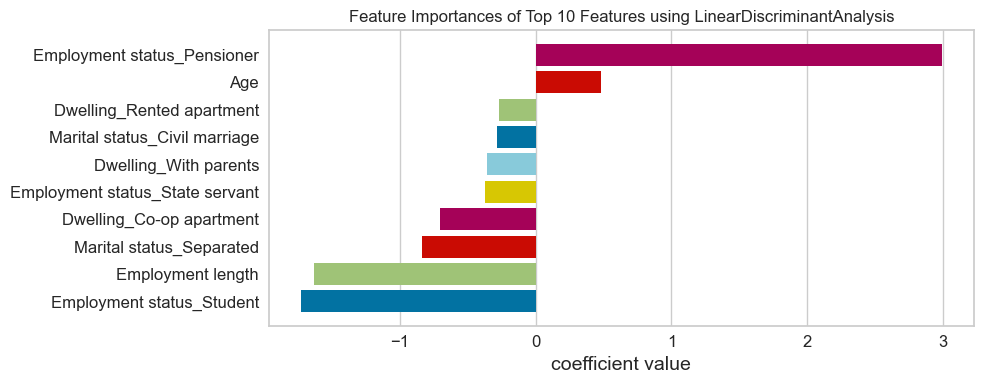

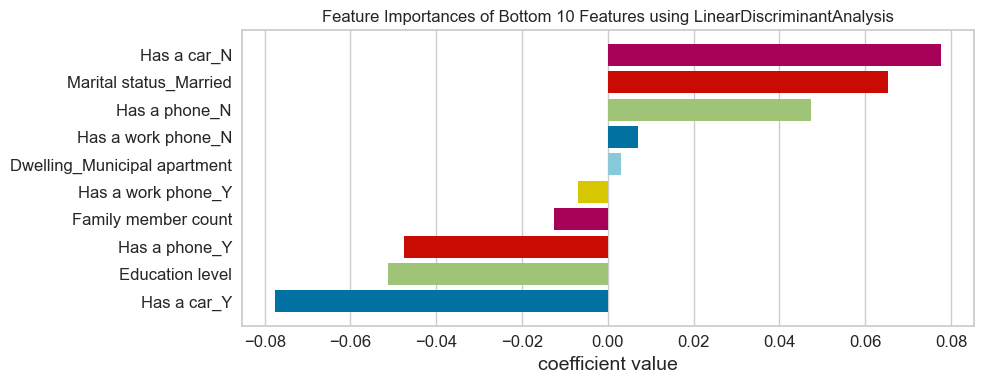






----------------------  bagging  ----------------------


              precision    recall  f1-score   support

           0       0.99      0.99      0.99     23272
           1       0.99      0.99      0.99     23272

    accuracy                           0.99     46544
   macro avg       0.99      0.99      0.99     46544
weighted avg       0.99      0.99      0.99     46544



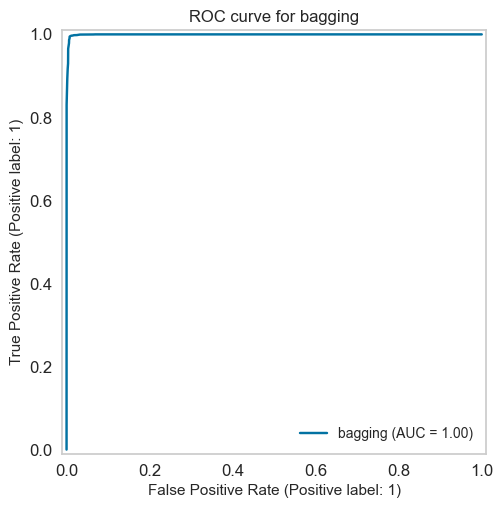

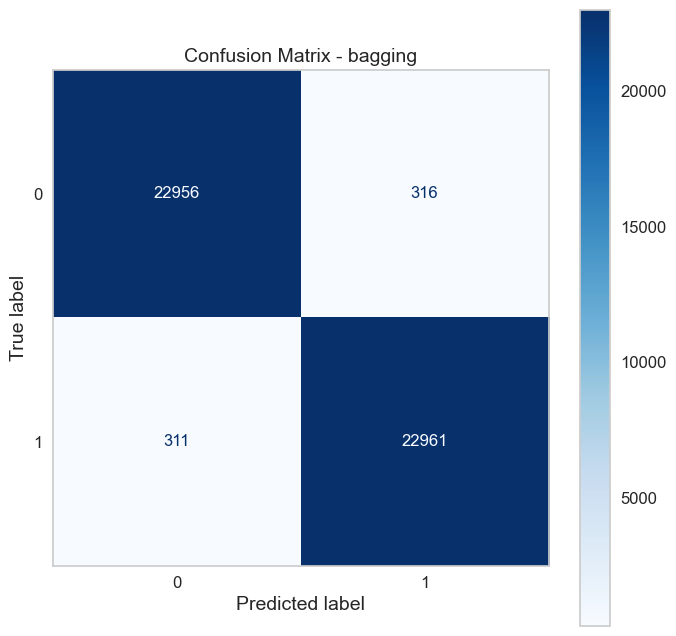



No feature importance for bagging





----------------------  neural_network  ----------------------


              precision    recall  f1-score   support

           0       0.98      0.93      0.95     23272
           1       0.93      0.98      0.96     23272

    accuracy                           0.95     46544
   macro avg       0.96      0.95      0.95     46544
weighted avg       0.96      0.95      0.95     46544



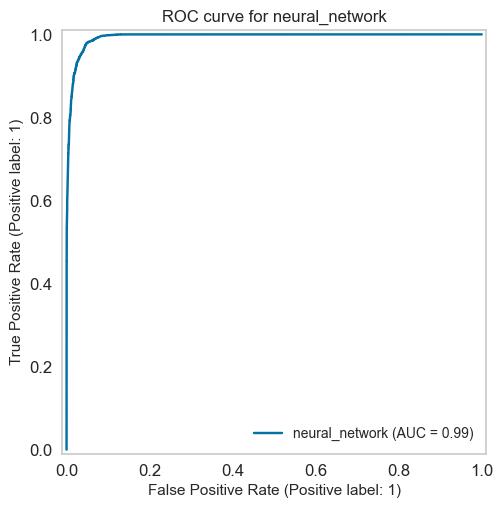

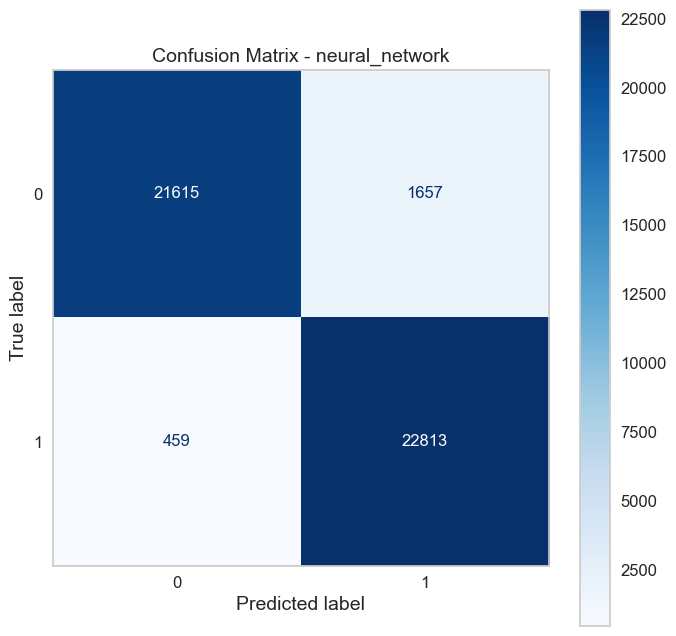



No feature importance for neural_network





----------------------  adaboost  ----------------------


              precision    recall  f1-score   support

           0       0.72      0.64      0.68     23272
           1       0.68      0.75      0.71     23272

    accuracy                           0.70     46544
   macro avg       0.70      0.70      0.69     46544
weighted avg       0.70      0.70      0.69     46544



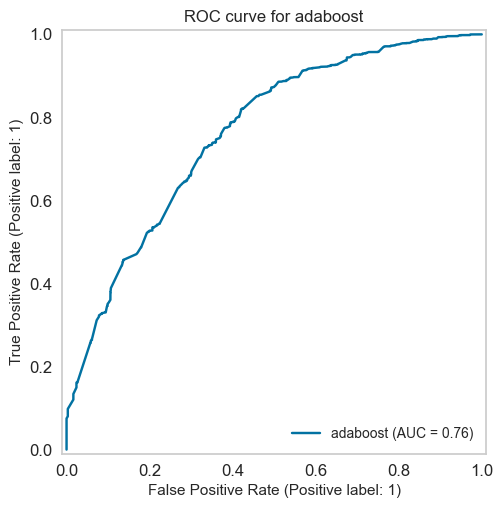

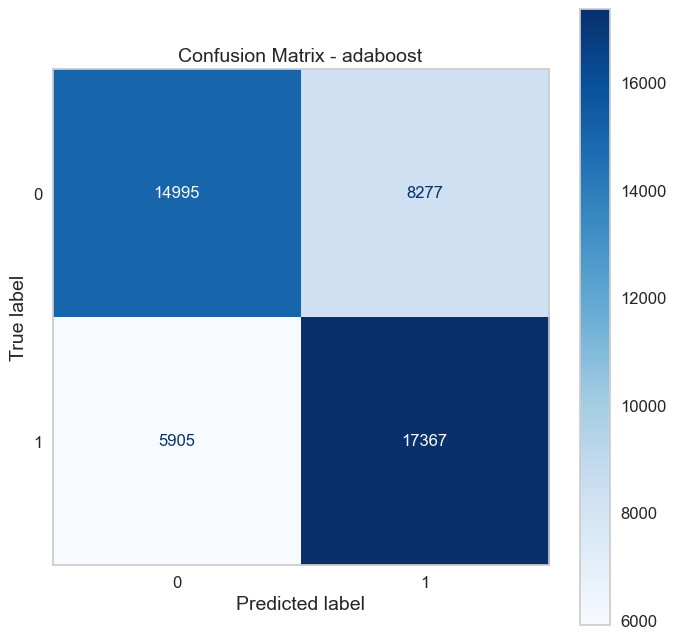

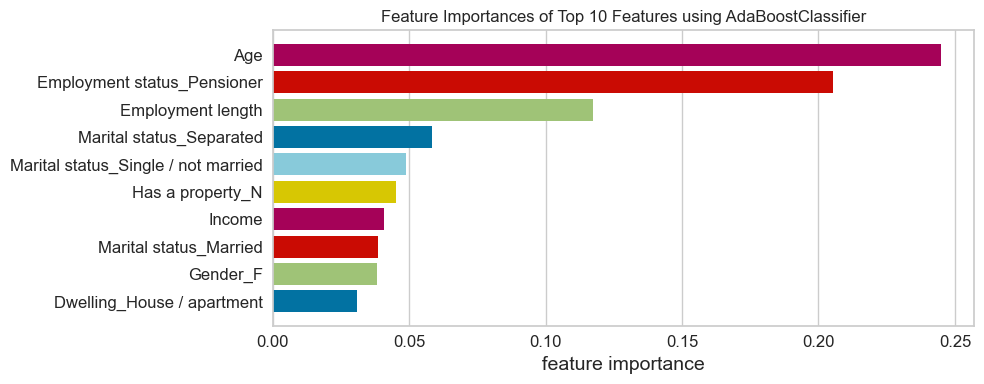

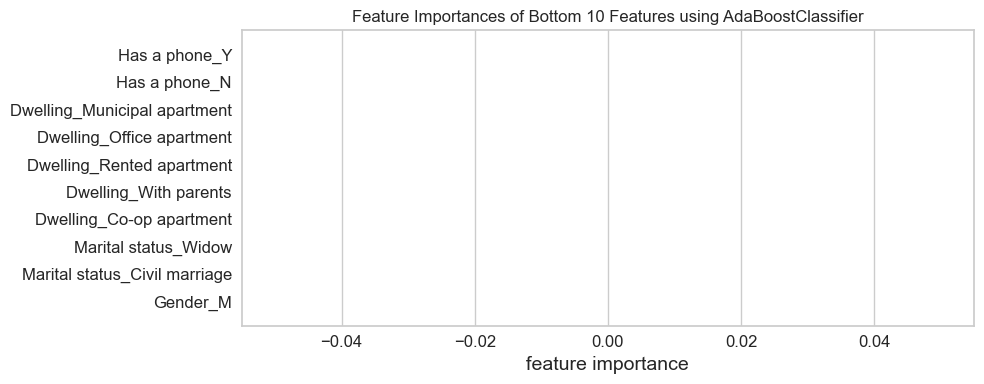






----------------------  extra_trees  ----------------------


              precision    recall  f1-score   support

           0       0.99      0.99      0.99     23272
           1       0.99      0.99      0.99     23272

    accuracy                           0.99     46544
   macro avg       0.99      0.99      0.99     46544
weighted avg       0.99      0.99      0.99     46544



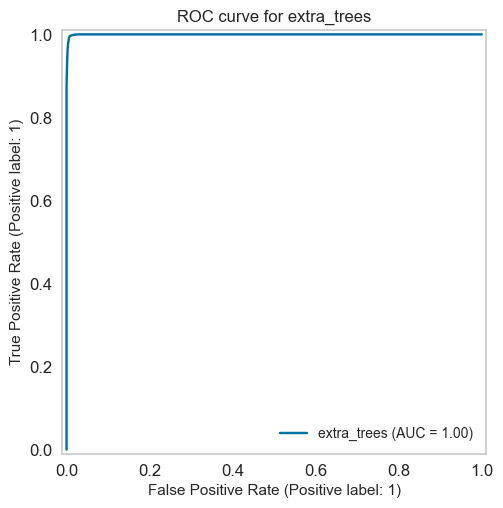

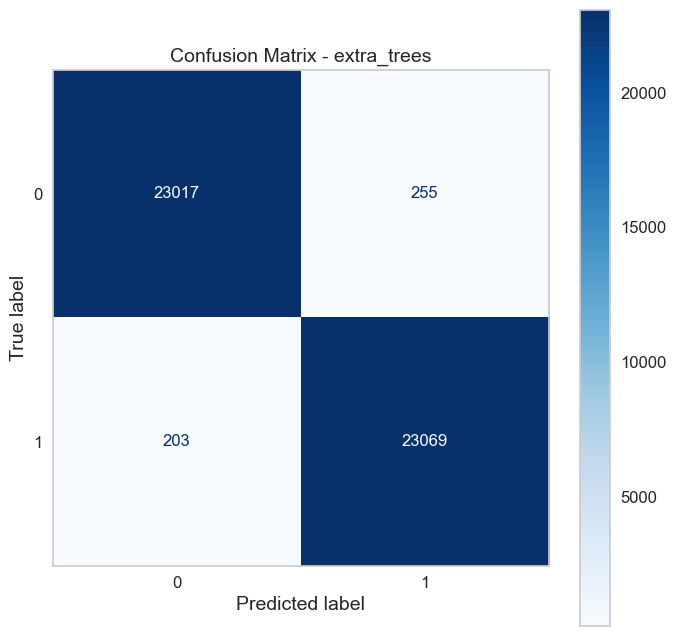

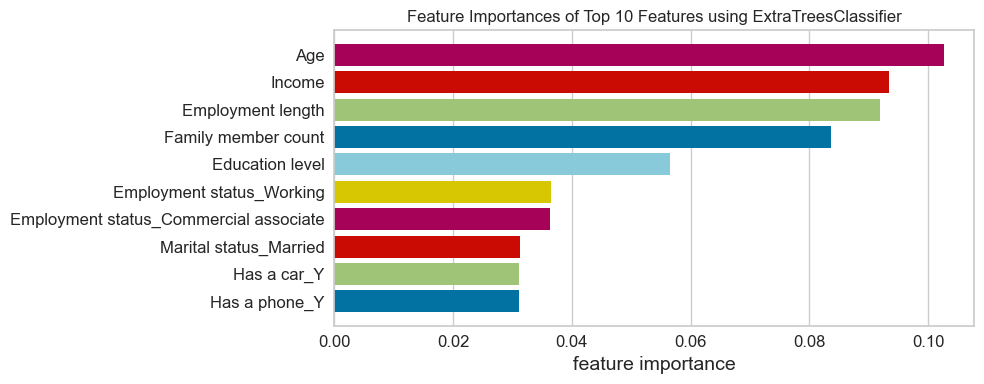

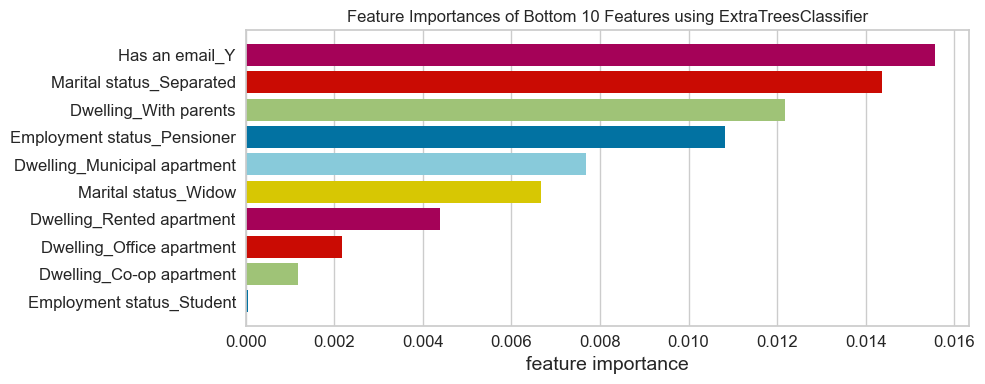

In [195]:
# ignore warnings (set once, before the loop)
warnings.filterwarnings("ignore")

# loop over all the models
for estimator_name, estimator in classifiers_v2.items():
    # title formatting
    print('\n\n')
    print('  {}  '.center(50, '-').format(estimator_name))
    print('\n')

    # verify if the folder for saving the estimator exists, if not build it
    dir_ensure_estimator()

    # fit the estimator
    estimator_trn = train_estimator(estimator, estimator_name)

    # print the scores from the classification report
    score_fn(estimator_trn, estimator_name)

    # chart the ROC curve
    roc_curve_fn(estimator_trn, estimator_name)

    # chart the confusion matrix
    confusion_matrix_fn(estimator_trn, estimator_name)

    # chart predictor importance
    feature_importance_chart(estimator_trn, estimator_name)

## 4.2 What metrics to use for this problem?

Since the objective of this problem is to minimize the risk of credit default for the financial institution, the metrics to use depends on the current economical situation:

- During the time of a bull market (when the economy is expending), people feel wealthy and usually are employed. Money is usually cheap and the risk of default is low. The financial institution is able to handle the risk of default therefore is not very strict on giving out credit. The financial institution can handle a number of bad clients as long as the vast majority of applicants are good clients (aka those who payback their credit).In this case, having a good recall (sensitivity) is ideal.
- During a bear market (when the economy is contracting), people loose their jobs and their money through the stock market. Many people struggle to meet their financial obligations. The financial institution therefore tend to be more conservative on giving out credit or loans. The financial institution can't afford to give out credit to clients who won't be able to pay back their credit. The financial institution would rather have a smaller number of good clients even if it means that some good clients where denied credit, and ideally not have any bad client. In this case, having a good precision (specificity) is desirable.
Note: There is always a trade-off between precision and recall. Choosing the right metrics depends on the problem you are solving.

Conclusion: In our case, since we are in the longest bull market (not including the March 2020 flash crash), we aim to use recall as our metric.

## 4.3 Top Estimator

Using the ROC curve and recall, we can that conclude that our top Estimator is:

- Gradient boosting classifier

# 5. Test the final Estimator on the test set

In [196]:
cc_test_clone.head(5)

ID Gender Has a car Has a property  Children count    Income  \
0  5091261      F         N              Y               0 202500.00   
1  5096963      M         Y              N               0 675000.00   
2  5087880      F         N              N               0 234000.00   
3  5021949      F         Y              Y               0 445500.00   
4  5105705      F         Y              N               0 225000.00   

      Employment status                Education level  Marital status  \
0         State servant  Secondary / secondary special       Separated   
1  Commercial associate               Higher education         Married   
2         State servant               Higher education  Civil marriage   
3  Commercial associate               Higher education         Married   
4               Working  Secondary / secondary special         Married   

              Dwelling    Age  Employment length  Has a mobile phone  \
0    House / apartment -16834              -1692                   1   
1    House / apartment -18126               -948                   1   
2    House / apartment -21967              -5215                   1   
3    House / apartment -12477               -456                   1   
4  Municipal apartment -12155               -667                   1   

   Has a work phone  Has a phone  Has an email       Job title  \
0                 0            0             0  Medicine staff   
1                 0            1             0        Managers   
2                 0            0             1      Core staff   
3                 0            0             0        Managers   
4                 0            0             0        Laborers   

   Family member count  Account age Is high risk  
0                 1.00        -6.00            0  
1                 2.00       -16.00            0  
2                 2.00       -52.00            0  
3                 2.00       -54.00            0  
4                 2.00       -48.00            0

In [197]:
cc_test_prepared = end_to_end_pipe(cc_test_clone)

In [198]:
# split the fit dataset into X and y (label)
X_cc_test_prepared, y_cc_test_prepared = cc_test_prepared.loc[:, cc_test_prepared.columns != 'Is high risk'], cc_test_prepared['Is high risk'].astype('int64')

In [199]:
# fit the estimator
estimator_trn = train_estimator(classifiers_v2['gradient_boosting'],'gradient_boosting')

In [200]:
final_predictions_v2 = estimator_trn.predict(X_cc_test_prepared)

In [201]:
final_predictions_v2.shape

(11654,)

In [202]:
n_correct_v2 = sum(final_predictions_v2 == y_cc_test_prepared)

In [203]:
print(n_correct_v2/len(final_predictions_v2))

0.8555860648704308
